## Библиотеки

In [1]:
import os
import json
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
# from selenium.webdriver.common.by import By
from fake_useragent import UserAgent
from bs4 import BeautifulSoup as bs

import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier # , AdaBoostClassifier, GradientBoostingClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore', category=UserWarning)

## Наброски и тестирование функций

### Cookie для парсинга (промежуточный шаг)

In [170]:
content = """[
{
    "domain": ".sberbank-ast.ru",
    "expirationDate": 1731777826,
    "hostOnly": false,
    "httpOnly": false,
    "name": "_ym_d",
    "path": "/",
    "sameSite": "no_restriction",
    "secure": true,
    "session": false,
    "storeId": "0",
    "value": "1700241827",
    "id": 1
},
{
    "domain": ".sberbank-ast.ru",
    "expirationDate": 1714609695,
    "hostOnly": false,
    "httpOnly": false,
    "name": "_ym_isad",
    "path": "/",
    "sameSite": "no_restriction",
    "secure": true,
    "session": false,
    "storeId": "0",
    "value": "2",
    "id": 2
},
{
    "domain": ".sberbank-ast.ru",
    "expirationDate": 1731777826,
    "hostOnly": false,
    "httpOnly": false,
    "name": "_ym_uid",
    "path": "/",
    "sameSite": "no_restriction",
    "secure": true,
    "session": false,
    "storeId": "0",
    "value": "1700241827330533764",
    "id": 3
},
{
    "domain": "www.sberbank-ast.ru",
    "hostOnly": true,
    "httpOnly": true,
    "name": "ASP.NET_SessionId",
    "path": "/",
    "sameSite": "lax",
    "secure": false,
    "session": true,
    "storeId": "0",
    "value": "k3ch3at1oez4n3wvmghnoxei",
    "id": 4
},
{
    "domain": "www.sberbank-ast.ru",
    "hostOnly": true,
    "httpOnly": false,
    "name": "BotMitigationCookie_11412016071036030678",
    "path": "/",
    "sameSite": "unspecified",
    "secure": false,
    "session": true,
    "storeId": "0",
    "value": "\"807122001714574376qrnnuKgnO74Yuv62YWmbUbwj2Ls=\"",
    "id": 5
}
]"""

### Парсинг участников на Сбербанк-АСТ

In [20]:
def line_to_dict(split_Line):

    line_dict = {}
    for part in split_Line:
        key, value = part.split(":")
        if value == ' true' or value == ' false':
            value = (value == ' true')
        elif value[1:].isnumeric():
            value = int(value[1:])
        elif key == '"sameSite"':
            if value[1:] == '"lax"' or value[1:] == '"strict"':
                value = value[1:].title()
                value = value[value.find('"') + 1 : value.rfind('"')]
            else:
                value = "None"
        else:
            value = value[value.find('"') + 1 : value.rfind('"')]
        key = key[key.find('"') + 1 : key.rfind('"')]
        line_dict[key] = value

    return line_dict

def convert(content) :
    os.remove("cookies.json")
    content = content.split("}")
    CON = []
    for line in content:
        norm = line[line.find('"') - 1 : line.rfind("\n")]
        norm = norm.split(",")
        norm = [x.strip() for x in norm]
        CON.append(norm)
    
    CON = CON[:-1]
    CON = [line_to_dict(x) for x in CON]
    
    # Output JSON 
    with open("cookies.json", 'w+') as fout:
        json.dump(CON, fout)

In [24]:
ua = UserAgent()
user_agent = ua.chrome  # Или другой браузер по вашему выбору

# Настройки для Chrome, включающие User-Agent
chrome_options = Options()
chrome_options.add_argument(f'user-agent={user_agent}')
chrome_options.add_argument('--disable-gpu')  # Отключение графики
chrome_options.add_argument('--disable-extensions')  # Отключение расширений
#chrome_options.add_argument('--headless')  # Работа без графического интерфейса

# Инициализация Chrome WebDriver с заданными опциями
driver = webdriver.Chrome(options=chrome_options)


# Переход на веб-страницу
driver.get('https://www.sberbank-ast.ru/ViewDocument.aspx?id=316998975')


convert(content)
with open('cookies.json', 'r') as f:
    cookies = json.load(f)

for cookie in cookies:
    driver.add_cookie(cookie)

# Перезагрузка страницы, чтобы применить файлы cookie
driver.refresh()

# Дальнейшие действия, такие как извлечение HTML-кода или взаимодействие с сайтом
page_source = driver.page_source

# Использование BeautifulSoup для парсинга HTML-кода
soup = bs(page_source, 'html.parser')
print("Done")

Done


In [25]:
def is_ok(SOUP):
    soup_string = str(SOUP)
    #print(soup_string)
    return soup_string.find("GenericErrorMessageCookies") == -1
is_ok(soup)

True

In [26]:
first_table = {'Дата принятия решения / Дата подписания письменного протокола': [],
                        'Способ определения поставщика (подрядчика, исполнителя)': [],
                        'Номер извещения': [],
                        'Идентификационный код закупки': [],
                        'Номер редакции извещения': [],'Наименование объекта закупки': [],
                        'Начальная (максимальная) цена контракта': [],
                        'Невозможно определить количество (объем) закупаемых товаров, работ, услуг': [],
                        'Дата и время начала проведения аукциона': [],
                        'Дата и время окончания проведения аукциона': []}

second_table = {"Наименование участника": [],
                        "Защищенный номер": [],
                        "Предложение о цене контракта": [],
                        "Дата и время подачи заявки": [],
                        "Дата и время подачи ценового предложения": [],
                        "Решение комиссии о соответствии или отклонении": [],
                        "Причина отклонения": [],
                        "Количество участников": [],
                        "Победитель": []}

In [81]:
def clear(X):
    if X.rfind("<") > X.find(">"):
        X_clear = X[X.find(">") + 1: X.rfind("<")].strip()
    else:
        X_clear = X[: X.rfind("<")].strip()
    if X_clear.find(">") != -1:
        return clear(X_clear)
    else:
        return X_clear

def to_time(time):
    mas = time.split(" ")
    mas = mas[:-1]
    time = mas[0] + " " + mas[1]
    return pd.to_datetime(time, format = "%d.%m.%Y %H:%M")

def sopostav(A, B):
    B = B[:-2] + [A[-5], A[-3]] + B[-2:]
    B[0] = pd.to_datetime(B[0], format = "%d.%m.%Y")
    B[-1] = to_time(B[-1])
    B[-2] = to_time(B[-2])
    
    for i in range(len(B)):
        if type(B[i]) == str:
            if B[i].isnumeric():
                B[i] = int(B[i])
    B[2] = str(B[2])
    
    A = A[:-5] + [A[-4]] + A[-2:]
    assert len(A) == len(B)
    dic = {}
    for i in range(len(A)):
        dic[A[i]] = B[i]
        if B[i] == '':
            dic[A[i]] = np.nan
    return dic

def help_sopostav(A, B):
    B = B[:-1] + [A[-4], A[-2]] + B[-1:]
    B[0] = pd.to_datetime(B[0], format = "%d.%m.%Y")
    B[-1] = to_time(B[-1])
    B = B + [B[-1]]
    
    for i in range(len(B)):
        if type(B[i]) == str:
            if B[i].isnumeric():
                B[i] = int(B[i])
    B[2] = str(B[2])
    
    A = A[:-4] + [A[-3]] + ['Дата и время начала проведения аукциона', 'Дата и время окончания проведения аукциона']
    assert len(A) == len(B)
    dic = {}
    for i in range(len(A)):
        dic[A[i]] = B[i]
        if B[i] == '':
            dic[A[i]] = np.nan
    return dic

def all_you_need(X):
    massive = X.split(" ")
    massive = [a.strip() for a in massive]
    return " ".join([x for x in massive if x != ""])

def append_zakupka(df_zakupki, soup, flag = True):
    
    global zakupka
    global first_table
    global second_table
    
    everything_important = soup.find_all('table', {"class" : "dt"})
    first = everything_important[2]
    
    title = clear(str(soup.find_all('h2')[1]))
    if title == "Протокол рассмотрения единственной заявки на электронный аукцион":
        return help_append_zakupka(df_zakupki, soup, flag)
    
    everything = first.find_all('td', {"class" : "fr"})
    important = first.find_all('td', {"class" : ""})
    everything, important = [str(x) for x in everything], [str(x) for x in important]
    everything, important = [clear(x) for x in everything], [clear(x) for x in important]
    dc_f = sopostav(everything, important)
    
    second = everything_important[4]
    third = [all_you_need(clear(str(x).replace("<br/>", ""))) for x in second.find_all('td', {"class" : "th"})]
    
    dc_s = {x: [] for x in list(second_table.keys())}
    names = list(dc_s.keys())
    #basic_names = names[:7]
    
    second = [str(x) for x in second.find_all('td', {"class" : ""})]
    
    #print(third)
    flag = not("Защищенный номер" in third)
    #print(flag)
    
    #second = [second[0]] + ["></td>"] + second[1:]
    
    if flag:
        LEN = len(second)
        for i in range(LEN//6):
            second = second[:7*i + 1] + ["></td>"] + second[7*i + 1:]
    #print(second, len(second))

    for i, x in enumerate(second):
        mas = dc_s[names[i % 7]]
        #print(names[i % 7])
        if x.find("<br/>") != -1:
            new = x[x.find(">") + 1: x.find("<br/>")]
        else:
            new = x[x.find(">") + 1: x.find("</td>")]

        if new == '':
            new = np.nan
        elif names[i % 7] in ["Защищенный номер"]:
            new = int(new)
        elif names[i % 7] in ["Предложение о цене контракта"]:
            if new == "-":
                new = 0.0
            new = float(new)
        elif names[i % 7] in ["Дата и время подачи заявки", "Дата и время подачи ценового предложения"]:
            new = pd.to_datetime(new, format = "%d.%m.%Y %H:%M:%S")
        mas.append(new)
        dc_s[names[i % 7]] = mas
    
    mas_winner = list(dc_s["Предложение о цене контракта"])
    #print(mas_winner)
    mas_approved = list(dc_s["Решение комиссии о соответствии или отклонении"])
    mas_date = list(dc_s["Дата и время подачи ценового предложения"])
    win = min(mas_winner)
    datetime = min([x for j, x in enumerate(mas_date) if mas_winner[j] == win])
    mas_bool = [((x == win) and (mas_approved[j] == "Соответствует") and (mas_date[j] == datetime)) for j, x in enumerate(mas_winner)]
    dc_s["Победитель"] = mas_bool
    
    dc_s["Количество участников"] = [(len(second)//7)] * (len(second)//7)
    
    #print(dc_s)
    
    N = zakupka.copy()
    for x in list(N.keys()):
        if x in list(first_table.keys()):
            mas = [dc_f[x]]* (len(second)//7)
            N[x] = mas
        if x in list(second_table.keys()):
            N[x] = dc_s[x]
    
    df_zakupki = pd.concat([df_zakupki, pd.DataFrame(N)], ignore_index=True)
    
    if flag:
        return df_zakupki
    else:
        return N

def help_append_zakupka(df_zakupki, soup, flag = True):
    
    global zakupka
    global first_table
    global second_table
    
    everything_important = soup.find_all('table', {"class" : "dt"})
    first = everything_important[2]

    title = clear(str(soup.find_all('h2')[1]))

    everything = first.find_all('td', {"class" : "fr"})
    important = first.find_all('td', {"class" : ""})
    everything, important = [str(x) for x in everything], [str(x) for x in important]
    everything, important = [clear(x) for x in everything], [clear(x) for x in important]


    dc_f = help_sopostav(everything, important)

    second = everything_important[4]
    dc_s = {x: [] for x in list(second_table.keys())}
    names = list(dc_s.keys())

    second = [str(x) for x in second.find_all('td', {"class" : ""})]
    second = [second[0]] + ["></td>"] + second[1:]

    #print(second)

    for i, x in enumerate(second):
        mas = dc_s[names[i % 7]]
        #print(names[i % 7])
        if x.find("<br/>") != -1:
            new = x[x.find(">") + 1: x.find("<br/>")]
        else:
            new = x[x.find(">") + 1: x.find("</td>")]

        if new == '':
            new = np.nan
        elif names[i % 7] in ["Защищенный номер"]:
            new = int(new)
        elif names[i % 7] in ["Предложение о цене контракта"]:
            if new == "-":
                new = 0.0
            new = float(new)
        elif names[i % 7] in ["Дата и время подачи заявки", "Дата и время подачи ценового предложения"]:
            new = pd.to_datetime(new, format = "%d.%m.%Y %H:%M:%S")
        mas.append(new)
        dc_s[names[i % 7]] = mas
    
    mas_winner = list(dc_s["Предложение о цене контракта"])
    #print(mas_winner)
    mas_approved = list(dc_s["Решение комиссии о соответствии или отклонении"])
    mas_date = list(dc_s["Дата и время подачи ценового предложения"])
    win = min(mas_winner)
    datetime = min([x for j, x in enumerate(mas_date) if mas_winner[j] == win])
    mas_bool = [((x == win) and (mas_approved[j] == "Соответствует") and (mas_date[j] == datetime)) for j, x in enumerate(mas_winner)]
    dc_s["Победитель"] = mas_bool
    
    dc_s["Количество участников"] = [(len(second)//7)] * (len(second)//7)
    
    #print(dc_s)
    
    N = zakupka.copy()
    for x in list(N.keys()):
        if x in list(first_table.keys()):
            mas = [dc_f[x]]* (len(second)//7)
            N[x] = mas
        if x in list(second_table.keys()):
            N[x] = dc_s[x]
    
    df_zakupki = pd.concat([df_zakupki, pd.DataFrame(N)], ignore_index=True)
    
    if flag:
        return df_zakupki
    else:
        return N

In [82]:
zakupka = first_table | second_table
df_zakupki = pd.DataFrame(zakupka)

df_z = append_zakupka(df_zakupki, soup)

In [83]:
df_z

Дата принятия решения / Дата подписания письменного протокола  \
0                                         2015-06-25              
1                                         2015-06-25              
2                                         2015-06-25              
3                                         2015-06-25              
4                                         2015-06-25              
5                                         2015-06-25              
6                                         2015-06-25              

  Способ определения поставщика (подрядчика, исполнителя)     Номер извещения  \
0                                Электронный аукцион       124100001215000050   
1                                Электронный аукцион       124100001215000050   
2                                Электронный аукцион       124100001215000050   
3                                Электронный аукцион       124100001215000050   
4                                Электронный аукцион       124100001215000050   
5                                Электронный аукцион       124100001215000050   
6                                Электронный аукцион       124100001215000050   

   Идентификационный код закупки  Номер редакции извещения  \
0                            NaN                       0.0   
1                            NaN                       0.0   
2                            NaN                       0.0   
3                            NaN                       0.0   
4                            NaN                       0.0   
5                            NaN                       0.0   
6                            NaN                       0.0   

                        Наименование объекта закупки  \
0  Поставка средств индивидуальной медицинской за...   
1  Поставка средств индивидуальной медицинской за...   
2  Поставка средств индивидуальной медицинской за...   
3  Поставка средств индивидуальной медицинской за...   
4  Поставка средств индивидуальной медицинской за...   
5  Поставка средств индивидуальной медицинской за...   
6  Поставка средств индивидуальной медицинской за...   

   Начальная (максимальная) цена контракта  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
5                                      NaN   
6                                      NaN   

   Невозможно определить количество (объем) закупаемых товаров, работ, услуг  \
0                                                NaN                           
1                                                NaN                           
2                                                NaN                           
3                                                NaN                           
4                                                NaN                           
5                                                NaN                           
6                                                NaN                           

  Дата и время начала проведения аукциона  \
0                     2015-06-22 12:05:00   
1                     2015-06-22 12:05:00   
2                     2015-06-22 12:05:00   
3                     2015-06-22 12:05:00   
4                     2015-06-22 12:05:00   
5                     2015-06-22 12:05:00   
6                     2015-06-22 12:05:00   

  Дата и время окончания проведения аукциона  \
0                        2015-06-22 12:26:00   
1                        2015-06-22 12:26:00   
2                        2015-06-22 12:26:00   
3                        2015-06-22 12:26:00   
4                        2015-06-22 12:26:00   
5                        2015-06-22 12:26:00   
6                        2015-06-22 12:26:00   

                              Наименование участника  Защищенный номер  \
0  Общество с ограниченной ответственнос

### Парсинг конкретной закупки + ОКПД + ссылка на Сбербанк-АСТ

In [81]:
def additional_data(df, driver):

    mas_h, mas_O, mas_bool = [], [], []
    mas_len = []

    numbers = list(df['Реестровый номер закупки']) # по 223 пока вообще не ищет!!!
    fz = list(df['Закупки по'])
    df_new = df.copy()

    for i in tqdm(range(len(numbers)), desc = "Adding lost information"):

        num = numbers[i]

        if fz[i] == "223-ФЗ":
            #print("Skiping 223-ФЗ")
            #print("")
            mas_h.append(np.nan)
            mas_bool.append(False)
            mas_O.append(np.nan)
            mas_len.append(0)
            continue

        driver.get(f'https://zakupki.gov.ru/epz/order/notice/ea44/view/supplier-results.html?regNumber={num[1:]}')

        driver.refresh()

        # Дальнейшие действия, такие как извлечение HTML-кода или взаимодействие с сайтом
        page_source = driver.page_source

        # Использование BeautifulSoup для парсинга HTML-кода
        soup = bs(page_source, 'html.parser')
        #print(f"Href done: {num}")

        LST = soup.find_all("span", {"class": "section__info"})

        #cost = [str(x) for x in lst][0]
        if len(LST) != 0:
            href = [str(x) for x in LST][0]
            href = href[href.find('href="') + len('href="') : href.find('" target=')]
        else:
            href = np.nan


        if href.find("sberbank-ast") != -1:
            #print("Valid Sberbank href. Printing:", href, sep = " ")
            #print("-"*20)
            mas_h.append(href)
            mas_bool.append(True)
        else:
            #print("Invalid href. Contains a file or a url of different from Sberbak-AST website.")
            #print("-"*20)
            mas_h.append(np.nan)
            mas_bool.append(False)


        driver.get(f'https://zakupki.gov.ru/epz/order/notice/ea44/view/common-info.html?regNumber={num[1:]}')

        driver.refresh()


        page_source = driver.page_source


        soup = bs(page_source, 'html.parser')
        #print(f"ODKP done: {num}")

        lst = soup.find_all("table", {"class": "blockInfo__table tableBlock"})
        lst = [x for x in lst if str(x).find("Код позиции") != -1][0]
        aa = lst.find_all("td", {"class": "tableBlock__col"})
        aa = [str(x) for x in aa]
        aa = [clear(x) for x in aa if x.find(".") != -1]

        ODKP = aa[0]
        #print("ODKP:", ODKP, sep = " ")
        #print("-"*20, "\n")
        mas_O.append(ODKP)
        mas_len.append(len(aa))

    df_new["Сайт закупки"] = pd.Series(mas_h)
    df_new["Bool"] = pd.Series(mas_bool)
    df_new["Классификация по ОКДП"] = pd.Series(mas_O)
    df_new["Количество товаров в лоте"] = pd.Series(mas_len)

    df_new = df_new[df_new["Bool"] == True]
    df_new.reset_index(inplace = True, drop = True)
    del df_new["Bool"]
    
    return df_new

In [82]:
ua = UserAgent()
user_agent = ua.chrome  # Или другой браузер по вашему выбору

# Настройки для Chrome, включающие User-Agent
chrome_options = Options()
chrome_options.add_argument(f'user-agent={user_agent}')
chrome_options.add_argument('--disable-gpu')  # Отключение графики
chrome_options.add_argument('--disable-extensions')  # Отключение расширений
chrome_options.add_argument('--headless')  # Работа без графического интерфейса

df = pd.read_excel("C:/Users/Admin/Desktop/to_parse/1.xlsx")
#df = pd.read_csv("C:/Users/Admin/Desktop/1.csv")


# Инициализация Chrome WebDriver с заданными опциями
driver = webdriver.Chrome(options=chrome_options)

dff = additional_data(df, driver)

"""
import IPython.display

IPython.display.HTML(dff.to_html())
"""

Adding lost information: 100%|██████████| 11/11 [00:23<00:00,  2.17s/it]


'\nimport IPython.display\n\nIPython.display.HTML(dff.to_html())\n'

In [79]:
df = pd.read_excel("C:/Users/Admin/Desktop/lool.xlsx")

"""
lst = soup.find_all("table", {"class": "blockInfo__table tableBlock"})
lst = [x for x in lst if str(x).find("Код позиции") != -1][0]
aa = lst.find_all("td", {"class": "tableBlock__col"})
aa = [str(x) for x in aa]
bb = aa.copy()
aa = [clear(x) for x in aa if x.find(".") != -1]
prom_num = [float(clear(bb[i + 5]).replace(",", ".").replace("\xa0", "")) for i, x in enumerate(bb) if clear(x) in aa]
"""

mas_h, mas_O, mas_bool = [], [], []
mas_len = []

numbers = list(df['Реестровый номер закупки']) # по 223 пока вообще не ищет!!!
fz = list(df['Закупки по'])
df_new = df.copy()

for i in tqdm(range(len(numbers)), desc = "Adding lost information"):

    num = numbers[i]

    if fz[i] == "223-ФЗ":
        #print("Skiping 223-ФЗ")
        #print("")
        mas_h.append(np.nan)
        mas_bool.append(False)
        mas_O.append(np.nan)
        mas_len.append(0)
        continue

    driver.get(f'https://zakupki.gov.ru/epz/order/notice/ea44/view/supplier-results.html?regNumber={num[1:]}')

    driver.refresh()

    # Дальнейшие действия, такие как извлечение HTML-кода или взаимодействие с сайтом
    page_source = driver.page_source

    # Использование BeautifulSoup для парсинга HTML-кода
    soup = bs(page_source, 'html.parser')
    #print(f"Href done: {num}")

    LST = soup.find_all("span", {"class": "section__info"})

    #cost = [str(x) for x in lst][0]
    if len(LST) != 0:
        href = [str(x) for x in LST][0]
        href = href[href.find('href="') + len('href="') : href.find('" target=')]
    else:
        href = np.nan


    if href.find("sberbank-ast") != -1:
        #print("Valid Sberbank href. Printing:", href, sep = " ")
        #print("-"*20)
        mas_h.append(href)
        mas_bool.append(True)
    else:
        #print("Invalid href. Contains a file or a url of different from Sberbak-AST website.")
        #print("-"*20)
        mas_h.append(np.nan)
        mas_bool.append(False)


    driver.get(f'https://zakupki.gov.ru/epz/order/notice/ea44/view/common-info.html?regNumber={num[1:]}')

    driver.refresh()


    page_source = driver.page_source


    soup = bs(page_source, 'html.parser')
    #print(f"ODKP done: {num}")

    lst = soup.find_all("table", {"class": "blockInfo__table tableBlock"})
    lst = [x for x in lst if str(x).find("Код позиции") != -1][0]
    aa = lst.find_all("td", {"class": "tableBlock__col"})
    aa = [str(x) for x in aa]
    aa = [clear(x) for x in aa if x.find(".") != -1]

    ODKP = aa[0]
    #print("ODKP:", ODKP, sep = " ")
    #print("-"*20, "\n")
    mas_O.append(ODKP)
    mas_len.append(len(aa))

df_new["Сайт закупки"] = pd.Series(mas_h)
df_new["Bool"] = pd.Series(mas_bool)
df_new["Классификация по ОКДП"] = pd.Series(mas_O)
df_new["Количество товаров в лоте"] = pd.Series(mas_len)

df_new = df_new[df_new["Bool"] == True]
df_new.reset_index(inplace = True, drop = True)
del df_new["Bool"]

df_new

Adding lost information: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Закупки по Реестровый номер закупки  \
0      44-ФЗ     №0132100004415000031   

  Способ определения поставщика (подрядчика, исполнителя), подрядной организации (размещения закупки)  \
0                                Электронный аукцион                                                    

                     Наименование закупки  \
0  Поставка имущества гражданской обороны   

   Предмет электронного аукциона (только для ПП РФ 615)  Номер лота  \
0                                                NaN            NaN   

   Наименование лота  Начальная (максимальная) цена контракта  \
0                NaN                                 33467.53   

  Классификация по ОКДП  Классификация по ОКПД  Классификация по ОКПД2  \
0          24.42.24.170                    NaN                     NaN   

   Код позиции                             Наименование Заказчика  \
0          NaN  ОПЕРАТИВНО-ПОИСКОВАЯ СЛУЖБА-ФИЛИАЛ РЕГИОНАЛЬНО...   

             Организация, осуществляющая размещение  Дата размещения  \
0  оперативно-поисковая служба - филиал Региональ...      2015-11-17   

  Дата обновления Дата начала подачи заявок Дата окончания подачи заявок  \
0      2015-12-07                2015-11-17                   2015-11-26   

                                        Сайт закупки  \
0  http://www.sberbank-ast.ru/ViewDocument.aspx?i...   

   Количество товаров в лоте  
0                          3

### Код для сводной таблицы по конкретному документу

In [291]:
content = """[
{
    "domain": ".sberbank-ast.ru",
    "expirationDate": 1731777826,
    "hostOnly": false,
    "httpOnly": false,
    "name": "_ym_d",
    "path": "/",
    "sameSite": "no_restriction",
    "secure": true,
    "session": false,
    "storeId": "0",
    "value": "1700241827",
    "id": 1
},
{
    "domain": ".sberbank-ast.ru",
    "expirationDate": 1714609695,
    "hostOnly": false,
    "httpOnly": false,
    "name": "_ym_isad",
    "path": "/",
    "sameSite": "no_restriction",
    "secure": true,
    "session": false,
    "storeId": "0",
    "value": "2",
    "id": 2
},
{
    "domain": ".sberbank-ast.ru",
    "expirationDate": 1731777826,
    "hostOnly": false,
    "httpOnly": false,
    "name": "_ym_uid",
    "path": "/",
    "sameSite": "no_restriction",
    "secure": true,
    "session": false,
    "storeId": "0",
    "value": "1700241827330533764",
    "id": 3
},
{
    "domain": "www.sberbank-ast.ru",
    "hostOnly": true,
    "httpOnly": true,
    "name": "ASP.NET_SessionId",
    "path": "/",
    "sameSite": "lax",
    "secure": false,
    "session": true,
    "storeId": "0",
    "value": "5uz2xt25jg03s4j0dvxeivop",
    "id": 4
},
{
    "domain": "www.sberbank-ast.ru",
    "hostOnly": true,
    "httpOnly": false,
    "name": "BotMitigationCookie_11412016071036030678",
    "path": "/",
    "sameSite": "unspecified",
    "secure": false,
    "session": true,
    "storeId": "0",
    "value": "\"910645001714593035RXqIK56a9HYGtkeaqWE/mSyr4+4=\"",
    "id": 5
}
]"""

In [192]:
"""
import IPython.display

IPython.display.HTML(dff.to_html())
"""

'\nimport IPython.display\n\nIPython.display.HTML(dff.to_html())\n'

In [80]:
first_table = {'Дата принятия решения / Дата подписания письменного протокола': [],
                        'Способ определения поставщика (подрядчика, исполнителя)': [],
                        'Номер извещения': [],
                        'Идентификационный код закупки': [],
                        'Номер редакции извещения': [],'Наименование объекта закупки': [],
                        'Начальная (максимальная) цена контракта': [],
                        'Невозможно определить количество (объем) закупаемых товаров, работ, услуг': [],
                        'Дата и время начала проведения аукциона': [],
                        'Дата и время окончания проведения аукциона': []}

second_table = {"Наименование участника": [],
                        "Защищенный номер": [],
                        "Предложение о цене контракта": [],
                        "Дата и время подачи заявки": [],
                        "Дата и время подачи ценового предложения": [],
                        "Решение комиссии о соответствии или отклонении": [],
                        "Причина отклонения": [],
                        "Количество участников": [],
                        "Победитель": []}

zakupka = first_table | second_table

basing = ['Закупки по',
         'Реестровый номер закупки',
         'Способ определения поставщика (подрядчика, исполнителя), подрядной организации (размещения закупки)',
         'Наименование закупки',
         'Предмет электронного аукциона (только для ПП РФ 615)',
         'Номер лота',
         'Наименование лота',
         'Начальная (максимальная) цена контракта',
         'Классификация по ОКДП',
         'Классификация по ОКПД',
         'Классификация по ОКПД2',
         'Код позиции',
         'Наименование Заказчика',
         'Организация, осуществляющая размещение ',
         'Дата размещения',
         'Дата обновления',
         'Дата начала подачи заявок',
         'Дата окончания подачи заявок',
         'Сайт закупки',
         "Количество товаров в лоте"]

base_info = {x: [] for x in basing}
auction = base_info | zakupka

In [293]:
def connect_to_zakupka(website):
    ua = UserAgent()
    user_agent = ua.chrome 

    chrome_options = Options()
    chrome_options.add_argument(f'user-agent={user_agent}')
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_argument('--disable-extensions')

    driver = webdriver.Chrome(options=chrome_options)
    driver.get(website)

    convert(content)
    
    with open('cookies.json', 'r') as f:
        cookies = json.load(f)

    for cookie in cookies:
        driver.add_cookie(cookie)

    driver.refresh()
    page_source = driver.page_source

    soup = bs(page_source, 'html.parser')
    
    if not is_ok(soup):
        return "update cookies"
    
    df_zakupki = pd.DataFrame(zakupka)
    dic_zak = append_zakupka(df_zakupki, soup, flag = False)
    
    return dic_zak

In [296]:
dff

Закупки по Реестровый номер закупки  \
0      44-ФЗ     №0173100012515000267   
1      44-ФЗ     №0358100010015000191   
2      44-ФЗ     №0173100012514000331   
3      44-ФЗ     №0362100026215000214   
4      44-ФЗ     №0351100018115000065   

  Способ определения поставщика (подрядчика, исполнителя), подрядной организации (размещения закупки)  \
0                                Электронный аукцион                                                    
1                                Электронный аукцион                                                    
2                                Электронный аукцион                                                    
3                                Электронный аукцион                                                    
4                                Электронный аукцион                                                    

                         Наименование закупки  \
0  № 277-2015АЭ Противогаз фильтрующий ПМК-С.   
1                            Противогаз ПМК-С   
2    293-2014АЭ Противогаз фильтрующий ПМК-С.   
3               Противогаз фильтрующий  ПМК-С   
4                Противогаз фильтрующий ПМК-С   

   Предмет электронного аукциона (только для ПП РФ 615)  Номер лота  \
0                                                NaN            NaN   
1                                                NaN            NaN   
2                                                NaN            NaN   
3                                                NaN            NaN   
4                                                NaN            NaN   

  Наименование лота  Начальная (максимальная) цена контракта  \
0               NaN                             1.254338e+08   
1               NaN                             3.694627e+07   
2               NaN                             1.278235e+07   
3               NaN                             2.224493e+07   
4               NaN                             1.987226e+07   

  Классификация по ОКДП  Классификация по ОКПД  Классификация по ОКПД2  \
0          33.10.16.159                    NaN                     NaN   
1          33.10.16.190                    NaN                     NaN   
2          25.13.60.210                    NaN                     NaN   
3          33.10.16.159                    NaN                     NaN   
4          33.10.16.159                    NaN                     NaN   

   Код позиции                             Наименование Заказчика  \
0          NaN   МИНИСТЕРСТВО ВНУТРЕННИХ ДЕЛ РОССИЙСКОЙ ФЕДЕРАЦИИ   
1          NaN  ФЕДЕРАЛЬНОЕ КАЗЕННОЕ УЧРЕЖДЕНИЕ "СЕВЕРО-КАВКАЗ...   
2          NaN   МИНИСТЕРСТВО ВНУТРЕННИХ ДЕЛ РОССИЙСКОЙ ФЕДЕРАЦИИ   
3          NaN  ФЕДЕРАЛЬНОЕ КАЗЕННОЕ УЧРЕЖДЕНИЕ "УРАЛЬСКОЕ ОКР...   
4          NaN  ФЕДЕРАЛЬНОЕ КАЗЕННОЕ УЧРЕЖДЕНИЕ "СИБИРСКОЕ ОКР...   

             Организация, осуществляющая размещение  Дата размещения  \
0   МИНИСТЕРСТВО ВНУТРЕННИХ ДЕЛ РОССИЙСКОЙ ФЕДЕРАЦИИ      2015-06-30   
1  федеральное казенное учреждение "Северо-Кавказ...      2015-03-13   
2   Министерство внутренних дел Российской Федерации      2014-08-22   
3  федеральное казенное  учреждение "Уральское ок...      2015-05-05   
4  ФЕДЕРАЛЬНОЕ КАЗЕННОЕ УЧРЕЖДЕНИЕ "СИБИРСКОЕ ОКР...      2015-02-24   

  Дата обновления Дата начала подачи заявок Дата окончания подачи заявок  \
0      2018-02-02                2015-06-30                   2015-07-16   
1      2016-09-14                2015-03-13                   2015-04-13   
2      2016-02-01                2014-08-22                   2014-09-18   
3      2015-05-21                2015-05-05                   2015-05-21   
4      2015-03-26                2015-03-10                   2015-03-26   

                                        Сайт закупки  
0  http://www.sberbank-ast.ru/ViewDocument.aspx?i...  
1  http://www.sberbank-ast.ru/ViewDocument.aspx?i...  
2  http://www.sberbank-ast.ru/ViewDocument.aspx?i...  
3  http://www.sberbank-ast.ru/ViewDocument.aspx

In [299]:
dic_auc = dff.to_dict()
heading = list(dic_auc.keys())
#dic_auc
mas = [{x: [dic_auc[x][i]] for x in heading} for i in range(len(dff))]

last_one = -1
fin_dic = {x: [] for x in auction}
done = set()

In [300]:
for i, auc in enumerate(mas):
    if i <= last_one:
        continue
    if auc["Реестровый номер закупки"][0] in done:
        continue
    site = auc['Сайт закупки'][0]
    dic_zak = connect_to_zakupka(site)
    if type(dic_zak) == str:
        print("Update cookie!", last_one, fin_dic, sep = "\n")
        break
    amo = list(set(dic_zak["Количество участников"]))[0]
    
    prom = {x: auc[x]*amo for x in list(auc.keys())}
    
    for x in list(fin_dic.keys()):
        if x in list(prom.keys()):
            fin_dic[x] = fin_dic[x] + prom[x]
        elif x in list(dic_zak.keys()):
            fin_dic[x] = fin_dic[x] + dic_zak[x]
        else:
            print("ERROR!!!")
    last_one = i
    print("Done:", auc["Реестровый номер закупки"][0], "\n")
    done.add(auc["Реестровый номер закупки"][0])

C:\Users\Admin\AppData\Local\Temp\ipykernel_5616\337667211.py:200: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df_zakupki = pd.concat([df_zakupki, pd.DataFrame(N)], ignore_index=True)


Done: №0173100012515000267 



C:\Users\Admin\AppData\Local\Temp\ipykernel_5616\337667211.py:126: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df_zakupki = pd.concat([df_zakupki, pd.DataFrame(N)], ignore_index=True)


Done: №0358100010015000191 



C:\Users\Admin\AppData\Local\Temp\ipykernel_5616\337667211.py:126: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df_zakupki = pd.concat([df_zakupki, pd.DataFrame(N)], ignore_index=True)


Done: №0173100012514000331 



C:\Users\Admin\AppData\Local\Temp\ipykernel_5616\337667211.py:126: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df_zakupki = pd.concat([df_zakupki, pd.DataFrame(N)], ignore_index=True)


Done: №0362100026215000214 



C:\Users\Admin\AppData\Local\Temp\ipykernel_5616\337667211.py:126: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df_zakupki = pd.concat([df_zakupki, pd.DataFrame(N)], ignore_index=True)


Done: №0351100018115000065 



In [301]:
last_one

4

In [304]:
#IPython.display.HTML(pd.DataFrame(fin_dic).to_html())

## Создание таблиц с нужными данными

### Функции:

In [2]:
def line_to_dict(split_Line):

    line_dict = {}
    for part in split_Line:
        key, value = part.split(":")
        if value == ' true' or value == ' false':
            value = (value == ' true')
        elif value[1:].isnumeric():
            value = int(value[1:])
        elif key == '"sameSite"':
            if value[1:] == '"lax"' or value[1:] == '"strict"':
                value = value[1:].title()
                value = value[value.find('"') + 1 : value.rfind('"')]
            else:
                value = "None"
        else:
            value = value[value.find('"') + 1 : value.rfind('"')]
        key = key[key.find('"') + 1 : key.rfind('"')]
        line_dict[key] = value

    return line_dict

def convert(content) :
    os.remove("cookies.json")
    content = content.split("}")
    CON = []
    for line in content:
        norm = line[line.find('"') - 1 : line.rfind("\n")]
        norm = norm.split(",")
        norm = [x.strip() for x in norm]
        CON.append(norm)
    
    CON = CON[:-1]
    CON = [line_to_dict(x) for x in CON]
    
    # Output JSON 
    with open("cookies.json", 'w+') as fout:
        json.dump(CON, fout)
        
def clear(X):
    if X.rfind("<") > X.find(">"):
        X_clear = X[X.find(">") + 1: X.rfind("<")].strip()
    else:
        X_clear = X[: X.rfind("<")].strip()
    if X_clear.find(">") != -1:
        return clear(X_clear)
    else:
        return X_clear

def to_time(time):
    mas = time.split(" ")
    mas = mas[:-1]
    time = mas[0] + " " + mas[1]
    return pd.to_datetime(time, format = "%d.%m.%Y %H:%M")

def sopostav(A, B):
    B = B[:-2] + [A[-5], A[-3]] + B[-2:]
    B[0] = pd.to_datetime(B[0], format = "%d.%m.%Y")
    B[-1] = to_time(B[-1])
    B[-2] = to_time(B[-2])
    
    for i in range(len(B)):
        if type(B[i]) == str:
            if B[i].isnumeric():
                B[i] = int(B[i])
    B[2] = str(B[2])
    
    A = A[:-5] + [A[-4]] + A[-2:]
    assert len(A) == len(B)
    dic = {}
    for i in range(len(A)):
        dic[A[i]] = B[i]
        if B[i] == '':
            dic[A[i]] = np.nan
    return dic

def help_sopostav(A, B):
    B = B[:-1] + [A[-4], A[-2]] + B[-1:]
    B[0] = pd.to_datetime(B[0], format = "%d.%m.%Y")
    B[-1] = to_time(B[-1])
    B = B + [B[-1]]
    
    for i in range(len(B)):
        if type(B[i]) == str:
            if B[i].isnumeric():
                B[i] = int(B[i])
    B[2] = str(B[2])
    
    A = A[:-4] + [A[-3]] + ['Дата и время начала проведения аукциона', 'Дата и время окончания проведения аукциона']
    assert len(A) == len(B)
    dic = {}
    for i in range(len(A)):
        dic[A[i]] = B[i]
        if B[i] == '':
            dic[A[i]] = np.nan
    return dic

def all_you_need(X):
    massive = X.split(" ")
    massive = [a.strip() for a in massive]
    return " ".join([x for x in massive if x != ""])

def append_zakupka(df_zakupki, soup, flag = True):
    
    global zakupka
    global first_table
    global second_table
    
    everything_important = soup.find_all('table', {"class" : "dt"})
    #print(everything_important)
    first = everything_important[2]
    
    title = clear(str(soup.find_all('h2')[1]))
    if title == "Протокол рассмотрения единственной заявки на электронный аукцион":
        return help_append_zakupka(df_zakupki, soup, flag)
    
    if title == "Изменение протокола подведения итогов электронного аукциона":
        if flag:
            return df_zakupki
        else:
            return df_zakupki.to_dict()
    
    
    everything = first.find_all('td', {"class" : "fr"})
    important = first.find_all('td', {"class" : ""})
    everything, important = [str(x) for x in everything], [str(x) for x in important]
    everything, important = [clear(x) for x in everything], [clear(x) for x in important]
    #print(everything)
    if everything[0] == 'Номер протокола':
        everything, important = everything[1:], important[1:]
    dc_f = sopostav(everything, important)
    
    second = everything_important[4]
    third = [all_you_need(clear(str(x).replace("<br/>", ""))) for x in second.find_all('td', {"class" : "th"})]
    
    dc_s = {x: [] for x in list(second_table.keys())}
    names = list(dc_s.keys())
    #basic_names = names[:7]
    
    second = [str(x) for x in second.find_all('td', {"class" : ""})]
    
    #print(third)
    FLAG = not("Защищенный номер" in third)
    #print(flag)
    
    #second = [second[0]] + ["></td>"] + second[1:]
    
    if FLAG:
        LEN = len(second)
        for i in range(LEN//6):
            second = second[:7*i + 1] + ["></td>"] + second[7*i + 1:]
    #print(second, len(second))

    for i, x in enumerate(second):
        mas = dc_s[names[i % 7]]
        #print(names[i % 7])
        if x.find("<br/>") != -1:
            new = x[x.find(">") + 1: x.find("<br/>")]
        else:
            new = x[x.find(">") + 1: x.find("</td>")]

        if new == '':
            new = np.nan
        elif names[i % 7] in ["Защищенный номер"]:
            new = int(new)
        elif names[i % 7] in ["Предложение о цене контракта"]:
            if new == "-":
                new = 0.0
            new = float(new)
        elif names[i % 7] in ["Дата и время подачи заявки", "Дата и время подачи ценового предложения"]:
            new = pd.to_datetime(new, format = "%d.%m.%Y %H:%M:%S")
        mas.append(new)
        dc_s[names[i % 7]] = mas
    
    mas_winner = list(dc_s["Предложение о цене контракта"])
    #print(mas_winner)
    mas_approved = list(dc_s["Решение комиссии о соответствии или отклонении"])
    mas_date = list(dc_s["Дата и время подачи ценового предложения"])
    if len([x for j, x in enumerate(mas_winner) if (mas_approved[j] == "Соответствует")]) == 0:
        N = zakupka.copy()
        df_zakupki = pd.concat([df_zakupki, pd.DataFrame(N)], ignore_index=True)
        if flag:
            return df_zakupki
        else:
            return N
        
    win = min([x for j, x in enumerate(mas_winner) if (mas_approved[j] == "Соответствует")])
    datetime = min([x for j, x in enumerate(mas_date) if (mas_winner[j] == win) and (mas_approved[j] == "Соответствует")])
    mas_bool = [((x == win) and (mas_approved[j] == "Соответствует") and (mas_date[j] == datetime)) for j, x in enumerate(mas_winner)]
    dc_s["Победитель"] = mas_bool
    
    dc_s["Количество участников"] = [(len(second)//7)] * (len(second)//7)
    
    #print(dc_s)
    
    N = zakupka.copy()
    for x in list(N.keys()):
        if x in list(first_table.keys()):
            mas = [dc_f[x]]* (len(second)//7)
            N[x] = mas
        if x in list(second_table.keys()):
            N[x] = dc_s[x]
    
    df_zakupki = pd.concat([df_zakupki, pd.DataFrame(N)], ignore_index=True)
    
    if flag:
        return df_zakupki
    else:
        return N

def help_append_zakupka(df_zakupki, soup, flag = True):
    
    global zakupka
    global first_table
    global second_table
    
    everything_important = soup.find_all('table', {"class" : "dt"})
    first = everything_important[2]

    title = clear(str(soup.find_all('h2')[1]))

    everything = first.find_all('td', {"class" : "fr"})
    important = first.find_all('td', {"class" : ""})
    everything, important = [str(x) for x in everything], [str(x) for x in important]
    everything, important = [clear(x) for x in everything], [clear(x) for x in important]
    if everything[0] == 'Номер протокола':
        everything, important = everything[1:], important[1:]

    dc_f = help_sopostav(everything, important)

    second = everything_important[4]
    
    third = [all_you_need(clear(str(x).replace("<br/>", ""))) for x in second.find_all('td', {"class" : "th"})]
    
    dc_s = {x: [] for x in list(second_table.keys())}
    names = list(dc_s.keys())
    #basic_names = names[:7]
    
    second = [str(x) for x in second.find_all('td', {"class" : ""})]

    FLAG = not("Защищенный номер" in third)
    
    if FLAG:
        LEN = len(second)
        for i in range(LEN//6):
            second = second[:7*i + 1] + ["></td>"] + second[7*i + 1:]

    for i, x in enumerate(second):
        mas = dc_s[names[i % 7]]
        #print(names[i % 7])
        if x.find("<br/>") != -1:
            new = x[x.find(">") + 1: x.find("<br/>")]
        else:
            new = x[x.find(">") + 1: x.find("</td>")]

        if new == '':
            new = np.nan
        elif names[i % 7] in ["Защищенный номер"]:
            new = int(new)
        elif names[i % 7] in ["Предложение о цене контракта"]:
            if new == "-":
                new = 0.0
            new = float(new)
        elif names[i % 7] in ["Дата и время подачи заявки", "Дата и время подачи ценового предложения"]:
            new = pd.to_datetime(new, format = "%d.%m.%Y %H:%M:%S")
        mas.append(new)
        dc_s[names[i % 7]] = mas
    
    mas_winner = list(dc_s["Предложение о цене контракта"])
    #print(mas_winner)
    mas_approved = list(dc_s["Решение комиссии о соответствии или отклонении"])
    mas_date = list(dc_s["Дата и время подачи ценового предложения"])
    win = min(mas_winner)
    datetime = min([x for j, x in enumerate(mas_date) if mas_winner[j] == win])
    mas_bool = [True] #[((x == win) and (mas_approved[j] == "Соответствует") and (mas_date[j] == datetime)) for j, x in enumerate(mas_winner)]
    dc_s["Победитель"] = mas_bool
    
    dc_s["Количество участников"] = [(len(second)//7)] * (len(second)//7)
    
    #print(dc_s)
    
    N = zakupka.copy()
    for x in list(N.keys()):
        if x in list(first_table.keys()):
            mas = [dc_f[x]]* (len(second)//7)
            N[x] = mas
        if x in list(second_table.keys()):
            N[x] = dc_s[x]
    
    df_zakupki = pd.concat([df_zakupki, pd.DataFrame(N)], ignore_index=True)
    
    if flag:
        return df_zakupki
    else:
        return N


def additional_data(df, driver, flag_return = True):

    mas_h, mas_O, mas_bool = [], [], []
    mas_len = []

    numbers = list(df['Реестровый номер закупки']) # по 223 пока вообще не ищет!!!
    fz = list(df['Закупки по'])
    df_new = df.copy()
    df_new.reset_index(inplace = True, drop = True)
    #print(df_new)

    for i in tqdm(range(len(numbers)), desc = "Adding lost information"):

        num = numbers[i]

        if fz[i] == "223-ФЗ":
            #print("Skiping 223-ФЗ")
            #print("")
            mas_h.append(np.nan)
            mas_bool.append(False)
            mas_O.append(np.nan)
            mas_len.append(0)
            continue

        driver.get(f'https://zakupki.gov.ru/epz/order/notice/ea44/view/supplier-results.html?regNumber={num[1:]}')

        #driver.refresh()

        # Дальнейшие действия, такие как извлечение HTML-кода или взаимодействие с сайтом
        page_source = driver.page_source

        # Использование BeautifulSoup для парсинга HTML-кода
        soup = bs(page_source, 'html.parser')
        #print(f"Href done: {num}")

        LST = soup.find_all("span", {"class": "section__info"})

        #cost = [str(x) for x in lst][0]
        if len(LST) != 0:
            href = [str(x) for x in LST][0]
            href = href[href.find('href="') + len('href="') : href.find('" target=')]
        else:
            href = np.nan


        if type(href) == str and href.find("sberbank-ast") != -1:
            #print("Valid Sberbank href. Printing:", href, sep = " ")
            #print("-"*20)
            mas_h.append(href)
            mas_bool.append(True)
        else:
            #print("Invalid href. Contains a file or a url of different from Sberbak-AST website.")
            #print("-"*20)
            mas_h.append(np.nan)
            mas_bool.append(False)


        driver.get(f'https://zakupki.gov.ru/epz/order/notice/ea44/view/common-info.html?regNumber={num[1:]}')

        #driver.refresh()


        page_source = driver.page_source


        soup = bs(page_source, 'html.parser')
        #print(f"ODKP done: {num}")

        lst = soup.find_all("table", {"class": "blockInfo__table tableBlock"})
        
        
        if len([x for x in lst if str(x).find("Код позиции") != -1]) == 0:
            ODKP = np.nan
            #print("yes")
            mas_O.append(ODKP)
            mas_len.append(0)
            continue
        
        lst = [x for x in lst if str(x).find("Код позиции") != -1][0]
        aa = lst.find_all("td", {"class": "tableBlock__col"})
        aa = [str(x) for x in aa]
        aa = [clear(x) for x in aa if x.find(".") != -1]

        if len(aa) == 0:
            ODKP = np.nan
        else:
            ODKP = aa[0]
        
        mas_O.append(ODKP)
        mas_len.append(len(aa))
        #print(mas_bool)
        #print(mas_O)

    df_new["Сайт закупки"] = pd.Series(mas_h)
    df_new["Bool"] = pd.Series(mas_bool)
    df_new["Классификация по ОКДП"] = pd.Series(mas_O)
    df_new["Количество товаров в лоте"] = pd.Series(mas_len)
    
    #print(df_new)
    
    df_new = df_new[df_new["Bool"] == True]
    df_new.reset_index(inplace = True, drop = True)
    del df_new["Bool"]
    
    if flag_return:
        return df_new
    else:
        return df_new.to_dict()
    
def connect_to_zakupka(website):
    ua = UserAgent()
    user_agent = ua.chrome 

    chrome_options = Options()
    chrome_options.add_argument(f'user-agent={user_agent}')
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_argument('--disable-extensions')

    driver = webdriver.Chrome(options=chrome_options)
    driver.get(website)

    convert(content)
    
    with open('cookies.json', 'r') as f:
        cookies = json.load(f)

    for cookie in cookies:
        driver.add_cookie(cookie)

    driver.refresh()
    page_source = driver.page_source

    soup = bs(page_source, 'html.parser')
    
    if not is_ok(soup):
        return "update cookies"
    
    df_zakupki = pd.DataFrame(zakupka)
    dic_zak = append_zakupka(df_zakupki, soup, flag = False)
    
    return dic_zak

def is_ok(SOUP):
    soup_string = str(SOUP)
    #print(soup_string)
    return soup_string.find("GenericErrorMessageCookies") == -1

In [3]:
first_table = {'Дата принятия решения / Дата подписания письменного протокола': [],
                        'Способ определения поставщика (подрядчика, исполнителя)': [],
                        'Номер извещения': [],
                        'Идентификационный код закупки': [],
                        'Номер редакции извещения': [],'Наименование объекта закупки': [],
                        'Начальная (максимальная) цена контракта': [],
                        'Невозможно определить количество (объем) закупаемых товаров, работ, услуг': [],
                        'Дата и время начала проведения аукциона': [],
                        'Дата и время окончания проведения аукциона': []}

second_table = {"Наименование участника": [],
                        "Защищенный номер": [],
                        "Предложение о цене контракта": [],
                        "Дата и время подачи заявки": [],
                        "Дата и время подачи ценового предложения": [],
                        "Решение комиссии о соответствии или отклонении": [],
                        "Причина отклонения": [],
                        "Количество участников": [],
                        "Победитель": []}

zakupka = first_table | second_table

basing = ['Закупки по',
         'Реестровый номер закупки',
         'Способ определения поставщика (подрядчика, исполнителя), подрядной организации (размещения закупки)',
         'Наименование закупки',
         'Предмет электронного аукциона (только для ПП РФ 615)',
         'Номер лота',
         'Наименование лота',
         'Начальная (максимальная) цена контракта',
         'Классификация по ОКДП',
         'Классификация по ОКПД',
         'Классификация по ОКПД2',
         'Код позиции',
         'Наименование Заказчика',
         'Организация, осуществляющая размещение ',
         'Дата размещения',
         'Дата обновления',
         'Дата начала подачи заявок',
         'Дата окончания подачи заявок',
         'Сайт закупки',
         "Количество товаров в лоте"]

base_info = {x: [] for x in basing}
auction = base_info | zakupka

### Общие таблицы с выгрузкой | Картель

In [96]:
ua = UserAgent()
user_agent = ua.chrome  # Или другой браузер по вашему выбору

# Настройки для Chrome, включающие User-Agent
chrome_options = Options()
chrome_options.add_argument(f'user-agent={user_agent}')
chrome_options.add_argument('--disable-gpu')  # Отключение графики
chrome_options.add_argument('--disable-extensions')  # Отключение расширений
#chrome_options.add_argument('--headless')  # Работа без графического интерфейса

driver = webdriver.Chrome(options=chrome_options)


df = pd.read_excel("C:/Users/Admin/Desktop/to_parse/1.xlsx")

In [97]:
dff = additional_data(df, driver)

Adding lost information: 100%|██████████| 11/11 [00:10<00:00,  1.02it/s]


In [98]:
for i in range(2, 24 + 1):
    df = pd.read_excel(f"C:/Users/Admin/Desktop/to_parse/{i}.xlsx")
    dff_new = additional_data(df, driver)
    dff = pd.concat([dff, dff_new], ignore_index=True)
dff

Adding lost information: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Закупки по Реестровый номер закупки  \
0        44-ФЗ     №0173100012515000267   
1        44-ФЗ     №0358100010015000191   
2        44-ФЗ     №0173100012514000331   
3        44-ФЗ     №0362100026215000214   
4        44-ФЗ     №0351100018115000065   
..         ...                      ...   
765      44-ФЗ     №0372200079414000010   
766      44-ФЗ     №0372200145814000006   
767      44-ФЗ     №0349300001714000239   
768      44-ФЗ     №0372200043414000034   
769      44-ФЗ     №0330100010114000042   

    Способ определения поставщика (подрядчика, исполнителя), подрядной организации (размещения закупки)  \
0                                  Электронный аукцион                                                    
1                                  Электронный аукцион                                                    
2                                  Электронный аукцион                                                    
3                                  Электронный аукцион                                                    
4                                  Электронный аукцион                                                    
..                                                 ...                                                    
765                                Электронный аукцион                                                    
766                                Электронный аукцион                                                    
767                                Электронный аукцион                                                    
768                                Электронный аукцион                                                    
769                                Электронный аукцион                                                    

                                  Наименование закупки  \
0           № 277-2015АЭ Противогаз фильтрующий ПМК-С.   
1                                     Противогаз ПМК-С   
2             293-2014АЭ Противогаз фильтрующий ПМК-С.   
3                        Противогаз фильтрующий  ПМК-С   
4                         Противогаз фильтрующий ПМК-С   
..                                                 ...   
765             Поставка средств индивидуальной зашиты   
766  Поставка противогазов для нужд Государственног...   
767           Поставка  гражданских противогазов ГП-7Б   
768  Поставка средств индивидуальной защиты граждан...   
769                             Поставка противогазов.   

     Предмет электронного аукциона (только для ПП РФ 615)  Номер лота  \
0                                                  NaN            NaN   
1                                                  NaN            NaN   
2                                                  NaN            NaN   
3                                                  NaN            NaN   
4                                                  NaN            NaN   
..                                                 ...            ...   
765                                                NaN            NaN   
766                                                NaN            NaN   
767                                                NaN            NaN   
768                                                NaN            NaN   
769                                                NaN            NaN   

    Наименование лота  Начальная (максимальная) цена контракта  \
0                 NaN                             1.254338e+08   
1                 NaN                             3.694627e+07   
2                 NaN                             1.278235e+07   
3                 NaN                             2.224493e+07   
4                 NaN                             1.987226e+07   
..                ...                                      ...   
765               NaN                             1.674996e+05   
766               NaN                             7.280833e+04   
767               NaN             

In [26]:
"""
import IPython.display

IPython.display.HTML(dff.to_html())
"""

'\nimport IPython.display\n\nIPython.display.HTML(dff.to_html())\n'

In [104]:
dff.to_excel('C:/Users/Admin/Desktop/everyone.xlsx', index=False)
#len(dff[dff["Количество товаров в лоте"] == 1])

575

In [128]:
OKPD = sorted(list(set(list(dff["Классификация по ОКДП"]))))

ua = UserAgent()
user_agent = ua.chrome  # Или другой браузер по вашему выбору

# Настройки для Chrome, включающие User-Agent
chrome_options = Options()
chrome_options.add_argument(f'user-agent={user_agent}')
chrome_options.add_argument('--disable-gpu')  # Отключение графики
chrome_options.add_argument('--disable-extensions')  # Отключение расширений
#chrome_options.add_argument('--headless')  # Работа без графического интерфейса

driver = webdriver.Chrome(options=chrome_options)

for_OKPD = {}

for i in tqdm(range(len(OKPD)), "Finding description of OKPD"):
    x = OKPD[i]
    
    driver.get(f'https://lugasoft.ru/ok/okpd/2007/{x}')
    driver.refresh()

    page_source = driver.page_source

    soup = bs(page_source, 'html.parser')

    LST = str(soup.find_all("h2")[0])
    for_OKPD[(i, x)] = (clear(LST), len(dff[dff["Классификация по ОКДП"]==x]["Классификация по ОКДП"]))
    
_OKPD = {x[1]: for_OKPD[x][0] for x in for_OKPD}

mas = sorted(list(for_OKPD.items()), key = lambda x: -x[1][1])
dF = pd.DataFrame(base_info)
#print(dF)
for item in [x[0][1] for x in mas if "33.10.16" in x[0][1]]:
    dF = pd.concat([dF, dff[dff["Классификация по ОКДП"]== item]], ignore_index=True)

dF.to_excel('C:/Users/Admin/Desktop/everyone_protivogaz_cartel.xlsx', index=False)

Finding description of OKPD: 100%|██████████| 156/156 [00:55<00:00,  2.80it/s]


### Таблицы с участниками | Картель

In [194]:
dF = pd.read_excel("C:/Users/Admin/Desktop/everyone_protivogaz_cartel.xlsx")
#dF

In [195]:
warnings.simplefilter(action='ignore', category=FutureWarning)

dic_auc = dF.to_dict()
heading = list(dic_auc.keys())
#dic_auc
mas = [{x: [dic_auc[x][i]] for x in heading} for i in range(len(dF))]

last_one = -1
fin_dic = {x: [] for x in auction}
done = set()

In [226]:
content = """[
{
    "domain": ".sberbank-ast.ru",
    "expirationDate": 1731777826,
    "hostOnly": false,
    "httpOnly": false,
    "name": "_ym_d",
    "path": "/",
    "sameSite": "no_restriction",
    "secure": true,
    "session": false,
    "storeId": "0",
    "value": "1700241827",
    "id": 1
},
{
    "domain": ".sberbank-ast.ru",
    "expirationDate": 1714827322,
    "hostOnly": false,
    "httpOnly": false,
    "name": "_ym_isad",
    "path": "/",
    "sameSite": "no_restriction",
    "secure": true,
    "session": false,
    "storeId": "0",
    "value": "2",
    "id": 2
},
{
    "domain": ".sberbank-ast.ru",
    "expirationDate": 1731777826,
    "hostOnly": false,
    "httpOnly": false,
    "name": "_ym_uid",
    "path": "/",
    "sameSite": "no_restriction",
    "secure": true,
    "session": false,
    "storeId": "0",
    "value": "1700241827330533764",
    "id": 3
},
{
    "domain": "www.sberbank-ast.ru",
    "hostOnly": true,
    "httpOnly": true,
    "name": "ASP.NET_SessionId",
    "path": "/",
    "sameSite": "lax",
    "secure": false,
    "session": true,
    "storeId": "0",
    "value": "uecvjddsysodbhhsult1lj2d",
    "id": 4
},
{
    "domain": "www.sberbank-ast.ru",
    "hostOnly": true,
    "httpOnly": false,
    "name": "BotMitigationCookie_11412016071036030678",
    "path": "/",
    "sameSite": "unspecified",
    "secure": false,
    "session": true,
    "storeId": "0",
    "value": "\"675714001714766578AyMcKAgxoq6sxMYpJfDUDigwYns=\"",
    "id": 5
}
]"""

In [255]:
for i in tqdm(range(len(mas))):
    auc = mas[i]
    if i <= last_one:
        continue
    if auc["Реестровый номер закупки"][0] in done:
        continue
    site = auc['Сайт закупки'][0]
    dic_zak = connect_to_zakupka(site)
    if type(dic_zak) == str:
        print("Update cookie!", last_one, sep = "\n")
        break
    
    if len(set(dic_zak["Количество участников"])) == 0:
        done.add(auc["Реестровый номер закупки"][0])
        continue
        
    amo = int(list(set(dic_zak["Количество участников"]))[0])
    #print(amo)
    prom = {x: auc[x]*amo for x in list(auc.keys())}
    
    for x in list(fin_dic.keys()):
        if x in list(prom.keys()):
            fin_dic[x] = fin_dic[x] + prom[x]
        elif x in list(dic_zak.keys()):
            #print(dic_zak[x], type(dic_zak[x]))
            fin_dic[x] = fin_dic[x] + dic_zak[x]
        else:
            print("ERROR!!!")
    last_one = i
    #print("Done:", auc["Реестровый номер закупки"][0], "\n")
    done.add(auc["Реестровый номер закупки"][0])

100%|██████████| 378/378 [04:06<00:00,  1.54it/s]


In [256]:
last_one

377

In [257]:
import IPython.display

dFF = pd.DataFrame(fin_dic)
#IPython.display.HTML(dFF.to_html())
dFF

Закупки по Реестровый номер закупки  \
0         44-ФЗ     №0173100012515000267   
1         44-ФЗ     №0362100026215000214   
2         44-ФЗ     №0362100026215000214   
3         44-ФЗ     №0351100018115000065   
4         44-ФЗ     №0351100018115000065   
...         ...                      ...   
1061      44-ФЗ     №0301300410614000076   
1062      44-ФЗ     №0301300410614000076   
1063      44-ФЗ     №0301300410614000076   
1064      44-ФЗ     №0362300030814000243   
1065      44-ФЗ     №0362300030814000243   

     Способ определения поставщика (подрядчика, исполнителя), подрядной организации (размещения закупки)  \
0                                   Электронный аукцион                                                    
1                                   Электронный аукцион                                                    
2                                   Электронный аукцион                                                    
3                                   Электронный аукцион                                                    
4                                   Электронный аукцион                                                    
...                                                 ...                                                    
1061                                Электронный аукцион                                                    
1062                                Электронный аукцион                                                    
1063                                Электронный аукцион                                                    
1064                                Электронный аукцион                                                    
1065                                Электронный аукцион                                                    

                                   Наименование закупки  \
0            № 277-2015АЭ Противогаз фильтрующий ПМК-С.   
1                         Противогаз фильтрующий  ПМК-С   
2                         Противогаз фильтрующий  ПМК-С   
3                          Противогаз фильтрующий ПМК-С   
4                          Противогаз фильтрующий ПМК-С   
...                                                 ...   
1061  Закупка средств индивидуальной защиты органов ...   
1062  Закупка средств индивидуальной защиты органов ...   
1063  Закупка средств индивидуальной защиты органов ...   
1064                               Костюм противочумный   
1065                               Костюм противочумный   

      Предмет электронного аукциона (только для ПП РФ 615)  Номер лота  \
0                                                   NaN            NaN   
1                                                   NaN            NaN   
2                                                   NaN            NaN   
3                                                   NaN            NaN   
4                                                   NaN            NaN   
...                                                 ...            ...   
1061                                                NaN            NaN   
1062                                                NaN            NaN   
1063                                                NaN            NaN   
1064                                                NaN            NaN   
1065                                                NaN            NaN   

      Наименование лота  Начальная (максимальная) цена контракта  \
0                   NaN                             1.254338e+08   
1                   NaN                             2.224493e+07   
2                   NaN                             2.224493e+07   
3                   NaN                             1.987226e+07   
4                   NaN                             1.987226e+07   
...                 ...                                      ...   
1061                NaN                             3.426500e+04   
1062                NaN              

In [259]:
dFF.to_excel("C:/Users/Admin/Desktop/particip_protivogaz_cartel.xlsx", index = False)

### Общие таблицы с выгрузкой | Конкурентные

In [3]:
dff = pd.read_excel("C:/Users/Admin/Desktop/to_cursach/Решение по делу 4-14.32-402/everyone_protivogaz_cartel.xlsx")
dF = pd.read_excel("C:/Users/Admin/Desktop/to_cursach/Решение по делу 4-14.32-402/particip_protivogaz_cartel.xlsx")

In [4]:
cartel = list(set(dff["Реестровый номер закупки"]))
len(cartel)

361

In [17]:
def opt_ima(X):
    if "Акционерное общество" in X or "Акционерное общество".upper() in X:
        X = X.replace("Акционерное общество", "АО")
        X = X.replace("Акционерное общество".upper(), "АО")
    name = "Закрытое акционерное общество"
    name_abr = "".join([x[0].upper() for x in name.split(" ")])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
    name = "Индивидуальный предприниматель"
    name_abr = "".join([x[0].upper() for x in name.split(" ")])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
        if X.find("(") != -1:
            X = X[:X.find("(") - 1]
        aa = X.split(" ")
        X = " ".join(aa[:2]) + " "+ aa[2][0] + ". " + aa[3][0] + "."
    name = "Индивидуальный Предприниматель"
    name_abr = "".join([x[0].upper() for x in name.split(" ")])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
        if X.find("(") != -1:
            X = X[:X.find("(") - 1]
        aa = X.split(" ")
        X = " ".join(aa[:2]) + " "+ aa[2][0] + ". " + aa[3][0] + "."
    name = "Общество с Ограниченной Ответственностью"
    name_abr = "".join([x[0].upper() for x in [mm for mm in name.split(" ") if len(mm) > 1]])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
    name = "Общество с ограниченной ответственностью"
    name_abr = "".join([x[0].upper() for x in [mm for mm in name.split(" ") if len(mm) > 1]])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
    name = "общество с ограниченной ответственностью"
    name_abr = "".join([x[0].upper() for x in [mm for mm in name.split(" ") if len(mm) > 1]])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
    name = "Открытое акционерное общество"
    name_abr = "АО"#"".join([x[0].upper() for x in name.split(" ")])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
    
    name = "Общество с ограниченной отвественностью"
    name_abr = "".join([x[0].upper() for x in [mm for mm in name.split(" ") if len(mm) > 1]])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
    name = "Общество с ограниченой ответственностью"
    name_abr = "".join([x[0].upper() for x in [mm for mm in name.split(" ") if len(mm) > 1]])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
    name = "Общество с ограниченной ответсвенностью"
    name_abr = "".join([x[0].upper() for x in [mm for mm in name.split(" ") if len(mm) > 1]])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
    
    X = X.replace("'", '"')
    X = X.replace("«", '"')
    X = X.replace("»", '"')
    X = X.replace("“", '"')
    X = X.replace("”", '"')
    
    if X.find('"') != -1 and X[-1] != '"':
        X = X + '"'
    
    if X == "Карельское республианского отделение Всероссийское добровольное пожарное общество":
        X = "КРО ВДПО"
    
    if X == 'ООО "Многопрофильная чрезвычайная служба гражданской обороны "Экран"':
        X = 'ООО "МС ГО "ЭКРАН"'
    
    if X == 'ООО "Новгородский центр пожарной безопасности плюс"':
        X = 'ООО "НЦПБ+"'
    
    if X == 'ООО "Оптово-материальная часть по снабжению "Резерв"':
        X = 'ООО "ОМЧС "Резерв"'
    
    if X == 'ООО Вариант М':
        X = 'ООО "Вариант-М"'
    
    if X == 'ООО Внешнеэкономическая Дистрибьюторская Фирма "Акцепт"':
        X = 'ООО ВДФ "АКЦЕПТ"'
    
    if X == 'ООО МедАгро':
        X = 'ООО "МедАгро"'
    
    if X == 'АО "Электростальский химико-механический завод имени Н.Д.Зелинского"':
        X = 'АО "ЭХМЗ им Н.Д. Зелинского"'
    
    if X == 'ООО Образовательный проект':
        X = 'ООО "Образовательный проект"'
    
    return X

def check(X):
    if X.find('"') == -1:
        return X
    if X[X.find('"') - 1] != " ":
        return X[:X.find('"')] + " " + X[X.find('"'):]
    else:
        return X

def control(mas):
    individ = list(set([x.lower() for x in mas]))
    off = dict()
    for x in mas:
        if not(x.lower() in off) and x.lower() in individ:
            off[x.lower()] = x
            #print(x)
    mas_new = [off[x.lower()] for x in mas]
    return mas_new

In [18]:
imena = list(dF["Наименование участника"])

opt_imena = [check(opt_ima(x)) for x in imena]

opt_imena = control(opt_imena)

In [23]:
dF["Наименование участника"] = pd.Series(opt_imena)

In [256]:
#dF.iloc[[j for j, x in enumerate(opt_imena) if x == 'ООО "МедАгро"']]

file = open("C:/Users/Admin/Desktop/carteling.txt", "r+", encoding = "utf-8")
carteling = file.readlines()
file.close()

carteling = [x.strip().split(", ") for x in carteling]
carteling = [(x[0], x[1][x[1].find(" ") + 1: ]) for x in carteling]
carteling = dict(carteling)

for x in list(carteling.keys()):
    if not(x in set(opt_imena)):
        print(x)

file = open("C:/Users/Admin/Desktop/competing.txt", "r+", encoding = "utf-8")
competing = file.readlines()
file.close()

competing = [x.strip().split(", ") for x in competing]
competing = [(x[0], x[1][x[1].find(" ") + 1: ]) for x in competing]
competing = dict(competing)

for x in list(competing.keys()):
    if not(x in set(opt_imena)):
        print(x)

#set(competing) | set(carteling) == set(opt_imena)

In [261]:
# ТИПОВАЯ ССЫЛКА ДЛЯ ВЫГРУЗКИ CSV
# https://zakupki.gov.ru/epz/order/extendedsearch/results.html?morphology=on&pageNumber=1&sortDirection=false&recordsPerPage=_50&showLotsInfoHidden=true&savedSearchSettingsIdHidden=setting_order_lvrncsp3&sortBy=UPDATE_DATE&fz44=on&fz94=on&af=on&ca=on&pc=on&pa=on&etp_7360769=on&etp=7360769&currencyIdGeneral=-1&publishDateFrom=01.02.2014&publishDateTo=31.12.2015&participantName=7817043607&gws=Выберите+тип+закупки&OrderPlacementSmallBusinessSubject=on&OrderPlacementRnpData=on&OrderPlacementExecutionRequirement=on&orderPlacement94_0=0&orderPlacement94_1=0&orderPlacement94_2=0

for i, x in enumerate(competing):
    if i % 3 == 0:
        #print("="*100, "\n")
        continue
    href = f'https://zakupki.gov.ru/epz/order/extendedsearch/results.html?morphology=on&pageNumber=1&sortDirection=false&recordsPerPage=_50&showLotsInfoHidden=true&savedSearchSettingsIdHidden=setting_order_lvrncsp3&sortBy=UPDATE_DATE&fz44=on&fz94=on&af=on&ca=on&pc=on&pa=on&etp_7360769=on&etp=7360769&currencyIdGeneral=-1&publishDateFrom=01.02.2014&publishDateTo=31.12.2015&participantName={competing[x]}&gws=Выберите+тип+закупки&OrderPlacementSmallBusinessSubject=on&OrderPlacementRnpData=on&OrderPlacementExecutionRequirement=on&orderPlacement94_0=0&orderPlacement94_1=0&orderPlacement94_2=0'
    #print(href, "\n")

In [299]:
"""
import os

i = 1

os.chdir("C:/Users/Admin/Desktop/to_convert/")

for filename in os.listdir(r"C:/Users/Admin/Desktop/to_convert"):
    if filename.endswith(".txt"):
        print(filename)
        os.rename(filename, f"{i}.txt")
    i += 1
    
"""

'\nimport os\n\ni = 1\n\nos.chdir("C:/Users/Admin/Desktop/to_convert/")\n\nfor filename in os.listdir(r"C:/Users/Admin/Desktop/to_convert"):\n    if filename.endswith(".txt"):\n        print(filename)\n        os.rename(filename, f"{i}.txt")\n    i += 1\n    \n'

In [316]:
ua = UserAgent()
user_agent = ua.chrome  # Или другой браузер по вашему выбору

# Настройки для Chrome, включающие User-Agent
chrome_options = Options()
chrome_options.add_argument(f'user-agent={user_agent}')
chrome_options.add_argument('--disable-gpu')  # Отключение графики
chrome_options.add_argument('--disable-extensions')  # Отключение расширений
#chrome_options.add_argument('--headless')  # Работа без графического интерфейса

driver = webdriver.Chrome(options=chrome_options)


ff = pd.read_csv("C:/Users/Admin/Desktop/to_convert/1.txt", delimiter = ";", encoding="cp1251")

In [317]:
mas_df = additional_data(ff, driver) #, flag_return = False)

Adding lost information: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


In [318]:
mas_df

Закупки по Реестровый номер закупки  \
0      44-ФЗ     №0373100093515000006   

  Способ определения поставщика (подрядчика, исполнителя), подрядной организации (размещения закупки)  \
0                                Электронный аукцион                                                    

                                Наименование закупки  \
0  (1-эа/15) Оказание услуг по техническому обслу...   

   Предмет электронного аукциона (только для ПП РФ 615)  Номер лота  \
0                                                NaN            NaN   

   Наименование лота  Начальная (максимальная) цена контракта  \
0                NaN                               1227272.73   

  Классификация по ОКДП  Классификация по ОКПД  Классификация по ОКПД2  \
0          70.32.13.130                    NaN                     NaN   

   Код позиции                             Наименование Заказчика  \
0          NaN  ФЕДЕРАЛЬНОЕ КАЗЕННОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИ...   

             Организация, осуществляющая размещение  Дата размещения  \
0  федеральное казенное учреждение здравоохранени...      26.01.2015   

  Дата обновления Дата начала подачи заявок Дата окончания подачи заявок  \
0      25.03.2015                16.03.2015                   24.03.2015   

                                        Сайт закупки  \
0  http://www.sberbank-ast.ru/ViewDocument.aspx?i...   

   Количество товаров в лоте  
0                          1

In [319]:
for i in range(2, 106 + 1):
    if i == 10:
        continue
    df = pd.read_csv(f"C:/Users/Admin/Desktop/to_convert/{i}.txt", delimiter = ";", encoding="cp1251")
    dff_new = additional_data(df, driver)
    mas_df = pd.concat([mas_df, dff_new], ignore_index=True)

Adding lost information: 100%|██████████| 31/31 [01:12<00:00,  2.33s/it]


In [308]:
mas_df

Закупки по Реестровый номер закупки  \
0          44-ФЗ     №0373100093515000006   
1          44-ФЗ     №0349300031314000001   
2          44-ФЗ     №0349100016715000044   
3          44-ФЗ     №0349100004614000187   
4          44-ФЗ     №0149100002314000264   
...          ...                      ...   
14385      44-ФЗ     №0345300021114000015   
14386      44-ФЗ     №0345300017514000019   
14387      44-ФЗ     №0372200029014000003   
14388      44-ФЗ     №0372200029014000004   
14389      44-ФЗ     №0372200139214000006   

      Способ определения поставщика (подрядчика, исполнителя), подрядной организации (размещения закупки)  \
0                                    Электронный аукцион                                                    
1                                    Электронный аукцион                                                    
2                                    Электронный аукцион                                                    
3                                    Электронный аукцион                                                    
4                                    Электронный аукцион                                                    
...                                                  ...                                                    
14385                                Электронный аукцион                                                    
14386                                Электронный аукцион                                                    
14387                                Электронный аукцион                                                    
14388                                Электронный аукцион                                                    
14389                                Электронный аукцион                                                    

                                    Наименование закупки  \
0      (1-эа/15) Оказание услуг по техническому обслу...   
1                   Ограждение и сопутствующие материалы   
2      поставка товаров хозяйственного назначения (са...   
3      Поставка хозяйственных товаров (посуда) в 2014...   
4      Поставка охлаждающей жидкости Тосол А-40  (тем...   
...                                                  ...   
14385  Поставка детского игрового учебного оборудован...   
14386  приобретение детского игрового учебного оборуд...   
14387  Поставка одежды с логотипом учреждения для ГБО...   
14388  Поставка канцелярских товаров с логотипом учре...   
14389                                    Поставка жалюзи   

       Предмет электронного аукциона (только для ПП РФ 615)  Номер лота  \
0                                                    NaN            NaN   
1                                                    NaN            NaN   
2                                                    NaN            NaN   
3                                                    NaN            NaN   
4                                                    NaN            NaN   
...                                                  ...            ...   
14385                                                NaN            NaN   
14386                                                NaN            NaN   
14387                                                NaN            NaN   
14388                                                NaN            NaN   
14389                                                NaN            NaN   

       Наименование лота  Начальная (максимальная) цена контракта  \
0                    NaN                               1227272.73   
1                    NaN                                895173.80   
2                    NaN                                 35871.93   
3                    NaN                                102250.00   
4                    NaN                                143400.00   
...                  ...                                      ...   
14385                NaN                           

In [320]:
mas_df

Закупки по Реестровый номер закупки  \
0          44-ФЗ     №0373100093515000006   
1          44-ФЗ     №0349100016715000044   
2          44-ФЗ     №0349100004614000187   
3          44-ФЗ     №0149100002314000264   
4          44-ФЗ     №0349100004614000176   
...          ...                      ...   
12809      44-ФЗ     №0301300021415000003   
12810      44-ФЗ     №0306200018215000032   
12811      44-ФЗ     №0140200000815000819   
12812      44-ФЗ     №0136200003615001001   
12813      44-ФЗ     №0313100007415000046   

      Способ определения поставщика (подрядчика, исполнителя), подрядной организации (размещения закупки)  \
0                                    Электронный аукцион                                                    
1                                    Электронный аукцион                                                    
2                                    Электронный аукцион                                                    
3                                    Электронный аукцион                                                    
4                                    Электронный аукцион                                                    
...                                                  ...                                                    
12809                                Электронный аукцион                                                    
12810                                Электронный аукцион                                                    
12811                                Электронный аукцион                                                    
12812                                Электронный аукцион                                                    
12813                                Электронный аукцион                                                    

                                    Наименование закупки  \
0      (1-эа/15) Оказание услуг по техническому обслу...   
1      поставка товаров хозяйственного назначения (са...   
2      Поставка хозяйственных товаров (посуда) в 2014...   
3      Поставка охлаждающей жидкости Тосол А-40  (тем...   
4                 Поставка мягкого инвентаря в 2014 году   
...                                                  ...   
12809            Закупка расходного материала (перчатки)   
12810                      Поставка перчаток медицинских   
12811                                  Поставка перчаток   
12812  Поставка расходных медицинских изделий для нуж...   
12813  Поставка изделий медицинского назначения (перч...   

       Предмет электронного аукциона (только для ПП РФ 615)  Номер лота  \
0                                                    NaN            NaN   
1                                                    NaN            NaN   
2                                                    NaN            NaN   
3                                                    NaN            NaN   
4                                                    NaN            NaN   
...                                                  ...            ...   
12809                                                NaN            NaN   
12810                                                NaN            NaN   
12811                                                NaN            NaN   
12812                                                NaN            NaN   
12813                                                NaN            NaN   

       Наименование лота  Начальная (максимальная) цена контракта  \
0                    NaN                               1227272.73   
1                    NaN                                 35871.93   
2                    NaN                                102250.00   
3                    NaN                                143400.00   
4                    NaN                                608884.10   
...                  ...                                      ...   
12809                NaN                           

In [321]:
mas_df.to_excel('C:/Users/Admin/Desktop/probably_competing.xlsx', index=False)

In [324]:
mas_dF = pd.DataFrame(base_info)
OKDP = list(mas_df["Классификация по ОКДП"])
number = list(mas_df["Реестровый номер закупки"])
cartel
#print(dF)
for item in set(OKDP):
    if "33.10.16" in item:
        mas_dF = pd.concat([mas_dF, mas_df[mas_df["Классификация по ОКДП"]== item]], ignore_index=True)

In [325]:
mas_dF = mas_dF.drop_duplicates()
len(mas_dF)

831

In [326]:
DF = pd.DataFrame(base_info)

for item in set(number):
    if not(item in cartel):
        DF = pd.concat([DF, mas_dF[mas_dF["Реестровый номер закупки"]== item]], ignore_index=True)

In [327]:
DF.to_excel('C:/Users/Admin/Desktop/probably_competing_protivogaz.xlsx', index=False)
len(DF)

529

### Таблицы с участниками | Конкурентные

In [358]:
warnings.simplefilter(action='ignore', category=FutureWarning)

dic_auc = DF.to_dict()
heading = list(dic_auc.keys())
#dic_auc
mas = [{x: [dic_auc[x][i]] for x in heading} for i in range(len(DF))]

last_one = -1
fin_dic = {x: [] for x in auction}
done = set()

In [386]:
content = """[
{
    "domain": ".sberbank-ast.ru",
    "expirationDate": 1731777826,
    "hostOnly": false,
    "httpOnly": false,
    "name": "_ym_d",
    "path": "/",
    "sameSite": "no_restriction",
    "secure": true,
    "session": false,
    "storeId": "0",
    "value": "1700241827",
    "id": 1
},
{
    "domain": ".sberbank-ast.ru",
    "expirationDate": 1715064643,
    "hostOnly": false,
    "httpOnly": false,
    "name": "_ym_isad",
    "path": "/",
    "sameSite": "no_restriction",
    "secure": true,
    "session": false,
    "storeId": "0",
    "value": "2",
    "id": 2
},
{
    "domain": ".sberbank-ast.ru",
    "expirationDate": 1731777826,
    "hostOnly": false,
    "httpOnly": false,
    "name": "_ym_uid",
    "path": "/",
    "sameSite": "no_restriction",
    "secure": true,
    "session": false,
    "storeId": "0",
    "value": "1700241827330533764",
    "id": 3
},
{
    "domain": "www.sberbank-ast.ru",
    "hostOnly": true,
    "httpOnly": true,
    "name": "ASP.NET_SessionId",
    "path": "/",
    "sameSite": "lax",
    "secure": false,
    "session": true,
    "storeId": "0",
    "value": "zkxhxcbvikc1j3mpdtf2ekhb",
    "id": 4
},
{
    "domain": "www.sberbank-ast.ru",
    "hostOnly": true,
    "httpOnly": false,
    "name": "BotMitigationCookie_11412016071036030678",
    "path": "/",
    "sameSite": "unspecified",
    "secure": false,
    "session": true,
    "storeId": "0",
    "value": "\"159365001715019133tPhw7j+yhSTvOAoag9qbUCB8hsU=\"",
    "id": 5
}
]"""

In [345]:
os.chdir(r"C:\Users\Admin")

In [391]:
for i in tqdm(range(len(mas))):
    auc = mas[i]
    if i <= last_one:
        continue
    if auc["Реестровый номер закупки"][0] in done:
        continue
    site = auc['Сайт закупки'][0]
    dic_zak = connect_to_zakupka(site)
    if type(dic_zak) == str:
        print("Update cookie!", last_one, sep = "\n")
        break
    
    if len(set(dic_zak["Количество участников"])) == 0:
        done.add(auc["Реестровый номер закупки"][0])
        continue
        
    amo = int(list(set(dic_zak["Количество участников"]))[0])
    #print(amo)
    prom = {x: auc[x]*amo for x in list(auc.keys())}
    
    for x in list(fin_dic.keys()):
        if x in list(prom.keys()):
            fin_dic[x] = fin_dic[x] + prom[x]
        elif x in list(dic_zak.keys()):
            #print(dic_zak[x], type(dic_zak[x]))
            fin_dic[x] = fin_dic[x] + dic_zak[x]
        else:
            print("ERROR!!!")
    last_one = i
    #print("Done:", auc["Реестровый номер закупки"][0], "\n")
    done.add(auc["Реестровый номер закупки"][0])

100%|██████████| 529/529 [01:03<00:00,  8.32it/s]


In [392]:
last_one

528

In [393]:
import IPython.display

DFC = pd.DataFrame(fin_dic)
#IPython.display.HTML(dFF.to_html())
DFC

Закупки по Реестровый номер закупки  \
0         44-ФЗ     №0336100005415000019   
1         44-ФЗ     №0336100005415000019   
2         44-ФЗ     №0372200216815000013   
3         44-ФЗ     №0346200000215000066   
4         44-ФЗ     №0346200000215000066   
...         ...                      ...   
1272      44-ФЗ     №0301100003715000148   
1273      44-ФЗ     №0301100003715000148   
1274      44-ФЗ     №0301100003715000148   
1275      44-ФЗ     №0301100003715000148   
1276      44-ФЗ     №0162100012215000119   

     Способ определения поставщика (подрядчика, исполнителя), подрядной организации (размещения закупки)  \
0                                   Электронный аукцион                                                    
1                                   Электронный аукцион                                                    
2                                   Электронный аукцион                                                    
3                                   Электронный аукцион                                                    
4                                   Электронный аукцион                                                    
...                                                 ...                                                    
1272                                Электронный аукцион                                                    
1273                                Электронный аукцион                                                    
1274                                Электронный аукцион                                                    
1275                                Электронный аукцион                                                    
1276                                Электронный аукцион                                                    

                                   Наименование закупки  \
0     На поставку средств индивидуальной защиты (про...   
1     На поставку средств индивидуальной защиты (про...   
2     Поставка средств индивидуальной защиты для Гос...   
3     Аукцион в электронной форме № 15-ЭА-15РМ на за...   
4     Аукцион в электронной форме № 15-ЭА-15РМ на за...   
...                                                 ...   
1272                    ЭА 145/15 Поставка противогазов   
1273                    ЭА 145/15 Поставка противогазов   
1274                    ЭА 145/15 Поставка противогазов   
1275                    ЭА 145/15 Поставка противогазов   
1276  Право заключения государственного контракта на...   

      Предмет электронного аукциона (только для ПП РФ 615)  Номер лота  \
0                                                   NaN            NaN   
1                                                   NaN            NaN   
2                                                   NaN            NaN   
3                                                   NaN            NaN   
4                                                   NaN            NaN   
...                                                 ...            ...   
1272                                                NaN            NaN   
1273                                                NaN            NaN   
1274                                                NaN            NaN   
1275                                                NaN            NaN   
1276                                                NaN            NaN   

      Наименование лота  Начальная (максимальная) цена контракта  \
0                   NaN                                211653.20   
1                   NaN                                211653.20   
2                   NaN                                 42649.95   
3                   NaN                                302865.48   
4                   NaN                                302865.48   
...                 ...                                      ...   
1272                NaN                                283715.70   
1273                NaN              

In [394]:
DFC.to_excel("C:/Users/Admin/Desktop/particip_probably_competing_protivogaz.xlsx", index = False)

## Работа с данными в созданных таблицах

### Начальная предобработка

In [167]:
dff = pd.read_excel("C:/Users/Admin/Desktop/to_cursach/Решение по делу 4-14.32-402/everyone_protivogaz_cartel.xlsx")
dF = pd.read_excel("C:/Users/Admin/Desktop/to_cursach/Решение по делу 4-14.32-402/particip_protivogaz_cartel.xlsx")

mas_df = pd.read_excel("C:/Users/Admin/Desktop/to_cursach/Решение по делу 4-14.32-402/everyone_protivogaz_competing.xlsx")
mas_dF = pd.read_excel("C:/Users/Admin/Desktop/to_cursach/Решение по делу 4-14.32-402/particip_protivogaz_competing.xlsx")

In [168]:
def opt_ima(X):
    if "Акционерное общество" in X or "Акционерное общество".upper() in X:
        X = X.replace("Акционерное общество", "АО")
        X = X.replace("Акционерное общество".upper(), "АО")
    name = "Закрытое акционерное общество"
    name_abr = "".join([x[0].upper() for x in name.split(" ")])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
    name = "Индивидуальный предприниматель"
    name_abr = "".join([x[0].upper() for x in name.split(" ")])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
        if X.find("(") != -1:
            X = X[:X.find("(") - 1]
        aa = X.split(" ")
        X = " ".join(aa[:2]) + " "+ aa[2][0] + ". " + aa[3][0] + "."
    name = "Индивидуальный Предприниматель"
    name_abr = "".join([x[0].upper() for x in name.split(" ")])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
        if X.find("(") != -1:
            X = X[:X.find("(") - 1]
        aa = X.split(" ")
        X = " ".join(aa[:2]) + " "+ aa[2][0] + ". " + aa[3][0] + "."
    name = "Индивидуальнй предприниматель"
    name_abr = "".join([x[0].upper() for x in name.split(" ")])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
        if X.find("(") != -1:
            X = X[:X.find("(") - 1]
        aa = X.split(" ")
        X = " ".join(aa[:2]) + " "+ aa[2][0] + ". " + aa[3][0] + "."
    name = "Общество с Ограниченной Ответственностью"
    name_abr = "".join([x[0].upper() for x in [mm for mm in name.split(" ") if len(mm) > 1]])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
    name = "Общество с ограниченной ответственностью"
    name_abr = "".join([x[0].upper() for x in [mm for mm in name.split(" ") if len(mm) > 1]])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
    name = "общество с ограниченной ответственностью"
    name_abr = "".join([x[0].upper() for x in [mm for mm in name.split(" ") if len(mm) > 1]])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
    name = "Открытое акционерное общество"
    name_abr = "АО"#"".join([x[0].upper() for x in name.split(" ")])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
    
    name = "Общество с ограниченной отвественностью"
    name_abr = "".join([x[0].upper() for x in [mm for mm in name.split(" ") if len(mm) > 1]])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
    name = "Общество с ограниченой ответственностью"
    name_abr = "".join([x[0].upper() for x in [mm for mm in name.split(" ") if len(mm) > 1]])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
    name = "Общество с ограниченной ответсвенностью"
    name_abr = "".join([x[0].upper() for x in [mm for mm in name.split(" ") if len(mm) > 1]])
    if name in X or name.upper() in X:
        X = X.replace(name, name_abr)
        X = X.replace(name.upper(), name_abr)
    
    X = X.replace("'", '"')
    X = X.replace("«", '"')
    X = X.replace("»", '"')
    X = X.replace("“", '"')
    X = X.replace("”", '"')
    
    if X.find('"') != -1 and X[-1] != '"':
        X = X + '"'
    
    if X == "Карельское республианского отделение Всероссийское добровольное пожарное общество":
        X = "КРО ВДПО"
    
    if X == 'ООО "Многопрофильная чрезвычайная служба гражданской обороны "Экран"':
        X = 'ООО "МС ГО "ЭКРАН"'
    
    if X == 'ООО "Новгородский центр пожарной безопасности плюс"':
        X = 'ООО "НЦПБ+"'
    
    if X == 'ООО "Оптово-материальная часть по снабжению "Резерв"':
        X = 'ООО "ОМЧС "Резерв"'
    
    if X == 'ООО Вариант М':
        X = 'ООО "Вариант-М"'
    
    if X == 'ООО Внешнеэкономическая Дистрибьюторская Фирма "Акцепт"':
        X = 'ООО ВДФ "АКЦЕПТ"'
    
    if X == 'ООО МедАгро':
        X = 'ООО "МедАгро"'
    
    if X == 'АО "Электростальский химико-механический завод имени Н.Д.Зелинского"':
        X = 'АО "ЭХМЗ им Н.Д. Зелинского"'
    
    if X == 'ООО Образовательный проект':
        X = 'ООО "Образовательный проект"'
    
    return X

def check(X):
    if X.find('"') == -1:
        return X
    if X[X.find('"') - 1] != " ":
        return X[:X.find('"')] + " " + X[X.find('"'):]
    else:
        return X

def control(mas):
    individ = list(set([x.lower() for x in mas]))
    off = dict()
    for x in mas:
        if not(x.lower() in off) and x.lower() in individ:
            off[x.lower()] = x
            #print(x)
    mas_new = [off[x.lower()] for x in mas]
    return mas_new

In [169]:
imena = list(dF["Наименование участника"])
opt_imena = [check(opt_ima(x)) for x in imena]
opt_imena = control(opt_imena)

dF["Наименование участника"] = pd.Series(opt_imena)

###############################################################################

imena_ = list(mas_dF["Наименование участника"])
opt_imena_ = [check(opt_ima(x)) for x in imena_]
opt_imena_ = control(opt_imena_)

mas_dF["Наименование участника"] = pd.Series(opt_imena_)

In [170]:
#print("\n".join(sorted(list(set(opt_imena)))))

In [171]:
#dF.iloc[[j for j, x in enumerate(opt_imena) if x == 'ООО "МедАгро"']]

file = open("C:/Users/Admin/Desktop/to_cursach/Решение по делу 4-14.32-402/carteling.txt", "r+", encoding = "utf-8")
carteling = file.readlines()
file.close()

carteling = [x.strip().split(", ") for x in carteling]
carteling = [(x[0], x[1][x[1].find(" ") + 1: ]) for x in carteling]
carteling = dict(carteling)

for x in list(carteling.keys()):
    if not(x in set(opt_imena)):
        print(x)

file = open("C:/Users/Admin/Desktop/to_cursach/Решение по делу 4-14.32-402/competing.txt", "r+", encoding = "utf-8")
competing = file.readlines()
file.close()

competing = [x.strip().split(", ") for x in competing]
competing = [(x[0], x[1][x[1].find(" ") + 1: ]) for x in competing]
competing = dict(competing)

for x in list(competing.keys()):
    if not(x in set(opt_imena)):
        print(x)

#set(competing) | set(carteling) == set(opt_imena)

In [172]:
for_input = [[j + 1, x[0], x[1]] for j, x in enumerate(list(carteling.items()))]
for_input = [[x[k] for x in for_input] for k in range(3)]
for_input = {"#": for_input[0], "Организация": for_input[1], "ИНН": for_input[2]}
print(pd.DataFrame(for_input).to_latex(index = False))

\begin{tabular}{rll}
\toprule
 \# &                   Организация &          ИНН \\
\midrule
 1 &                     АО "АРТИ" &   7612018737 \\
 2 &               АО "АРТИ-Завод" &   6832006622 \\
 3 & ЗАО "Профессиональная защита" &   7718722220 \\
 4 &              ИП Ажойчик В. М. & 740400308210 \\
 5 &               ИП Замана Л. И. & 231102929006 \\
 6 &           ИП Овчинников О. Г. & 450100307140 \\
 7 &             ИП Сычкарев С. В. & 616832209939 \\
 8 &                   ООО "АУТОР" &   5249096613 \\
 9 &                ООО "АУТОР-НН" &   5249114809 \\
10 &               ООО "АлекСтрой" &   5507212234 \\
11 &    ООО "Группа компаний "РИМ" &   7726744154 \\
12 &           ООО "Регион-маркет" &   6452081239 \\
13 &         ООО "Ростех-Поставка" &   1101085757 \\
14 &                ООО "СИЗ-СНАБ" &   6829095781 \\
15 &   ООО "Торговая компания РИМ" &   7726710596 \\
16 &        ООО "УралИнвестРесурс" &   5612067762 \\
17 &  ООО "Образовательный проект" &   6229056879 \\
\botto

In [173]:
upd_dF = dF.copy()
upd_dF = upd_dF[upd_dF["Количество участников"] > 1].reset_index(inplace = False, drop = True)
len(upd_dF), len(set(upd_dF["Реестровый номер закупки"]))

(1038, 325)

In [389]:
len(set(mas_dF[mas_dF["Количество участников"] >= 1]["Наименование участника"]))

347

In [174]:
upd_mas_dF = mas_dF.copy()
upd_mas_dF = upd_mas_dF[upd_mas_dF["Количество участников"] > 1].reset_index(inplace = False, drop = True)
len(upd_mas_dF), len(set(upd_mas_dF["Реестровый номер закупки"]))

(1143, 383)

In [175]:
num = list(upd_dF["Реестровый номер закупки"])
already = []
first = []

for zak in num:
    if zak in already:
        continue
    prom = upd_dF[upd_dF["Реестровый номер закупки"] == zak]
    mas_winner = list(prom["Предложение о цене контракта"])
    mas_approved = list(prom["Решение комиссии о соответствии или отклонении"])
    mas_date = list(prom['Дата и время подачи ценового предложения'])
    
    #print(zak, len(sorted([x for j, x in enumerate(mas_winner) if (mas_approved[j] == "Соответствует")])))
    
    win = sorted([x for j, x in enumerate(mas_winner) if (mas_approved[j] == "Соответствует")])[0]
    #print(win)
    datetime = min(sorted([x for j, x in enumerate(mas_date) if (mas_winner[j] == win) and (mas_approved[j] == "Соответствует")]))
    mas_bool = [((x == win) and (mas_approved[j] == "Соответствует") and (mas_date[j] == datetime)) for j, x in enumerate(mas_winner)]
    stri = "".join([str(int(x)) for x in mas_bool])
    winner = stri.find("1")
    mas_bool = [False]*winner + [True] + [False]*(len(prom) - winner - 1)
    
    first = first + mas_bool
    already.append(zak)


upd_dF["Победитель"] = pd.Series(first)

############################################################################################################################################

num = list(upd_mas_dF["Реестровый номер закупки"])
already = []
first = []

for zak in num:
    if zak in already:
        continue
    prom = upd_mas_dF[upd_mas_dF["Реестровый номер закупки"] == zak]
    mas_winner = list(prom["Предложение о цене контракта"])
    mas_approved = list(prom["Решение комиссии о соответствии или отклонении"])
    mas_date = list(prom['Дата и время подачи ценового предложения'])
    
    #print(zak, len(sorted([x for j, x in enumerate(mas_winner) if (mas_approved[j] == "Соответствует")])))
    
    win = sorted([x for j, x in enumerate(mas_winner) if (mas_approved[j] == "Соответствует")])[0]
    #print(win)
    datetime = min(sorted([x for j, x in enumerate(mas_date) if (mas_winner[j] == win) and (mas_approved[j] == "Соответствует")]))
    mas_bool = [((x == win) and (mas_approved[j] == "Соответствует") and (mas_date[j] == datetime)) for j, x in enumerate(mas_winner)]
    stri = "".join([str(int(x)) for x in mas_bool])
    winner = stri.find("1")
    mas_bool = [False]*winner + [True] + [False]*(len(prom) - winner - 1)
    
    first = first + mas_bool
    already.append(zak)


upd_mas_dF["Победитель"] = pd.Series(first)

In [176]:
cols = ['Реестровый номер закупки',
        'Начальная (максимальная) цена контракта',
        'Классификация по ОКДП',
        'Дата размещения',
        #'Дата начала подачи заявок',
        #'Дата окончания подачи заявок',
        'Дата и время начала проведения аукциона',
        'Дата и время окончания проведения аукциона',
        'Наименование участника',
        'Предложение о цене контракта',
        #'Дата и время подачи заявки',
        'Дата и время подачи ценового предложения',
        'Решение комиссии о соответствии или отклонении', 
        'Количество участников',
        'Победитель']

upd_dF = upd_dF[cols]
upd_dF["NMCK"] = upd_dF["Предложение о цене контракта"]/upd_dF["Начальная (максимальная) цена контракта"]

upd_mas_dF = upd_mas_dF[cols]
upd_mas_dF["NMCK"] = upd_mas_dF["Предложение о цене контракта"]/upd_mas_dF["Начальная (максимальная) цена контракта"]

In [177]:
num = list(upd_dF["Реестровый номер закупки"])
already = []
second = []

for zak in num:
    if zak in already:
        continue
    prom = upd_dF[upd_dF["Реестровый номер закупки"] == zak]
    mas_winner = list(prom["Предложение о цене контракта"])
    mas_approved = list(prom["Решение комиссии о соответствии или отклонении"])
    mas_date = list(prom['Дата и время подачи ценового предложения'])
    first = list(prom['Победитель'])
    
    #print(zak, len(sorted([x for j, x in enumerate(mas_winner) if (mas_approved[j] == "Соответствует")])))
    if len(sorted([x for j, x in enumerate(mas_winner) if (mas_approved[j] == "Соответствует") and (first[j] == False)])) < 1:
        second = second + [False]*len(mas_winner)
        already.append(zak)
        continue
    win = sorted([x for j, x in enumerate(mas_winner) if (mas_approved[j] == "Соответствует") and (first[j] == False)])[0]
    #print(win)
    datetime = min(sorted([x for j, x in enumerate(mas_date) if (mas_winner[j] == win) and (mas_approved[j] == "Соответствует") and (first[j] == False)]))
    mas_bool = [((x == win) and (mas_approved[j] == "Соответствует") and (mas_date[j] == datetime) and (first[j] == False)) for j, x in enumerate(mas_winner)]
    stri = "".join([str(int(x)) for x in mas_bool])
    winner = stri.find("1")
    mas_bool = [False]*winner + [True] + [False]*(len(prom) - winner - 1)
    
    second = second + mas_bool
    already.append(zak)


upd_dF["Второй"] = pd.Series(second)

####################################################################################################################################################################

num = list(upd_mas_dF["Реестровый номер закупки"])
already = []
second = []

for zak in num:
    if zak in already:
        continue
    prom = upd_mas_dF[upd_mas_dF["Реестровый номер закупки"] == zak]
    mas_winner = list(prom["Предложение о цене контракта"])
    mas_approved = list(prom["Решение комиссии о соответствии или отклонении"])
    mas_date = list(prom['Дата и время подачи ценового предложения'])
    first = list(prom['Победитель'])
    
    #print(zak, len(sorted([x for j, x in enumerate(mas_winner) if (mas_approved[j] == "Соответствует")])))
    if len(sorted([x for j, x in enumerate(mas_winner) if (mas_approved[j] == "Соответствует") and (first[j] == False)])) < 1:
        second = second + [False]*len(mas_winner)
        already.append(zak)
        continue
    win = sorted([x for j, x in enumerate(mas_winner) if (mas_approved[j] == "Соответствует") and (first[j] == False)])[0]
    #print(win)
    datetime = min(sorted([x for j, x in enumerate(mas_date) if (mas_winner[j] == win) and (mas_approved[j] == "Соответствует") and (first[j] == False)]))
    mas_bool = [((x == win) and (mas_approved[j] == "Соответствует") and (mas_date[j] == datetime) and (first[j] == False)) for j, x in enumerate(mas_winner)]
    stri = "".join([str(int(x)) for x in mas_bool])
    winner = stri.find("1")
    mas_bool = [False]*winner + [True] + [False]*(len(prom) - winner - 1)
    
    second = second + mas_bool
    already.append(zak)


upd_mas_dF["Второй"] = pd.Series(second)

In [178]:
def div(mas):
    return (np.std(mas)**2*(len(mas))/(len(mas) - 1))**0.5

upd_dF_2 = upd_dF[upd_dF["Количество участников"] > 2].reset_index(inplace = False, drop = True)

#set(upd_dF_sec["Реестровый номер закупки"]) == set(upd_dF_champ["Реестровый номер закупки"])


num = list(upd_dF_2["Реестровый номер закупки"])
already = []
mas_RD = []
mas_RDNORM = []
mas_RDALT = []
diff_gap = []
mas_SPD = []

for zak in num:
    if zak in already:
        continue
    prom = upd_dF_2[upd_dF_2["Реестровый номер закупки"] == zak]
    winner = list(prom[prom["Победитель"] == True]["Предложение о цене контракта"])[0]
    second = list(prom[prom["Второй"] == True]["Предложение о цене контракта"])[0]
    no_winner = sorted(list(prom[prom["Победитель"] == False]["Предложение о цене контракта"]))
    last = sorted(no_winner)[-1]
    if len(no_winner) < 2:
        print(prom)
    
    if div(no_winner) == 0:
        mas_RD = mas_RD + [np.inf]*(len(prom))
    else:
        mas_RD = mas_RD + [(second - winner)/div(no_winner)]*(len(prom))
        
    if max(no_winner) - winner == 0:
        mas_RDNORM = mas_RDNORM + [np.inf]*(len(prom))
    else:
        mas_RDNORM = mas_RDNORM + [(second - winner)/(max(no_winner) - winner) * len(no_winner)]*(len(prom))
    
    if max(no_winner) - min(no_winner) == 0:
        mas_RDALT = mas_RDALT + [np.inf]*(len(prom))
    else:
        mas_RDALT = mas_RDALT + [(second - winner)/(max(no_winner) - min(no_winner)) * (len(no_winner) - 1)]*(len(prom))
    
    diff_gap = diff_gap + [(second - winner)]*(len(prom))
    mas_SPD = mas_SPD + [(last - winner)/winner]*len(prom)
    
    already.append(zak)


#upd_dF_2[upd_dF_2["RD"] == np.inf]

change = sorted(list(set(mas_RD)), key = lambda x: -x)[1]
mas = [j for j, x in enumerate(mas_RD) if x == np.inf]
for i in mas:
    mas_RD[i] = change
upd_dF_2["RD"] = pd.Series(mas_RD)

change = sorted(list(set(mas_RDNORM)), key = lambda x: -x)[1]
mas = [j for j, x in enumerate(mas_RDNORM) if x == np.inf]
for i in mas:
    mas_RDNORM[i] = change
upd_dF_2["RDNORM"] = pd.Series(mas_RDNORM)

change = sorted(list(set(mas_RDALT)), key = lambda x: -x)[1]
mas = [j for j, x in enumerate(mas_RDALT) if x == np.inf]
for i in mas:
    mas_RDALT[i] = change
upd_dF_2["RDALT"] = pd.Series(mas_RDALT)

upd_dF_2["Diff_first"] = pd.Series(diff_gap)
upd_dF_2["SPD"] = pd.Series(mas_SPD)

###################################################################################################################

upd_mas_dF_2 = upd_mas_dF[upd_mas_dF["Количество участников"] > 2].reset_index(inplace = False, drop = True)

#set(upd_dF_sec["Реестровый номер закупки"]) == set(upd_dF_champ["Реестровый номер закупки"])


num = list(upd_mas_dF_2["Реестровый номер закупки"])
mas_RD = []
mas_RDNORM = []
mas_RDALT = []
diff_gap = []
mas_SPD = []

for zak in num:
    if zak in already:
        continue
    prom = upd_mas_dF_2[upd_mas_dF_2["Реестровый номер закупки"] == zak]
    winner = list(prom[prom["Победитель"] == True]["Предложение о цене контракта"])[0]
    if len(prom[prom["Второй"] == True]["Предложение о цене контракта"]) == 0:
        mas_RD = mas_RD + [0]*(len(prom))
        continue
    second = list(prom[prom["Второй"] == True]["Предложение о цене контракта"])[0]
    no_winner = list(prom[prom["Победитель"] == False]["Предложение о цене контракта"])
    last = sorted(no_winner)[-1]
    
    if div(no_winner) == 0:
        mas_RD = mas_RD + [np.inf]*(len(prom))
    else:
        mas_RD = mas_RD + [(second - winner)/div(no_winner)]*(len(prom))
        
    if max(no_winner) - winner == 0:
        mas_RDNORM = mas_RDNORM + [np.inf]*(len(prom))
    else:
        mas_RDNORM = mas_RDNORM + [(second - winner)/(max(no_winner) - winner) * len(no_winner)]*(len(prom))
    
    if max(no_winner) - min(no_winner) == 0:
        mas_RDALT = mas_RDALT + [np.inf]*(len(prom))
    else:
        mas_RDALT = mas_RDALT + [(second - winner)/(max(no_winner) - min(no_winner)) * (len(no_winner) - 1)]*(len(prom))
    
    diff_gap = diff_gap + [(second - winner)]*(len(prom))
    mas_SPD = mas_SPD + [(last - winner)/winner]*len(prom)
    
    already.append(zak)


#upd_dF_2[upd_dF_2["RD"] == np.inf]

change = sorted(list(set(mas_RD)), key = lambda x: -x)[1]
mas = [j for j, x in enumerate(mas_RD) if x == np.inf]
for i in mas:
    mas_RD[i] = change
upd_mas_dF_2["RD"] = pd.Series(mas_RD)

change = sorted(list(set(mas_RDNORM)), key = lambda x: -x)[1]
mas = [j for j, x in enumerate(mas_RDNORM) if x == np.inf]
for i in mas:
    mas_RDNORM[i] = change
upd_mas_dF_2["RDNORM"] = pd.Series(mas_RDNORM)

change = sorted(list(set(mas_RDALT)), key = lambda x: -x)[1]
mas = [j for j, x in enumerate(mas_RDALT) if x == np.inf]
for i in mas:
    mas_RDALT[i] = change
upd_mas_dF_2["RDALT"] = pd.Series(mas_RDALT)

upd_mas_dF_2["Diff_first"] = pd.Series(diff_gap)
upd_mas_dF_2["SPD"] = pd.Series(mas_SPD)

In [179]:
upd_dF_2.sort_values(by = ["Дата и время начала проведения аукциона"]).reset_index(inplace = True, drop = True)

upd_mas_dF_2.sort_values(by = ["Дата и время начала проведения аукциона"]).reset_index(inplace = True, drop = True)

In [180]:
to_rename = {'Начальная (максимальная) цена контракта': "НМЦК",
             "NMCK": "FIRSTNORM",
             "Количество участников": "NBIDERS"}

upd_dF_2.rename(columns=to_rename, inplace=True)
upd_mas_dF_2.rename(columns=to_rename, inplace=True)

In [181]:
upd_dF_2["DIFFEST"] = upd_dF_2["Diff_first"]/upd_dF_2["НМЦК"]
upd_mas_dF_2["DIFFEST"] = upd_mas_dF_2["Diff_first"]/upd_mas_dF_2["НМЦК"]

In [182]:
num = list(upd_dF_2["Реестровый номер закупки"])
already = []
mas_CV = []
mas_CVEST = []
mas_KURTO = []
mas_SCEW = []
mas_KS = []

for zak in num:
    if zak in already:
        continue
    
    prom = upd_dF_2[upd_dF_2["Реестровый номер закупки"] == zak]
    price = list(prom["Предложение о цене контракта"])
    nmck = list(prom["НМЦК"])[0]
    n = len(prom)
    av = np.mean(price)
    s = div(price)
    norm = [(x - av)/s for x in price]
    
    mas_CV = mas_CV + [s/av]*n
    if n > 3:
        mas_KURTO = mas_KURTO + [n*(n + 1)/((n - 1)*(n - 2)*(n-3)) * sum([x**4 for x in norm]) - 3*(n - 1)**2/((n - 2)*(n-3))]*n
    else:
        #mas_KURTO = mas_KURTO + [np.inf]*n
        mas_KURTO = mas_KURTO + [sum([x**4 for x in norm])/n - 3]*n
    mas_SCEW = mas_SCEW + [n/((n - 1)*(n - 2)) * sum([x**3 for x in norm])]*n
    
    priced = sorted([x/s for x in price])
    D_plus = max([x - (j + 1)/(len(prom) + 1) for j, x in enumerate(priced)])
    D_minus = max([-x + (j + 1)/(len(prom) + 1) for j, x in enumerate(priced)])
    KS = max(D_plus, D_minus)
    mas_KS = mas_KS + [KS]*len(prom)
    mas_CVEST = mas_CVEST + [s/nmck]*len(prom)
    
    already.append(zak)

change = sorted(list(set(mas_KURTO)), key = lambda x: -x)[1]
mas = [j for j, x in enumerate(mas_KURTO) if x == np.inf]
for i in mas:
    mas_KURTO[i] = change

upd_dF_2["CV"] = pd.Series(mas_CV)
upd_dF_2["CVEST"] = pd.Series(mas_CVEST)
upd_dF_2["KURTO"] = pd.Series(mas_KURTO)
upd_dF_2["SCEW"] = pd.Series(mas_SCEW)
upd_dF_2["KS"] = pd.Series(mas_KS)

######################################################################################################################################################################################

num = list(upd_mas_dF_2["Реестровый номер закупки"])
already = []
mas_CV = []
mas_CVEST = []
mas_KURTO = []
mas_SCEW = []
mas_KS = []

for zak in num:
    if zak in already:
        continue
    
    prom = upd_mas_dF_2[upd_mas_dF_2["Реестровый номер закупки"] == zak]
    price = list(prom["Предложение о цене контракта"])
    nmck = list(prom["НМЦК"])[0]
    n = len(prom)
    av = np.mean(price)
    s = div(price)
    if s == 0:
        mas_CV = mas_CV + [np.inf]*n
        mas_KURTO = mas_KURTO + [np.inf]*n
        mas_SCEW = mas_SCEW + [np.inf]*n
        D_plus = max([x - (j + 1)/(len(prom) + 1) for j, x in enumerate(priced)])
        D_minus = max([-x + (j + 1)/(len(prom) + 1) for j, x in enumerate(priced)])
        KS = max(D_plus, D_minus)
        mas_KS = mas_KS + [KS]*len(prom)
        mas_CVEST = mas_CVEST + [s/nmck]*len(prom)
        continue
        
    norm = [(x - av)/s for x in price]
    
    mas_CV = mas_CV + [s/av]*n
    if n > 3:
        mas_KURTO = mas_KURTO + [n*(n + 1)/((n - 1)*(n - 2)*(n-3)) * sum([x**4 for x in norm]) - 3*(n - 1)**2/((n - 2)*(n-3))]*n
    else:
        #mas_KURTO = mas_KURTO + [np.inf]*n
        mas_KURTO = mas_KURTO + [sum([x**4 for x in norm])/n - 3]*n
    mas_SCEW = mas_SCEW + [n/((n - 1)*(n - 2)) * sum([x**3 for x in norm])]*n
    
    priced = sorted([x/s for x in price])
    D_plus = max([x - (j + 1)/(len(prom) + 1) for j, x in enumerate(priced)])
    D_minus = max([-x + (j + 1)/(len(prom) + 1) for j, x in enumerate(priced)])
    KS = max(D_plus, D_minus)
    mas_KS = mas_KS + [KS]*len(prom)
    mas_CVEST = mas_CVEST + [s/nmck]*len(prom)
    
    already.append(zak)

MAAS = [mas_CV, mas_KURTO, mas_SCEW]
for aa in MAAS:
    change = sorted(list(set(aa)), key = lambda x: -x)[1]
    mas = [j for j, x in enumerate(aa) if x == np.inf]
    for i in mas:
        aa[i] = change

upd_mas_dF_2["CV"] = pd.Series(mas_CV)
upd_mas_dF_2["CVEST"] = pd.Series(mas_CVEST)
upd_mas_dF_2["KURTO"] = pd.Series(mas_KURTO)
upd_mas_dF_2["SCEW"] = pd.Series(mas_SCEW)
upd_mas_dF_2["KS"] = pd.Series(mas_KS)

In [183]:
upd_dF_2["cartel"] = np.ones(len(upd_dF_2))
upd_mas_dF_2["cartel"] = np.zeros(len(upd_mas_dF_2))

In [408]:
len(set(upd_dF_2["Реестровый номер закупки"])) , len(set(upd_mas_dF_2["Реестровый номер закупки"]))

(221, 197)

In [184]:
#sorted(list(set(mas_KURTO)), key = lambda x: -x)

In [395]:
upd_dF_champ = upd_dF_2[upd_dF_2["Победитель"] == True].reset_index(inplace = False, drop = True)
upd_dF_sec = upd_dF_2[upd_dF_2["Второй"] == True].reset_index(inplace = False, drop = True)
upd_dF_champ.sort_values(by = ["Дата и время начала проведения аукциона"]).reset_index(inplace = True, drop = True)

upd_mas_dF_champ = upd_mas_dF_2[upd_mas_dF_2["Победитель"] == True].reset_index(inplace = False, drop = True)
upd_mas_dF_sec = upd_mas_dF_2[upd_mas_dF_2["Второй"] == True].reset_index(inplace = False, drop = True)
upd_mas_dF_champ.sort_values(by = ["Дата и время начала проведения аукциона"]).reset_index(inplace = True, drop = True)

In [436]:
ML = pd.concat([upd_dF_champ, upd_mas_dF_champ], ignore_index=True)
ML = ML[["NBIDERS",'FIRSTNORM', "Предложение о цене контракта", 'RD', 'RDNORM', 'RDALT', 'SPD', 'DIFFEST', 'CV', 'CVEST', 'KURTO', 'SCEW', 'KS', "cartel"]]
to_rename = {'Предложение о цене контракта': "VALUE"}

ML.rename(columns=to_rename, inplace=True)

In [437]:
ML["VALUE"] = ML["VALUE"]/100000

ML

NBIDERS  FIRSTNORM       VALUE        RD    RDNORM     RDALT       SPD  \
0          3   0.980000  109.660956  1.414214  2.000000  1.000000  0.005102   
1          4   0.955000  102.038012  0.423207  0.666667  0.444444  0.047120   
2          7   0.399981    0.771083  0.000000  0.000000  0.000000  1.487619   
3          7   0.635665    0.559576  0.041300  0.100222  0.084937  0.470900   
4          3   0.655789    1.319230  0.033102  0.045742  0.023407  0.333361   
..       ...        ...         ...       ...       ...       ...       ...   
413        3   0.743462    1.117571  0.023571  0.047120  0.031915  0.481108   
414        4   0.661667    0.794000  0.056032  0.047120  0.031915  0.481108   
415        5   0.349648    0.541118  0.477336  0.038099  0.028849  1.502518   
416        3   0.880000    1.927200  0.030456  0.095238  0.073171  0.267516   
417        5   0.785000    2.227168  0.020669  0.095238  0.073171  0.267516   

      DIFFEST        CV     CVEST     KURTO      SCEW          KS  cartel  
0    0.005000  0.002941  0.002887 -2.333333  1.732051  340.463992     1.0  
1    0.010000  0.022049  0.021360  2.919122  1.728361   46.016462     1.0  
2    0.000000  0.423903  0.219440  5.201371  2.259450    3.659278     1.0  
3    0.005000  0.161882  0.120881 -1.225766  0.684427    6.859857     1.0  
4    0.005000  0.170881  0.124799 -2.333333  1.728924    6.256498     1.0  
..        ...       ...       ...       ...       ...         ...     ...  
413  0.003991  0.188012  0.101146 -3.022133 -0.440612    5.512500     0.0  
414  0.005000  0.107776  0.095157 -3.097716  0.396099    9.632131     0.0  
415  0.005004  0.045768  0.029563 -2.333333  1.676381   22.249931     0.0  
416  0.006478  0.296768  0.201136 -2.333333  1.731530    3.774295     0.0  
417  0.005000  0.248206  0.168146 -1.972360  0.798901    4.579683     0.0  

[418 rows x 14 columns]

In [527]:
def to_lat(ML, rounding = 2, discr = True):
    if discr:
        lat = ML.describe()
    else:
        lat, cc = ML, list(ML.columns)
        text = lat.to_latex(column_format = "|c||" + "c|"*(len(cc)))
        text = text.replace("\\\\", "\\\\ \hline")
        #text = "\n".join([x.replace("\\ ", "\\ \hline") for x in text])
        return (text)
    cc = list(lat.columns)
    lat = lat[cc[:-1]]
    lat = lat.T
    cc = list(lat.columns)
    lat = lat[cc[1:] + [cc[0]]]
    cc = list(lat.columns)

    to_rename = {x: x.title() for x in cc}
    lat.rename(columns=to_rename, inplace=True)
    
    to_rename = {"25%": "Lower Q.", 
                 "50%": "Median",
                 "75%": "Upper Q.",
                 "Count": "N"}
    lat.rename(columns=to_rename, inplace=True)
    #cc = list(lat.columns)
    #to_rename = {x: x + ' \textbackslash' +"vspace{1ex}" for x in cc}
    #lat.rename(columns=to_rename, inplace=True)

    lat = lat.round(rounding)
    #print(lat.to_dict())
    text = lat.to_latex(column_format = "|c||" + "c|"*(len(cc)))
    text = text.replace("\\\\", "\\\\ \hline")
    #text = "\n".join([x.replace("\\ ", "\\ \hline") for x in text])
    return (text)

In [528]:
print(to_lat(ML))

\begin{tabular}{|c||c|c|c|c|c|c|c|c|}
\toprule
{} &   Mean &    Std &   Min &  Lower Q. &  Median &  Upper Q. &      Max &      N \\ \hline
\midrule
NBIDERS   &   3.83 &   1.11 &  3.00 &      3.00 &    3.00 &      4.00 &     9.00 &  418.0 \\ \hline
FIRSTNORM &   0.61 &   0.17 &  0.19 &      0.49 &    0.61 &      0.73 &     1.00 &  418.0 \\ \hline
VALUE     &   1.99 &   7.86 &  0.04 &      0.38 &    0.71 &      1.59 &   109.66 &  418.0 \\ \hline
RD        &   0.29 &   1.35 &  0.00 &      0.02 &    0.04 &      0.10 &    13.96 &  418.0 \\ \hline
RDNORM    &   0.19 &   0.41 &  0.00 &      0.04 &    0.07 &      0.14 &     3.00 &  418.0 \\ \hline
RDALT     &   0.25 &   1.12 &  0.00 &      0.02 &    0.04 &      0.09 &     9.87 &  418.0 \\ \hline
SPD       &   0.47 &   0.44 &  0.00 &      0.16 &    0.37 &      0.65 &     2.71 &  418.0 \\ \hline
DIFFEST   &   0.01 &   0.02 &  0.00 &      0.00 &    0.01 &      0.01 &     0.19 &  418.0 \\ \hline
CV        &   0.19 &   0.14 &  0.00 &      0.08 &  

In [529]:
print(to_lat(ML[ML["cartel"] == 1]))
print("\n")
print(to_lat(ML[ML["cartel"] == 0]))

\begin{tabular}{|c||c|c|c|c|c|c|c|c|}
\toprule
{} &   Mean &    Std &   Min &  Lower Q. &  Median &  Upper Q. &     Max &      N \\ \hline
\midrule
NBIDERS   &   3.76 &   1.00 &  3.00 &      3.00 &    3.00 &      4.00 &    7.00 &  221.0 \\ \hline
FIRSTNORM &   0.60 &   0.16 &  0.26 &      0.48 &    0.58 &      0.68 &    0.99 &  221.0 \\ \hline
VALUE     &   2.34 &  10.16 &  0.04 &      0.38 &    0.72 &      1.43 &  109.66 &  221.0 \\ \hline
RD        &   0.19 &   0.63 &  0.00 &      0.02 &    0.04 &      0.09 &    4.94 &  221.0 \\ \hline
RDNORM    &   0.16 &   0.31 &  0.00 &      0.04 &    0.06 &      0.14 &    2.00 &  221.0 \\ \hline
RDALT     &   0.15 &   0.44 &  0.00 &      0.02 &    0.04 &      0.09 &    3.49 &  221.0 \\ \hline
SPD       &   0.44 &   0.37 &  0.01 &      0.15 &    0.38 &      0.60 &    2.30 &  221.0 \\ \hline
DIFFEST   &   0.01 &   0.01 &  0.00 &      0.00 &    0.00 &      0.01 &    0.05 &  221.0 \\ \hline
CV        &   0.17 &   0.12 &  0.00 &      0.08 &    0.16 & 

In [555]:
from scipy.stats import mannwhitneyu
from scipy.stats import norm
from scipy.stats import kstest

yes = ML[ML["cartel"] == 1].drop("cartel", axis=1, inplace = False)
no = ML[ML["cartel"] == 0].drop(["cartel"], axis=1, inplace = False)

all = {}
for x in yes.columns:
    all = all | {x: [list(yes[x]), list(no[x])]}

_, pnorm = mannwhitneyu(all[x][0], all[x][1], method="asymptotic")
#_, pnorm, norm.cdf((_ - len(all[x][0])**2/2)/(len(all[x][0])**2 * (1 + len(all[x][0])*2)/12)**0.5)

res1 = {}
for x in all.keys():
    _, pnorm = mannwhitneyu(all[x][0], all[x][1], method="asymptotic")
    res1 = res1 | {x: pnorm}

res2 = {}
res3 = {}
for x in all.keys():
    _, pnorm = kstest(all[x][0], all[x][1])
    res2 = res2 | {x: _}
    res3 = res3 | {x: pnorm}

stat = {"p-value MW": res1,  "KSa": res2, "p-value KS": res3}
STAT = pd.DataFrame(stat).to_dict()
for a in STAT:
    for b in STAT[a]:
        #print(a, b)
        x = STAT[a][b]
        STAT[a][b] = str(x)
        if x > 0.1:
            continue
        elif x > 0.05:
            STAT[a][b] = str(x) + "*"
        elif x > 0.01:
            STAT[a][b] = str(x) + "**"
        else:
            STAT[a][b] = str(x) + "***"
            
STAT = pd.DataFrame(STAT)
print(to_lat(STAT, discr = False))

\begin{tabular}{|c||c|c|c|}
\toprule
{} &                p-value MW &                   KSa &                 p-value KS \\ \hline
\midrule
NBIDERS   &       0.34225285291651864 &   0.0728116314858626* &         0.6033511903583992 \\ \hline
FIRSTNORM &   0.009741943550376496*** &   0.17796357121528814 &    0.002280139518511155*** \\ \hline
VALUE     &         0.698246944606504 &  0.05494177366378023* &         0.8878178509230323 \\ \hline
RD        &       0.10149691978170335 &   0.13712474447022074 &     0.035112938716600914** \\ \hline
RDNORM    &      0.06356034280706965* &   0.14031743115051565 &      0.02910911418402732** \\ \hline
RDALT     &    0.014377191132748471** &   0.17761903668144338 &   0.0023449570594954216*** \\ \hline
SPD       &       0.31299207982485566 &  0.09323104485839631* &         0.3002218878103546 \\ \hline
DIFFEST   &  0.0005532598923177667*** &    0.2522452167122218 &  2.4858727512260114e-06*** \\ \hline
CV        &       0.13881867461955355 &   0.14266026

In [187]:
import IPython.display

#IPython.display.HTML(upd_mas_dF_champ.to_html())

### Графики интересующих показателей + screen'ы

In [188]:
to_plot_dF = upd_dF_champ.sort_values(by = ["Дата и время начала проведения аукциона"]).reset_index(inplace = False, drop = True)
to_plot_mas_dF = upd_mas_dF_champ.sort_values(by = ["Дата и время начала проведения аукциона"]).reset_index(inplace = False, drop = True)

In [189]:
time = list(to_plot_dF["Дата и время начала проведения аукциона"])
time_gap = [(time[i+ 1] - time[i]).total_seconds()/(3600*24) for i in range(len(time) - 1)]
np.mean(time_gap)

2.2592013888888887

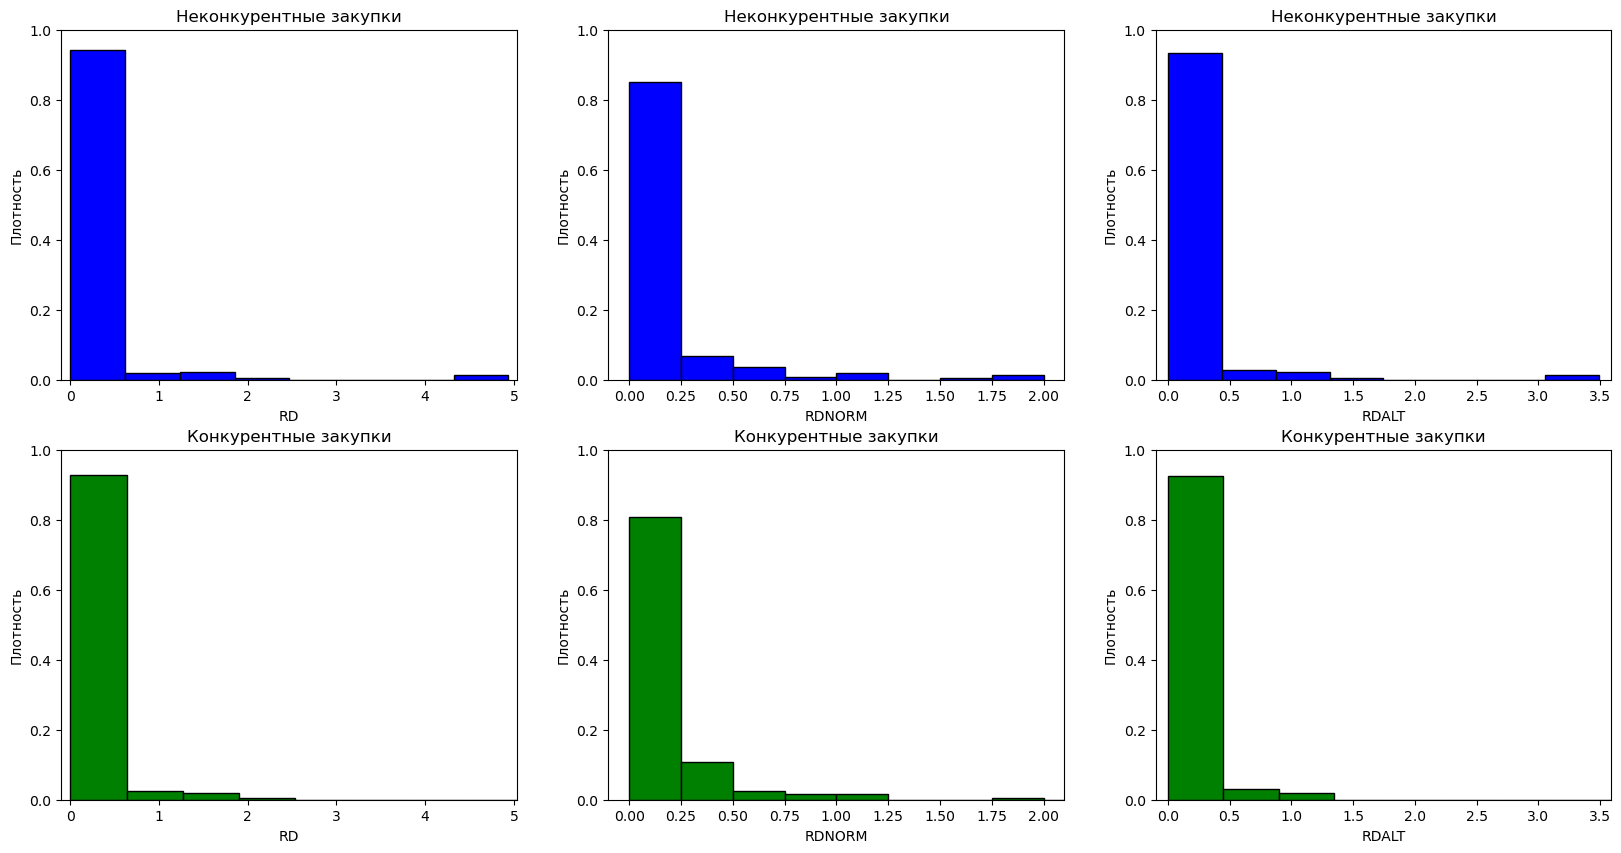

In [190]:
#plt.hist(upd_dF_champ['NMCK'], color = 'blue', edgecolor = 'black', bins = 1 + int(np.log2(len(upd_dF_champ))), weights=np.ones_like (upd_dF_champ['NMCK']) / len (upd_dF_champ['NMCK']))
#plt.hist(upd_mas_dF_champ['NMCK'], color = 'green', edgecolor = 'black', bins = 1 + int(np.log2(len(upd_mas_dF_champ))), weights=np.ones_like (upd_mas_dF_champ['NMCK']) / len (upd_mas_dF_champ['NMCK']))


fig, ((ax1, ax2, ax3), (AX1, AX2, AX3)) = plt.subplots(2,3,figsize=(20, 10))
masic = ["RD", "RDNORM", "RDALT"]
ma1 = (ax1, ax2, ax3)
ma2 = (AX1, AX2, AX3)
diffs = []

for i in range(3):
    ax = ma1[i]
    bins_dF, _, _a = ax.hist(upd_dF_champ[masic[i]], color = 'blue', edgecolor = 'black', bins = 1 + int(np.log2(len(upd_dF_champ))), weights=np.ones_like (upd_dF_champ[masic[i]]) / len (upd_dF_champ[masic[i]]))
    diffs.append(_[1] - _[0])
    ax.set_title("Неконкурентные закупки")
    ax.set_xlabel(masic[i])
    ax.set_ylabel("Плотность")
    ax.set_ylim(0, 1)
    ax.set_xlim(-0.1, max(upd_dF_champ[masic[i]]) + 0.1)

#print(diffs)
    
for i in range(3):
    ax = ma2[i]
    bins_a_dF, _, _a = ax.hist(upd_mas_dF_champ[masic[i]], color = 'green', edgecolor = 'black', bins = int(max(upd_mas_dF_champ[masic[i]])/diffs[i]), weights=np.ones_like (upd_mas_dF_champ[masic[i]]) / len (upd_mas_dF_champ[masic[i]]))
    ax.set_title("Конкурентные закупки")
    ax.set_xlabel(masic[i])
    ax.set_ylabel("Плотность")
    ax.set_ylim(0, 1)
    ax.set_xlim(-0.1, max(upd_dF_champ[masic[i]])+ 0.1)

plt.show()

#sns.distplot(upd_dF_champ['RD'], color = 'blue', hist=False) #, bins = 1 + int(np.log2(len(upd_dF_champ))))

#sns.distplot(upd_mas_dF_champ['RD'], color = 'green', hist=False) #, bins = 1 + int(np.log2(len(upd_mas_dF_champ))))

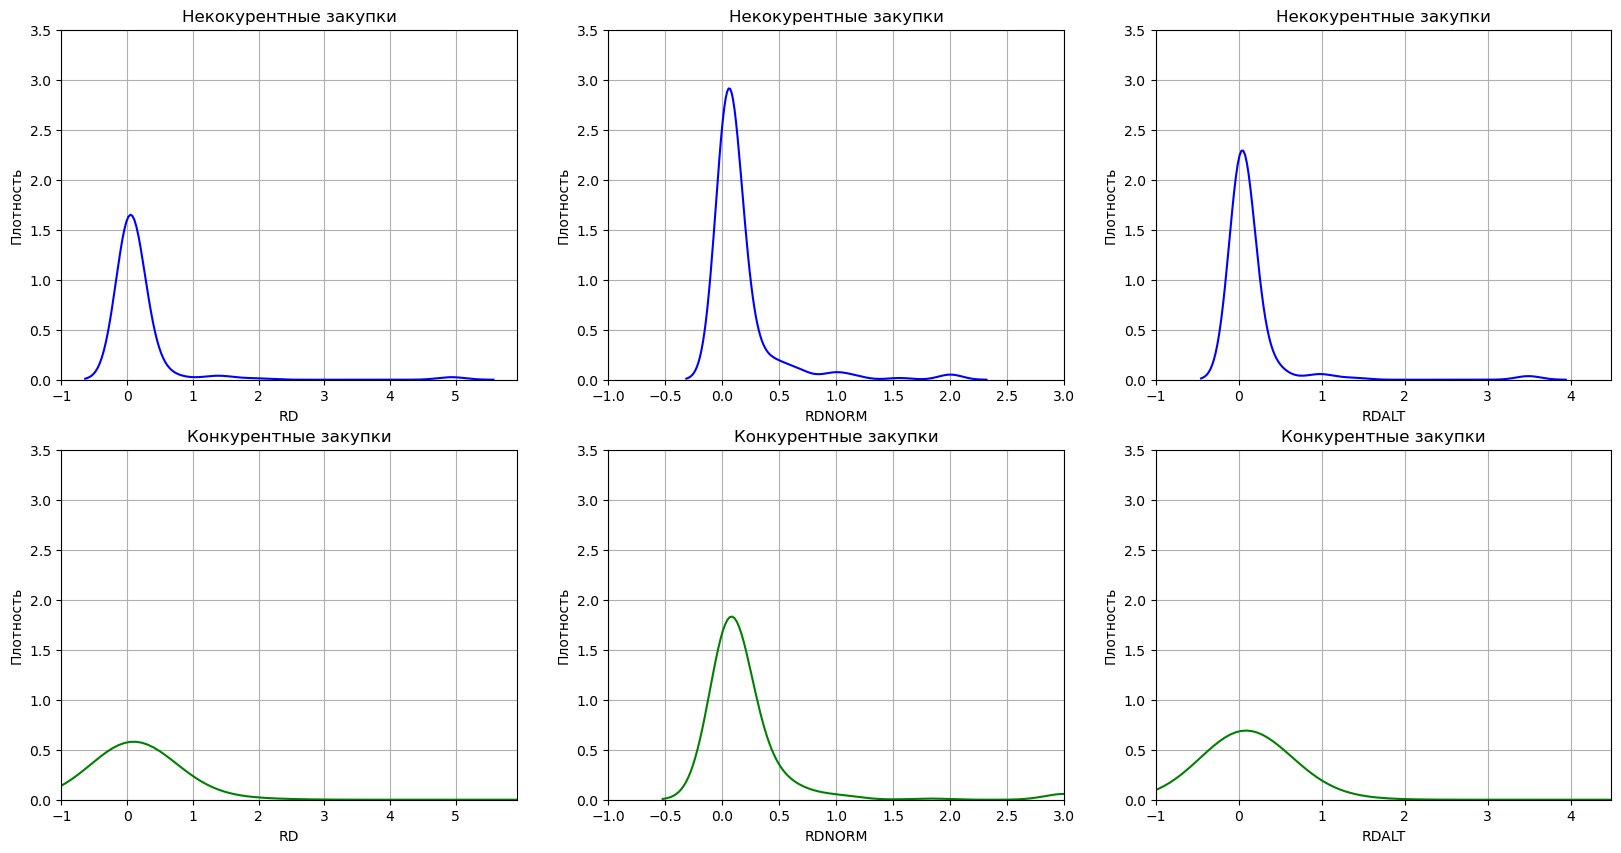

In [191]:
fig, ((ax1, ax2, ax3), (AX1, AX2, AX3)) = plt.subplots(2,3,figsize=(20, 10))
masic = ["RD", "RDNORM", "RDALT"]
ma1 = (ax1, ax2, ax3)
ma2 = (AX1, AX2, AX3)

for i in range(3):
    ax = ma1[i]
    sns.distplot(upd_dF_champ[masic[i]], color = 'blue', hist=False, ax = ax) #, bins = 1 + int(np.log2(len(upd_dF_champ))))
    ax.set_title("Некокурентные закупки")
    ax.set_xlabel(masic[i])
    ax.set_ylabel("Плотность")
    ax.set_ylim(0, 3.5)
    ax.set_xlim(-1, max(upd_dF_champ[masic[i]]) + 1)
    ax.grid(True)

for i in range(3):
    ax = ma2[i]
    sns.distplot(upd_mas_dF_champ[masic[i]], color = 'green', hist=False, ax = ax) #, bins = 1 + int(np.log2(len(upd_dF_champ))))
    ax.set_title("Конкурентные закупки")
    ax.set_xlabel(masic[i])
    ax.set_ylabel("Плотность")
    ax.set_ylim(0, 3.5)
    ax.set_xlim(-1, max(upd_dF_champ[masic[i]]) + 1)
    ax.grid(True)

plt.show()

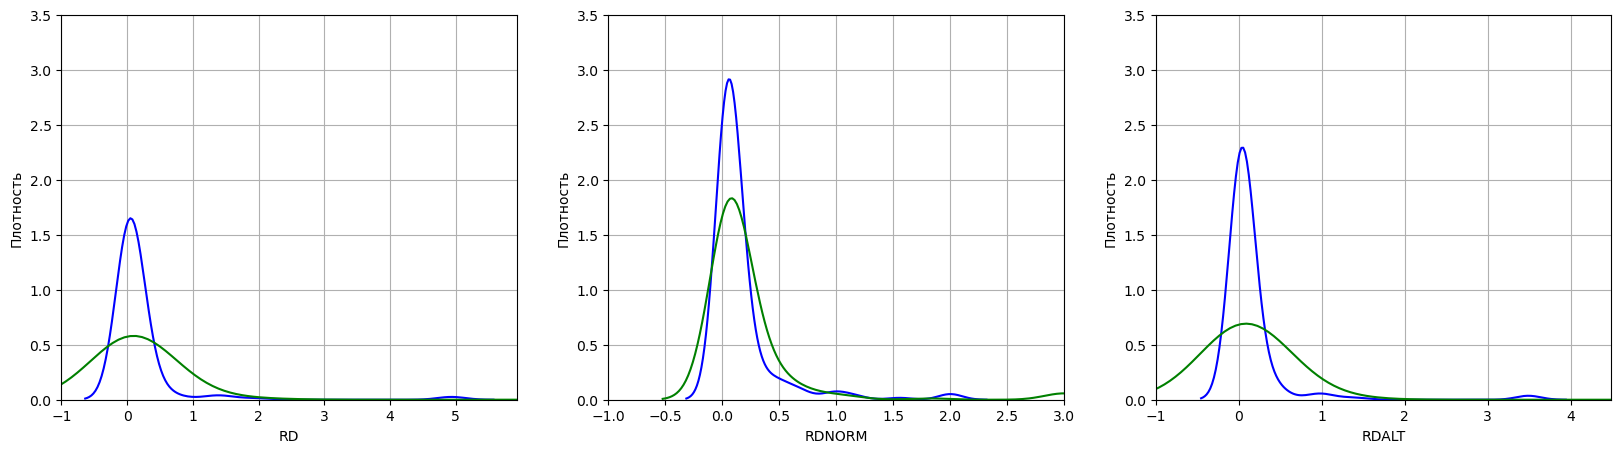

In [192]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20, 5))
masic = ["RD", "RDNORM", "RDALT"]
ma1 = (ax1, ax2, ax3)

for i in range(3):
    ax = ma1[i]
    sns.distplot(upd_dF_champ[masic[i]], color = 'blue', hist=False, ax = ax) #, bins = 1 + int(np.log2(len(upd_dF_champ))))
    sns.distplot(upd_mas_dF_champ[masic[i]], color = 'green', hist=False, ax = ax) #, bins = 1 + int(np.log2(len(upd_dF_champ))))
    ax.set_title("")
    ax.set_xlabel(masic[i])
    ax.set_ylabel("Плотность")
    ax.set_ylim(0, 3.5)
    ax.set_xlim(-1, max(upd_dF_champ[masic[i]]) + 1)
    ax.grid(True)

plt.show()

In [193]:
time = upd_dF_champ["Дата и время начала проведения аукциона"]
time_mas = upd_mas_dF_champ["Дата и время начала проведения аукциона"]
time_frames = [min(time) + pd.Timedelta(hours=i) for i in range(int((max(time_mas) - min(time)).total_seconds()//3600))]

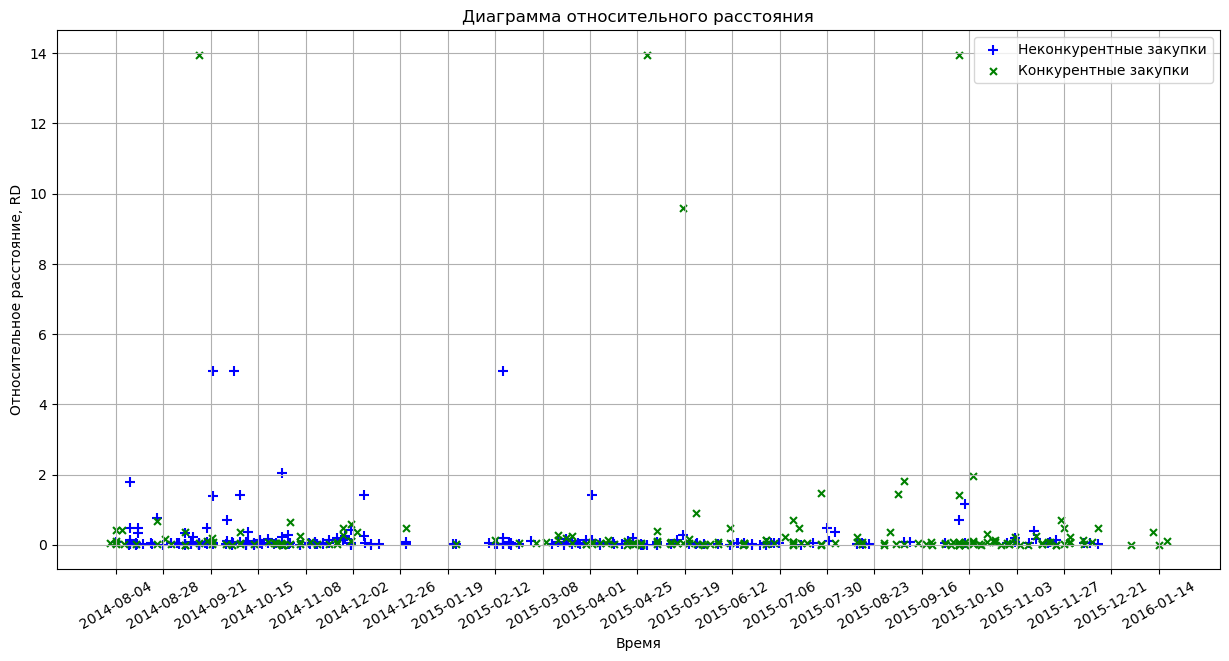

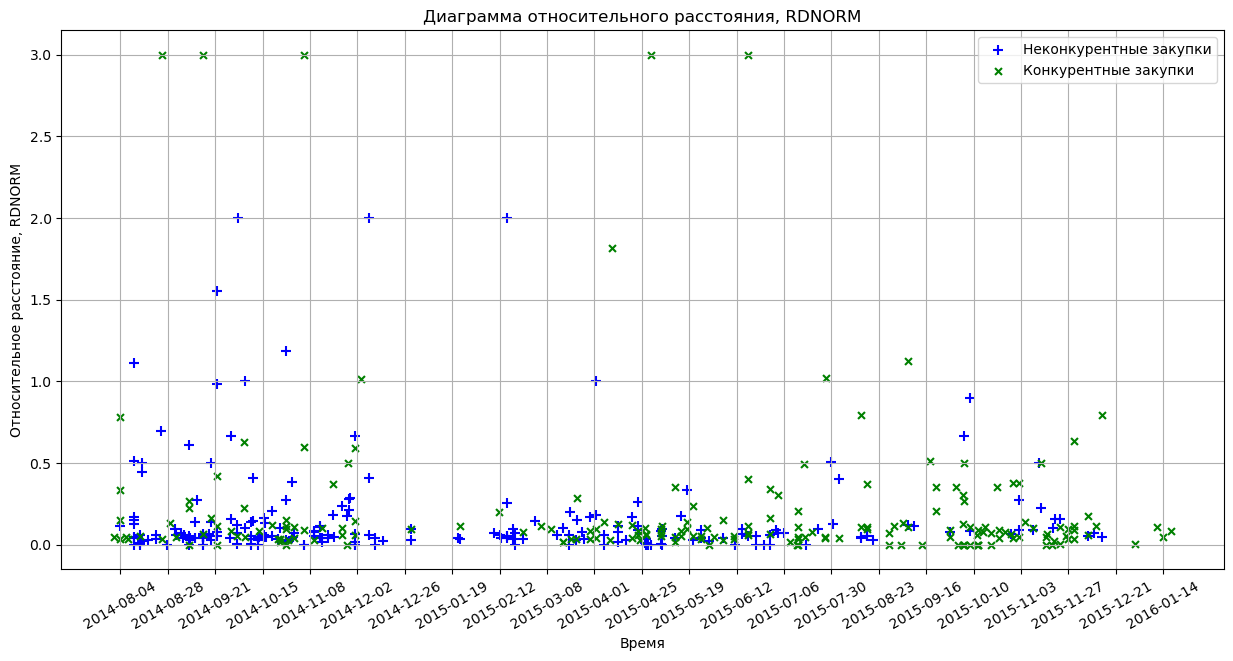

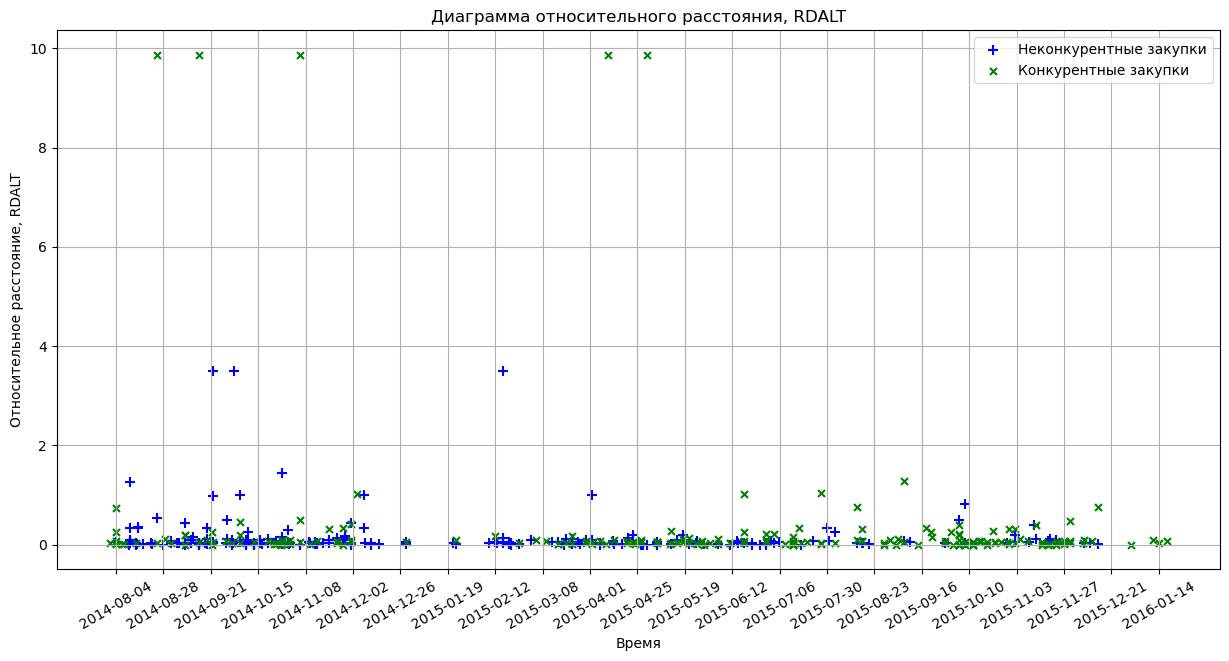

In [479]:
plt.figure(figsize = (15, 7))

plt.scatter(time, upd_dF_champ["RD"], s = 50, color = "blue", marker = "+", label = "Неконкурентные закупки")
plt.scatter(time_mas, upd_mas_dF_champ["RD"], s = 25, color = "green", marker = "x", label = "Конкурентные закупки")
plt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)
plt.title("Диаграмма относительного расстояния")
plt.xlabel("Время")
plt.ylabel("Относительное расстояние, RD")
plt.legend()
plt.grid(True)

plt.show()

plt.figure(figsize = (15, 7))

plt.scatter(time, upd_dF_champ["RDNORM"], s = 50, color = "blue", marker = "+", label = "Неконкурентные закупки")
plt.scatter(time_mas, upd_mas_dF_champ["RDNORM"], s = 25, color = "green", marker = "x", label = "Конкурентные закупки")
plt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)
plt.title("Диаграмма относительного расстояния, RDNORM")
plt.xlabel("Время")
plt.ylabel("Относительное расстояние, RDNORM")
plt.legend()
plt.grid(True)

plt.show()

plt.figure(figsize = (15, 7))

plt.scatter(time, upd_dF_champ["RDALT"], s = 50, color = "blue", marker = "+", label = "Неконкурентные закупки")
plt.scatter(time_mas, upd_mas_dF_champ["RDALT"], s = 25, color = "green", marker = "x", label = "Конкурентные закупки")
plt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)
plt.title("Диаграмма относительного расстояния, RDALT")
plt.xlabel("Время")
plt.ylabel("Относительное расстояние, RDALT")
plt.legend()
plt.grid(True)

plt.show()

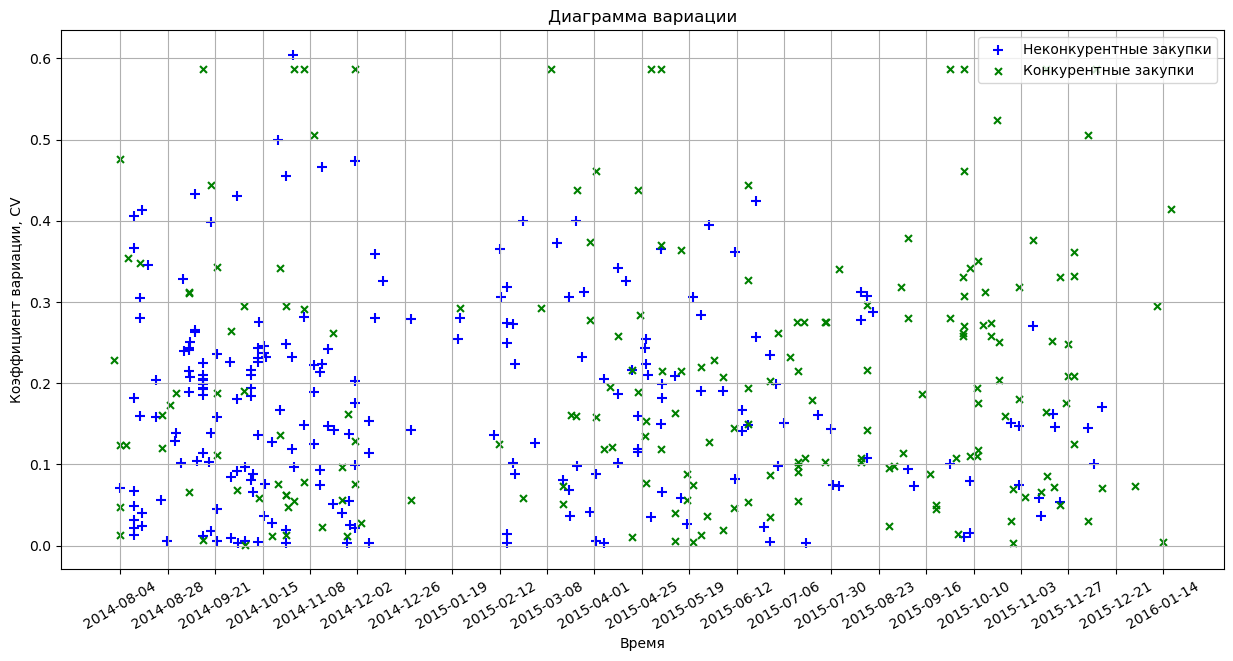

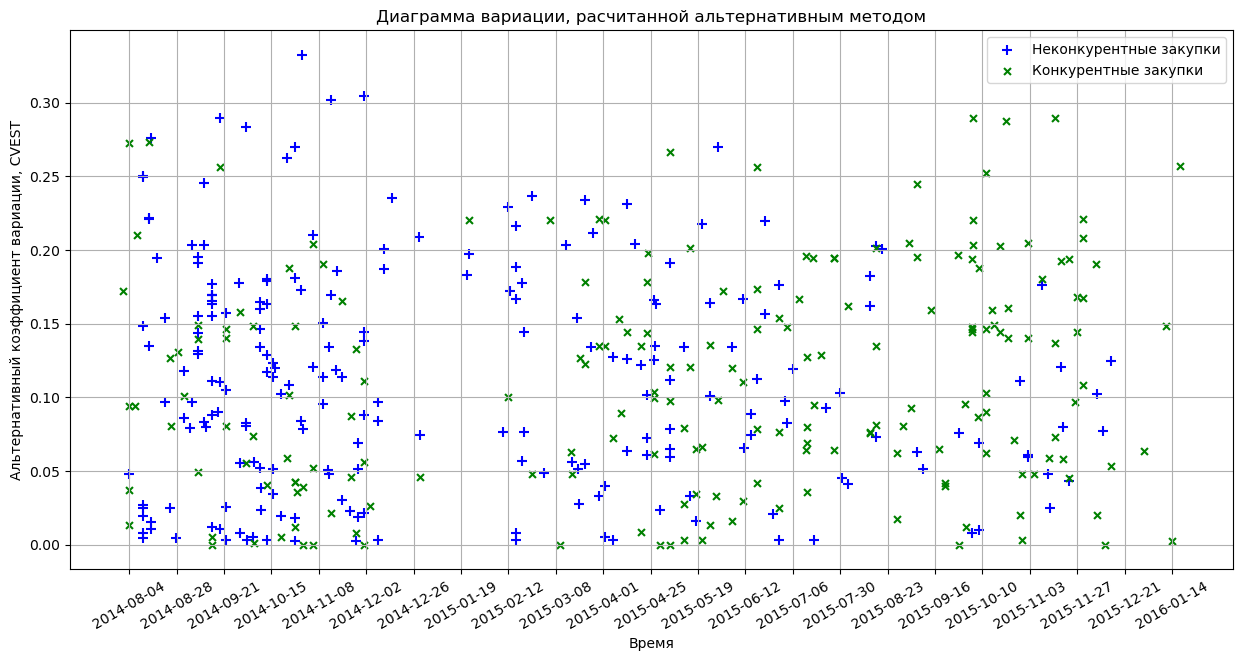

In [542]:
plt.figure(figsize = (15, 7))

plt.scatter(time, upd_dF_champ["CV"], s = 50, color = "blue", marker = "+", label = "Неконкурентные закупки")
plt.scatter(time_mas, upd_mas_dF_champ["CV"], s = 25, color = "green", marker = "x", label = "Конкурентные закупки")
plt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)
plt.title("Диаграмма вариации")
plt.xlabel("Время")
plt.ylabel("Коэффициент вариации, CV")
plt.legend()
plt.grid(True)

plt.show()

plt.figure(figsize = (15, 7))

plt.scatter(time, upd_dF_champ["CVEST"], s = 50, color = "blue", marker = "+", label = "Неконкурентные закупки")
plt.scatter(time_mas, upd_mas_dF_champ["CVEST"], s = 25, color = "green", marker = "x", label = "Конкурентные закупки")
plt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)
plt.title("Диаграмма вариации, расчитанной альтернативным методом")
plt.xlabel("Время")
plt.ylabel("Альтернативный коэффициент вариации, CVEST")
plt.legend()
plt.grid(True)

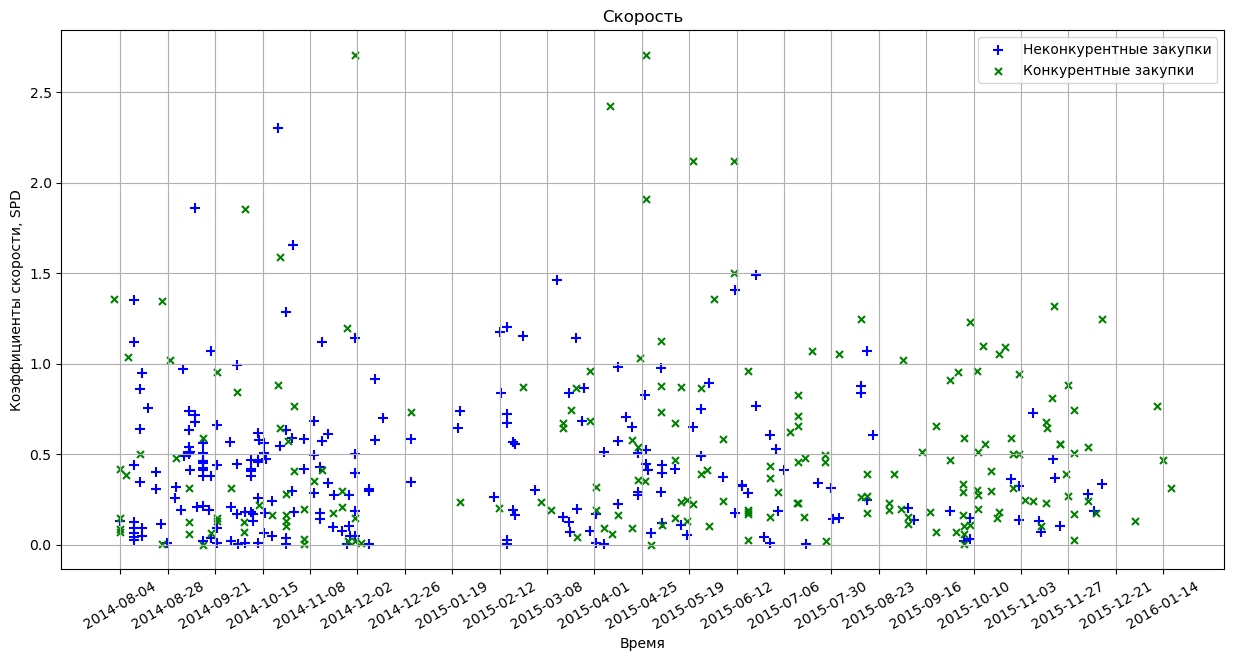

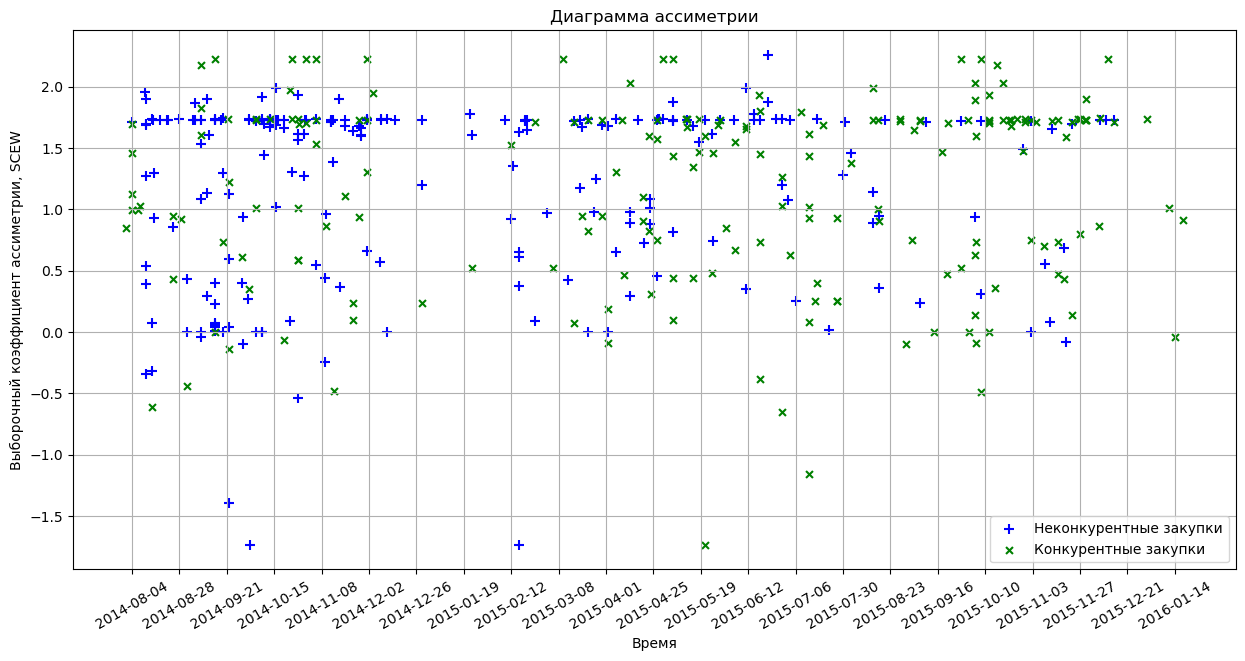

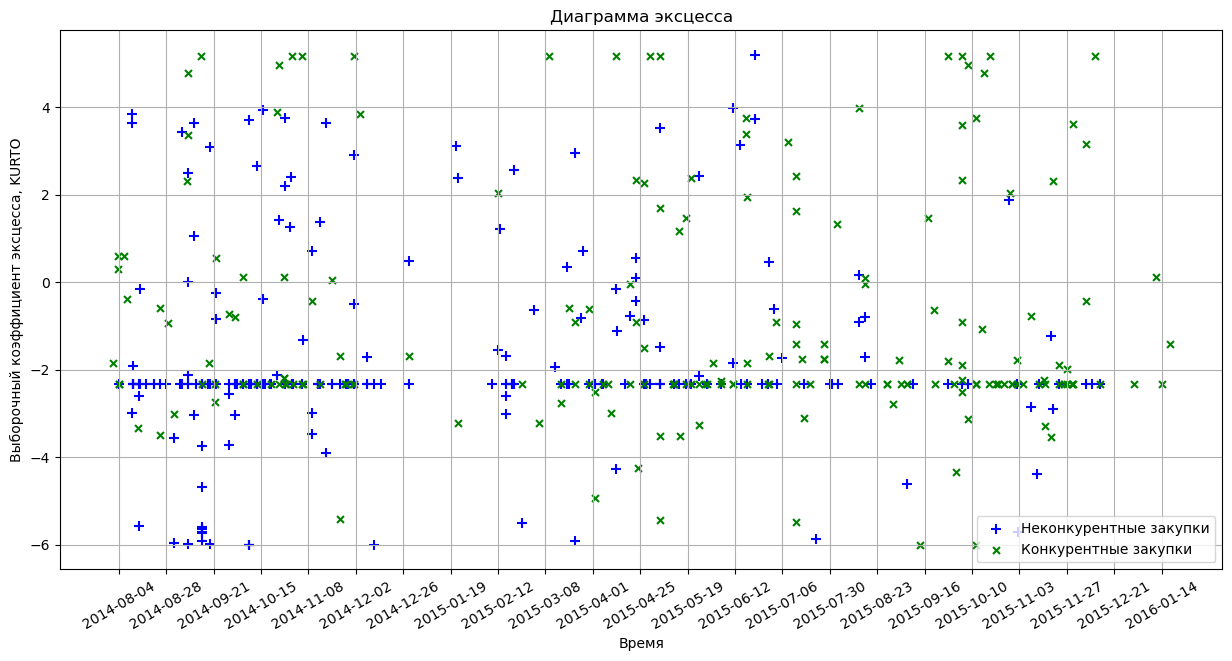

In [543]:

plt.figure(figsize = (15, 7))

plt.scatter(time, upd_dF_champ["SPD"], s = 50, color = "blue", marker = "+", label = "Неконкурентные закупки")
plt.scatter(time_mas, upd_mas_dF_champ["SPD"], s = 25, color = "green", marker = "x", label = "Конкурентные закупки")
plt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)
plt.title("Скорость")
plt.xlabel("Время")
plt.ylabel("Коэффициенты скорости, SPD")
plt.legend()
plt.grid(True)

plt.show()


plt.figure(figsize = (15, 7))

plt.scatter(time, upd_dF_champ["SCEW"], s = 50, color = "blue", marker = "+", label = "Неконкурентные закупки")
plt.scatter(time_mas, upd_mas_dF_champ["SCEW"], s = 25, color = "green", marker = "x", label = "Конкурентные закупки")
plt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)
plt.title("Диаграмма ассиметрии")
plt.xlabel("Время")
plt.ylabel("Выборочный коэффициент ассиметрии, SCEW")
plt.legend()
plt.grid(True)

plt.figure(figsize = (15, 7))

plt.scatter(time, upd_dF_champ["KURTO"], s = 50, color = "blue", marker = "+", label = "Неконкурентные закупки")
plt.scatter(time_mas, upd_mas_dF_champ["KURTO"], s = 25, color = "green", marker = "x", label = "Конкурентные закупки")
plt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)
plt.title("Диаграмма эксцесса")
plt.xlabel("Время")
plt.ylabel("Выборочный коэффициент эксцесса, KURTO")
plt.legend()
plt.grid(True)

In [544]:
dF_ = upd_dF_champ[upd_dF_champ["NBIDERS"] > 3]
DDF = upd_mas_dF_champ[upd_mas_dF_champ["NBIDERS"] > 3]

time_ = list(dF_["Дата и время начала проведения аукциона"])
time_mas_ = DDF["Дата и время начала проведения аукциона"]
time_frames_ = [min(time) + pd.Timedelta(hours=i) for i in range(int((max(time_mas) - min(time)).total_seconds()//3600))]

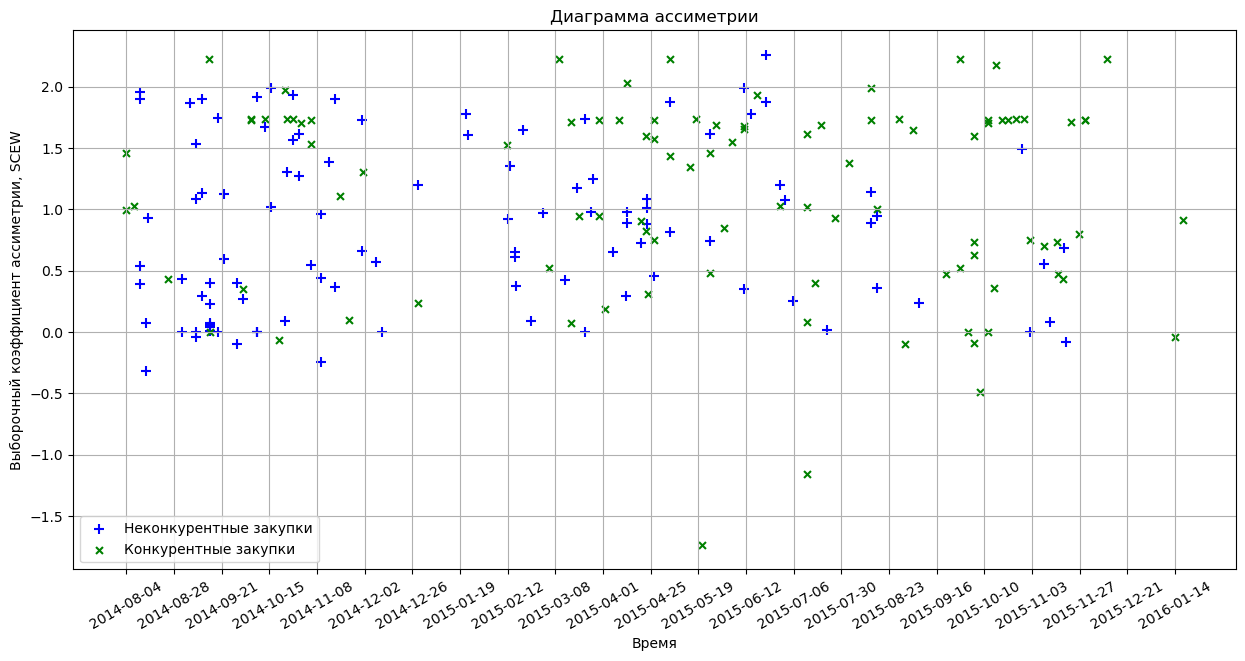

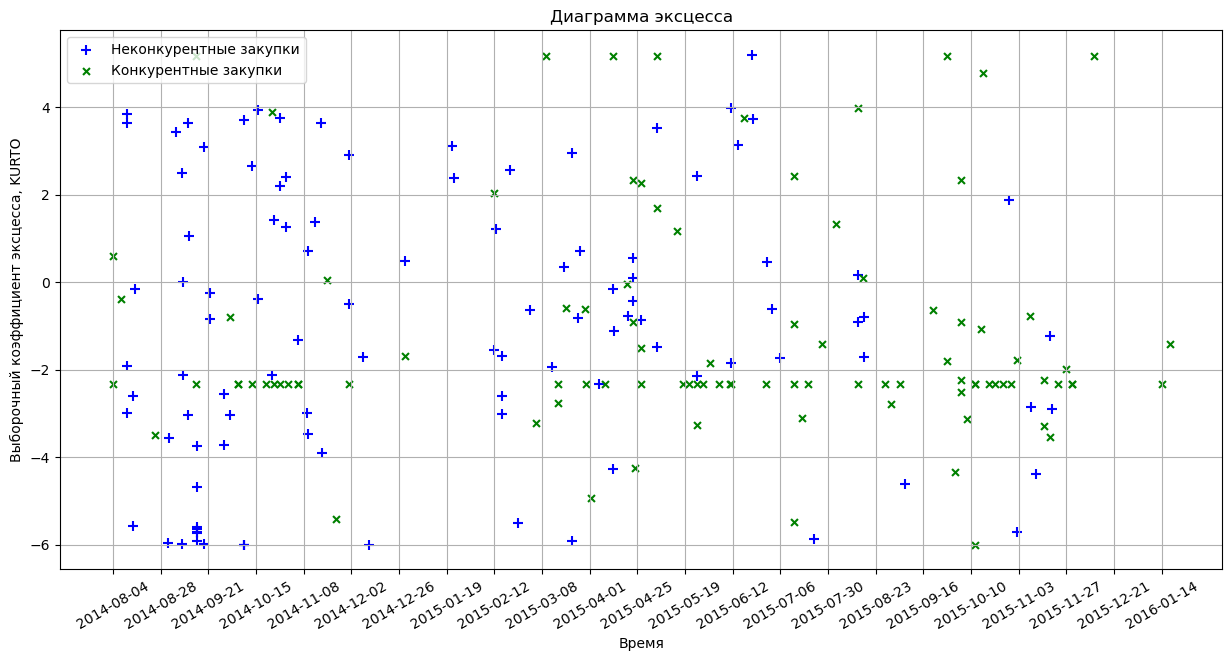

In [545]:
plt.figure(figsize = (15, 7))

plt.scatter(time_, dF_["SCEW"], s = 50, color = "blue", marker = "+", label = "Неконкурентные закупки")
plt.scatter(time_mas_, DDF["SCEW"], s = 25, color = "green", marker = "x", label = "Конкурентные закупки")
plt.xticks([time_frames_[i] for i in range(0, len(time_frames_), 24*24)], rotation = 30)
plt.title("Диаграмма ассиметрии")
plt.xlabel("Время")
plt.ylabel("Выборочный коэффициент ассиметрии, SCEW")
plt.legend()
plt.grid(True)

plt.figure(figsize = (15, 7))

plt.scatter(time_, dF_["KURTO"], s = 50, color = "blue", marker = "+", label = "Неконкурентные закупки")
plt.scatter(time_mas_, DDF["KURTO"], s = 25, color = "green", marker = "x", label = "Конкурентные закупки")
plt.xticks([time_frames_[i] for i in range(0, len(time_frames_), 24*24)], rotation = 30)
plt.title("Диаграмма эксцесса")
plt.xlabel("Время")
plt.ylabel("Выборочный коэффициент эксцесса, KURTO")
plt.legend()
plt.grid(True)

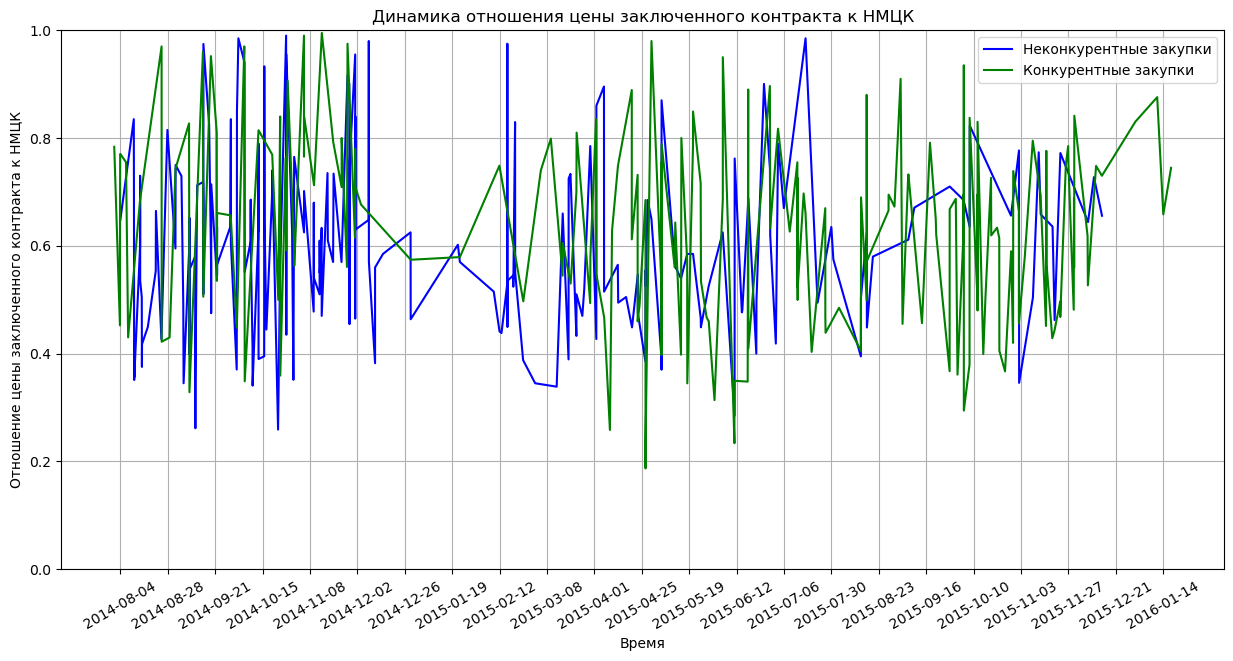

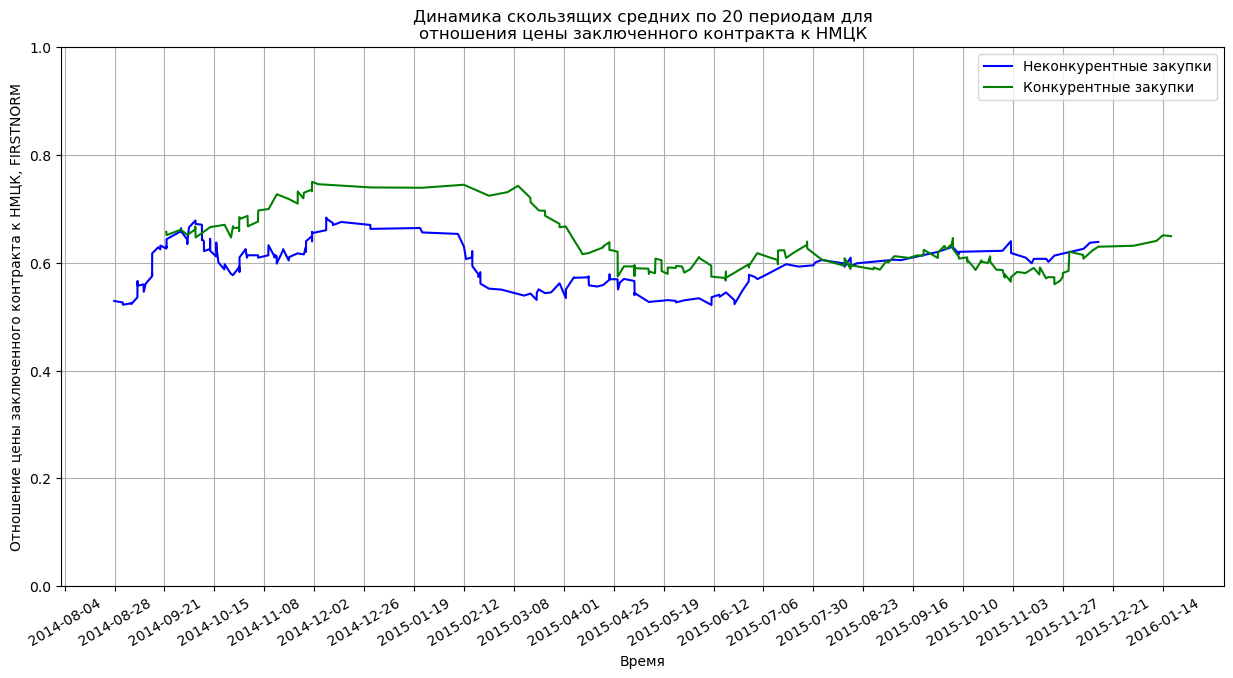

In [546]:
plt.figure(figsize = (15, 7))

plt.plot(to_plot_dF["Дата и время начала проведения аукциона"], to_plot_dF["FIRSTNORM"], color = "blue", label = "Неконкурентные закупки") #, s = 50, marker = "+")
plt.plot(to_plot_mas_dF["Дата и время начала проведения аукциона"], to_plot_mas_dF["FIRSTNORM"], color = "green", label = "Конкурентные закупки") #, s = 25, marker = "*")
plt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)
plt.title("Динамика отношения цены заключенного контракта к НМЦК")
plt.xlabel("Время")
plt.ylabel("Отношение цены заключенного контракта к НМЦК")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

plt.show()

plt.figure(figsize = (15, 7))
n = 20
plt.plot(to_plot_dF["Дата и время начала проведения аукциона"], to_plot_dF["FIRSTNORM"].rolling(window=n).mean(), color = "blue", label = "Неконкурентные закупки") #, s = 50, marker = "+")
plt.plot(to_plot_mas_dF["Дата и время начала проведения аукциона"], to_plot_mas_dF["FIRSTNORM"].rolling(window=n).mean(), color = "green", label = "Конкурентные закупки") #, s = 25, marker = "*")
plt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)
plt.title(f"Динамика скользящих средних по {n} периодам для\nотношения цены заключенного контракта к НМЦК")
plt.xlabel("Время")
plt.ylabel("Отношение цены заключенного контракта к НМЦК, FIRSTNORM")
plt.legend()
plt.ylim(0, 1)
plt.grid(True)

plt.show()

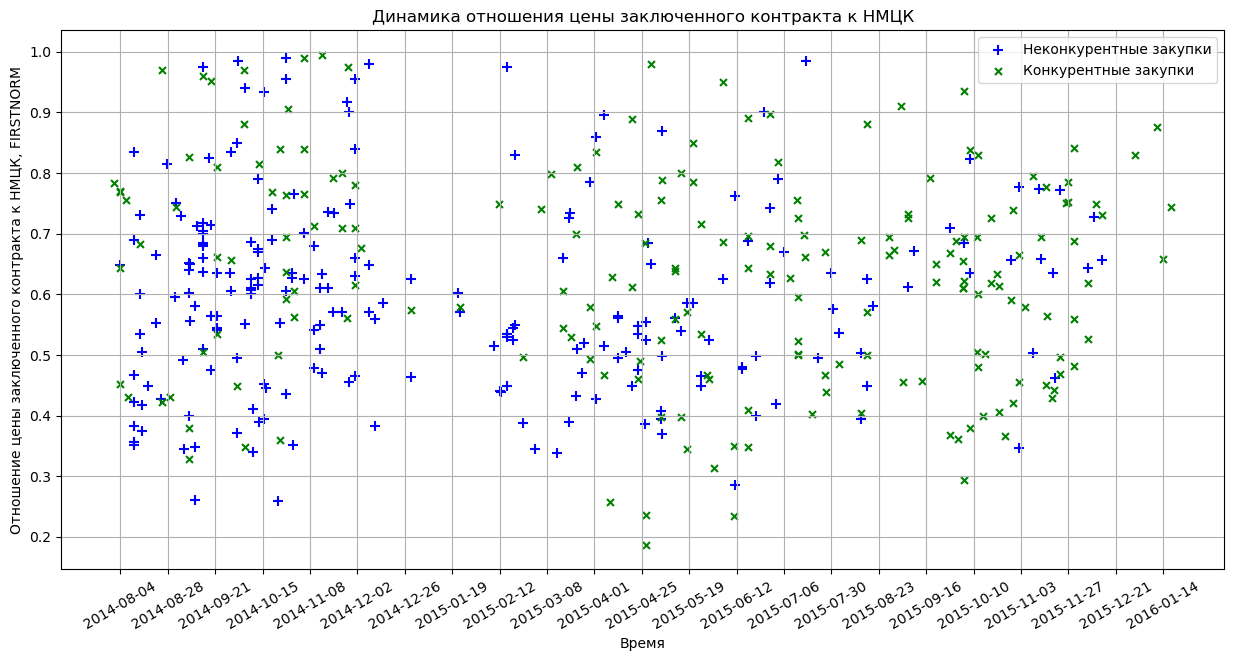

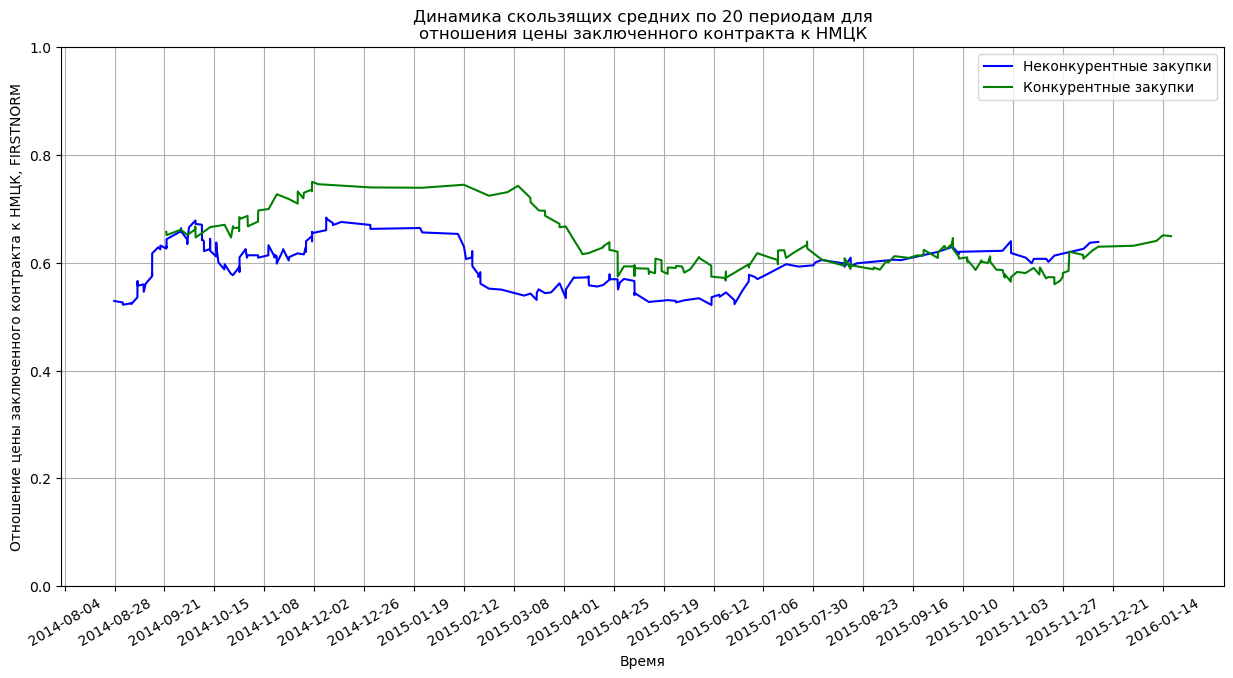

In [570]:
plt.figure(figsize = (15, 7))

plt.scatter(to_plot_dF["Дата и время начала проведения аукциона"], to_plot_dF["FIRSTNORM"], color = "blue", label = "Неконкурентные закупки", s = 50, marker = "+")
plt.scatter(to_plot_mas_dF["Дата и время начала проведения аукциона"], to_plot_mas_dF["FIRSTNORM"], color = "green", label = "Конкурентные закупки", s = 25, marker = "x")
plt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)
plt.title("Динамика отношения цены заключенного контракта к НМЦК")
plt.xlabel("Время")
plt.ylabel("Отношение цены заключенного контракта к НМЦК, FIRSTNORM")
plt.legend()
#plt.ylim(0, 1)
plt.grid(True)

plt.show()

plt.figure(figsize = (15, 7))
n = 20
plt.plot(to_plot_dF["Дата и время начала проведения аукциона"], to_plot_dF["FIRSTNORM"].rolling(window=n).mean(), color = "blue", label = "Неконкурентные закупки") #, s = 50, marker = "+")
plt.plot(to_plot_mas_dF["Дата и время начала проведения аукциона"], to_plot_mas_dF["FIRSTNORM"].rolling(window=n).mean(), color = "green", label = "Конкурентные закупки") #, s = 25, marker = "*")
plt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)
plt.title(f"Динамика скользящих средних по {n} периодам для\nотношения цены заключенного контракта к НМЦК")
plt.xlabel("Время")
plt.ylabel("Отношение цены заключенного контракта к НМЦК, FIRSTNORM")
plt.legend()
plt.ylim(0, 1)
plt.grid(True)

plt.show()

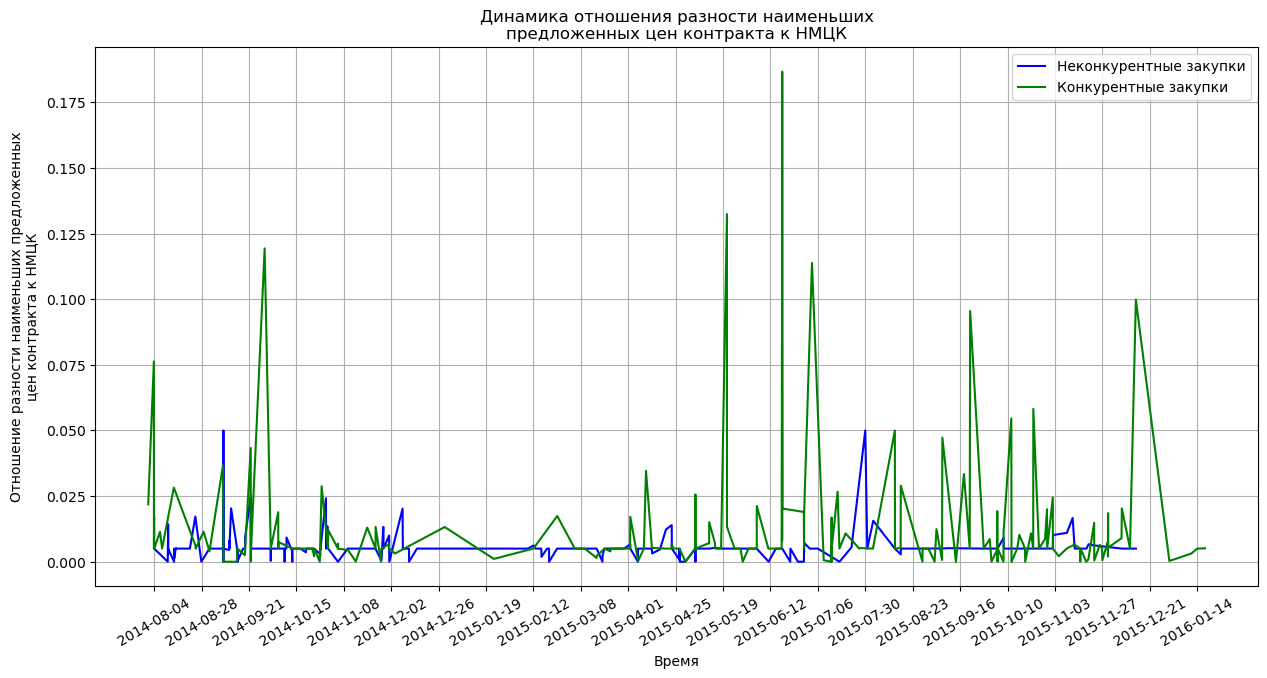

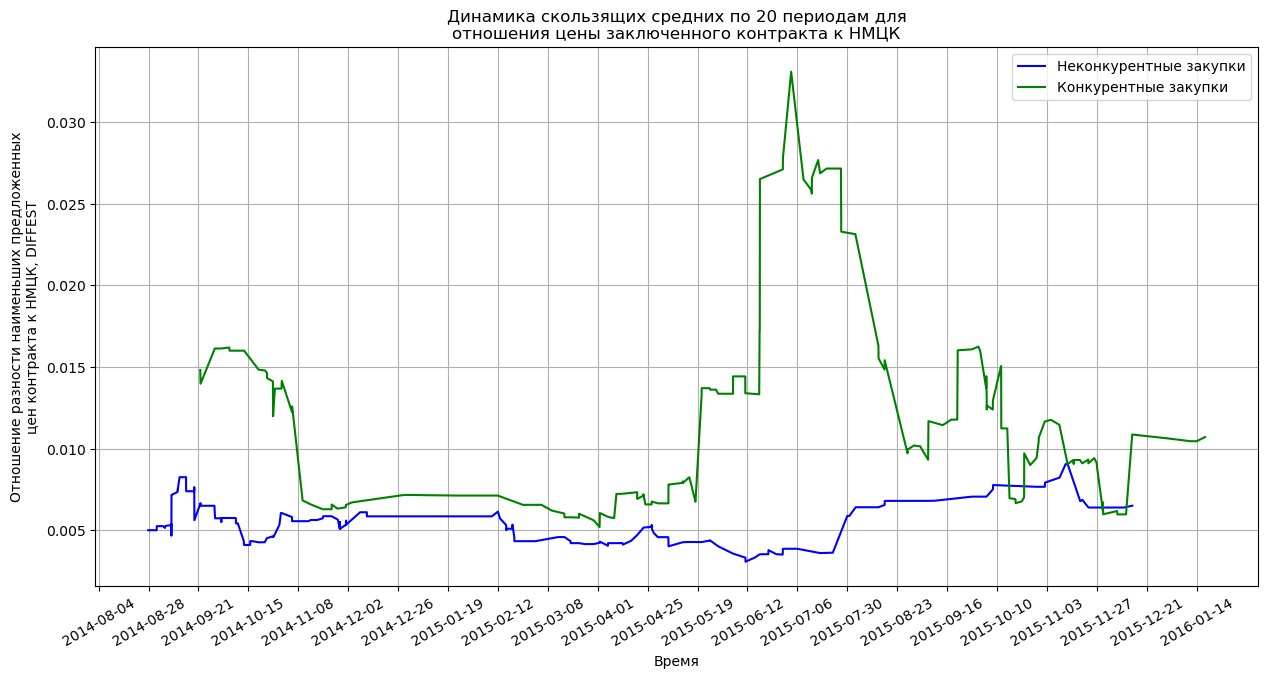

In [547]:
plt.figure(figsize = (15, 7))

#interest = to_plot_dF["Diff_first"]/to_plot_dF["NMCK"]
#interest_1 = to_plot_mas_dF["Diff_first"]/to_plot_mas_dF["NMCK"]
#interest = to_plot_dF["Diff_first"]/to_plot_dF["НМЦК"]
#interest_1 = to_plot_mas_dF["Diff_first"]/to_plot_mas_dF["НМЦК"]

interest = to_plot_dF["DIFFEST"]
interest_1 = to_plot_mas_dF["DIFFEST"]

plt.plot(to_plot_dF["Дата и время начала проведения аукциона"], interest, color = "blue", label = "Неконкурентные закупки") #, s = 50, marker = "+")
plt.plot(to_plot_mas_dF["Дата и время начала проведения аукциона"], interest_1, color = "green", label = "Конкурентные закупки") #, s = 25, marker = "*")
plt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)
plt.title("Динамика отношения разности наименьших\nпредложенных цен контракта к НМЦК")
plt.xlabel("Время")
plt.ylabel("Отношение разности наименьших предложенных\nцен контракта к НМЦК")
plt.legend()
#plt.ylim(0, 1)
plt.grid(True)

plt.show()


plt.figure(figsize = (15, 7))
n = 20
plt.plot(to_plot_dF["Дата и время начала проведения аукциона"], interest.rolling(window=n).mean(), color = "blue", label = "Неконкурентные закупки") #, s = 50, marker = "+")
plt.plot(to_plot_mas_dF["Дата и время начала проведения аукциона"], interest_1.rolling(window=n).mean(), color = "green", label = "Конкурентные закупки") #, s = 25, marker = "*")
plt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)
plt.title(f"Динамика скользящих средних по {n} периодам для\nотношения цены заключенного контракта к НМЦК")
plt.xlabel("Время")
plt.ylabel("Отношение разности наименьших предложенных\nцен контракта к НМЦК, DIFFEST")
plt.legend()
plt.grid(True)

plt.show()

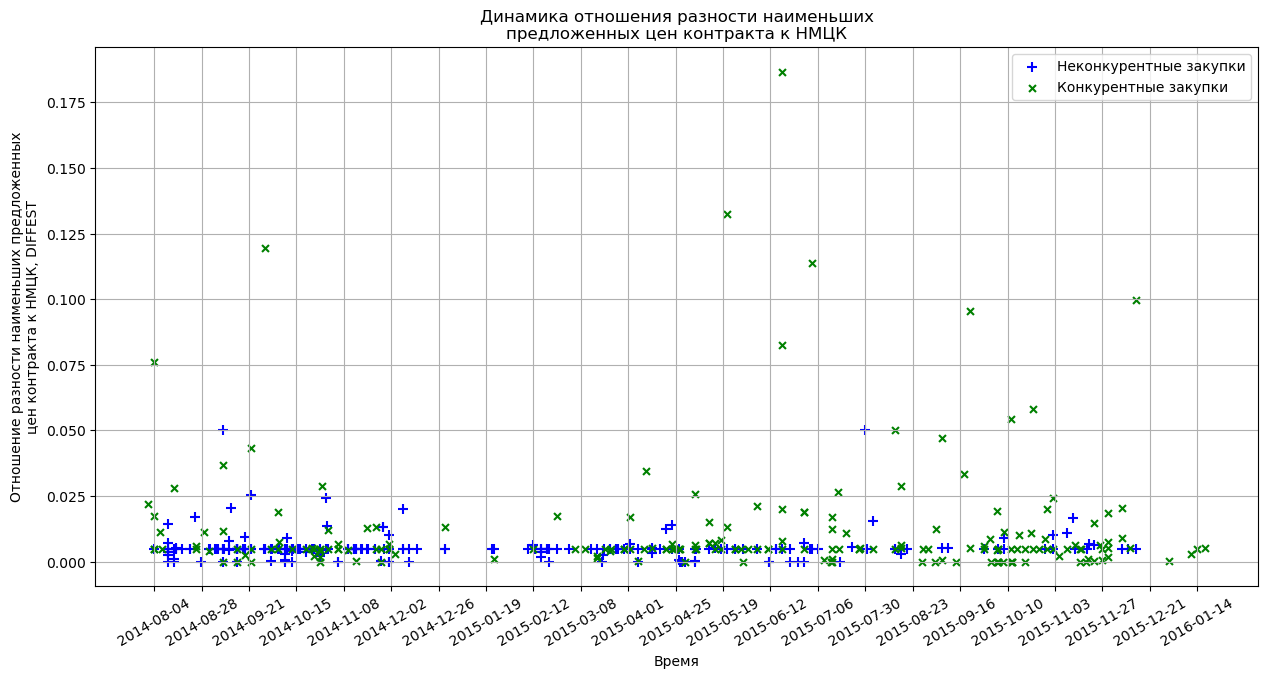

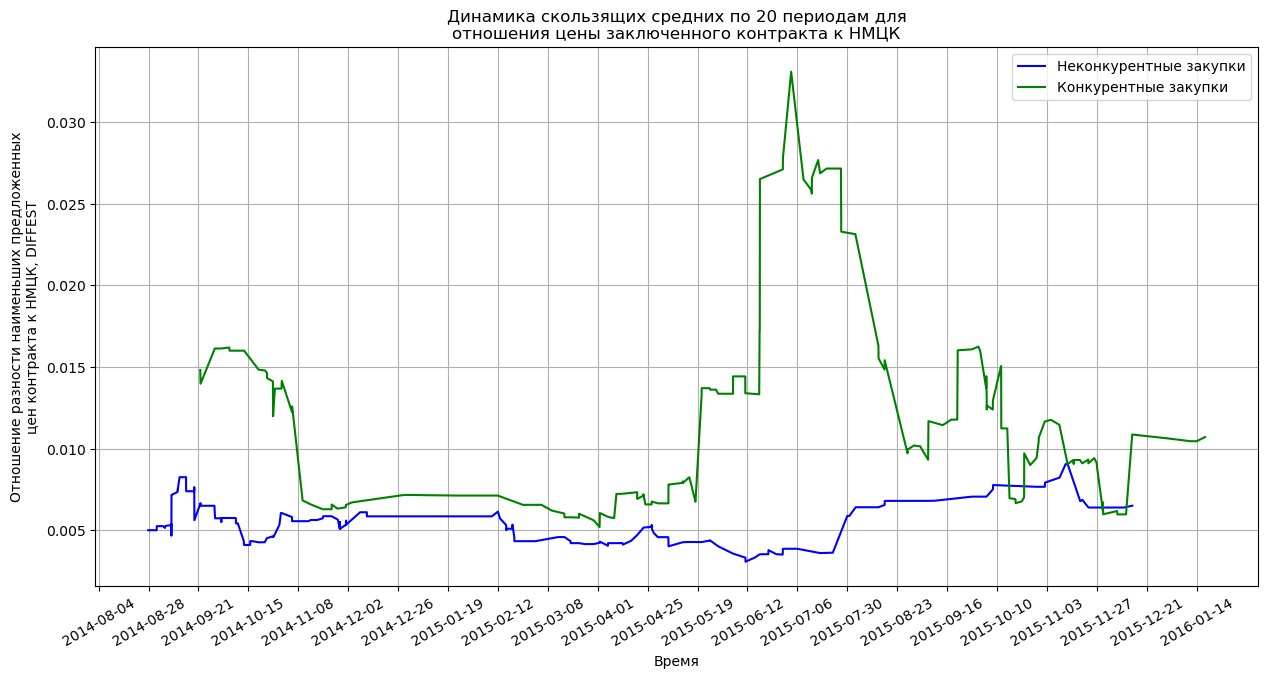

In [571]:
plt.figure(figsize = (15, 7))

#interest = to_plot_dF["Diff_first"]/to_plot_dF["NMCK"]
#interest_1 = to_plot_mas_dF["Diff_first"]/to_plot_mas_dF["NMCK"]
#interest = to_plot_dF["Diff_first"]/to_plot_dF["НМЦК"]
#interest_1 = to_plot_mas_dF["Diff_first"]/to_plot_mas_dF["НМЦК"]

interest = to_plot_dF["DIFFEST"]
interest_1 = to_plot_mas_dF["DIFFEST"]

plt.scatter(to_plot_dF["Дата и время начала проведения аукциона"], interest, color = "blue", label = "Неконкурентные закупки", s = 50, marker = "+")
plt.scatter(to_plot_mas_dF["Дата и время начала проведения аукциона"], interest_1, color = "green", label = "Конкурентные закупки", s = 25, marker = "x")
plt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)
plt.title("Динамика отношения разности наименьших\nпредложенных цен контракта к НМЦК")
plt.xlabel("Время")
plt.ylabel("Отношение разности наименьших предложенных\nцен контракта к НМЦК, DIFFEST")
plt.legend()
plt.grid(True)

plt.show()


plt.figure(figsize = (15, 7))
n = 20
plt.plot(to_plot_dF["Дата и время начала проведения аукциона"], interest.rolling(window=n).mean(), color = "blue", label = "Неконкурентные закупки") #, s = 50, marker = "+")
plt.plot(to_plot_mas_dF["Дата и время начала проведения аукциона"], interest_1.rolling(window=n).mean(), color = "green", label = "Конкурентные закупки") #, s = 25, marker = "*")
plt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)
plt.title(f"Динамика скользящих средних по {n} периодам для\nотношения цены заключенного контракта к НМЦК")
plt.xlabel("Время")
plt.ylabel("Отношение разности наименьших предложенных\nцен контракта к НМЦК, DIFFEST")
plt.legend()
plt.grid(True)

plt.show()

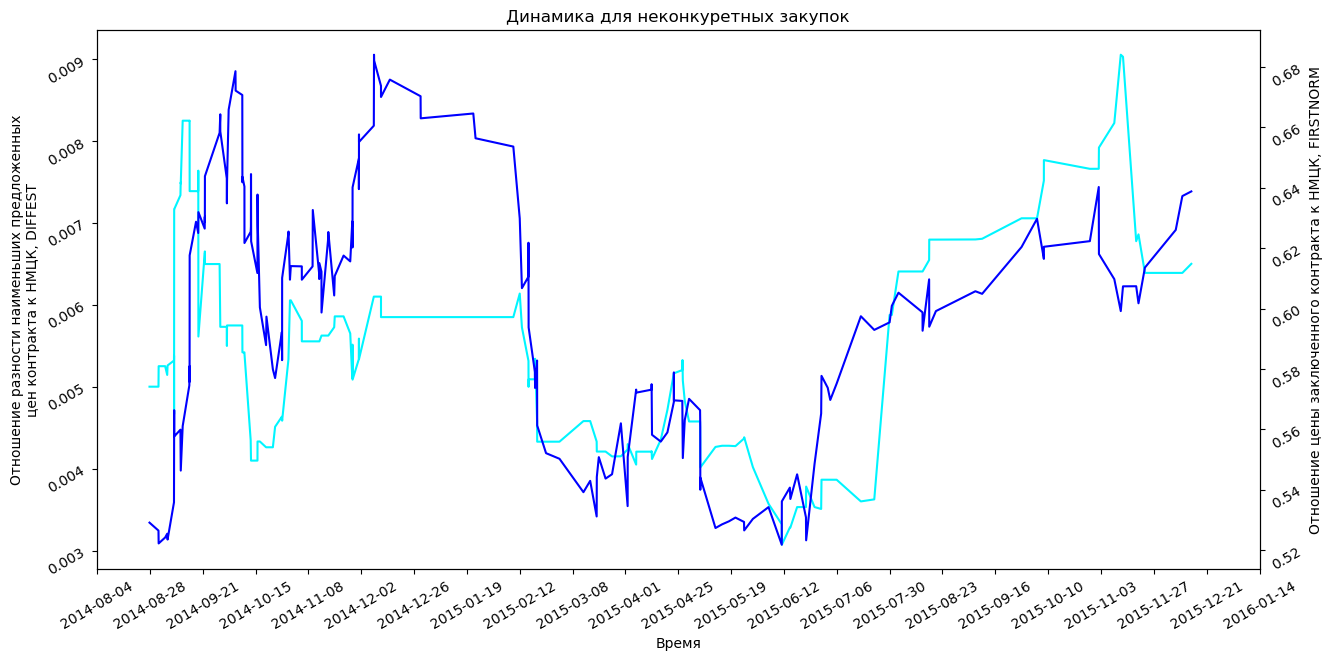

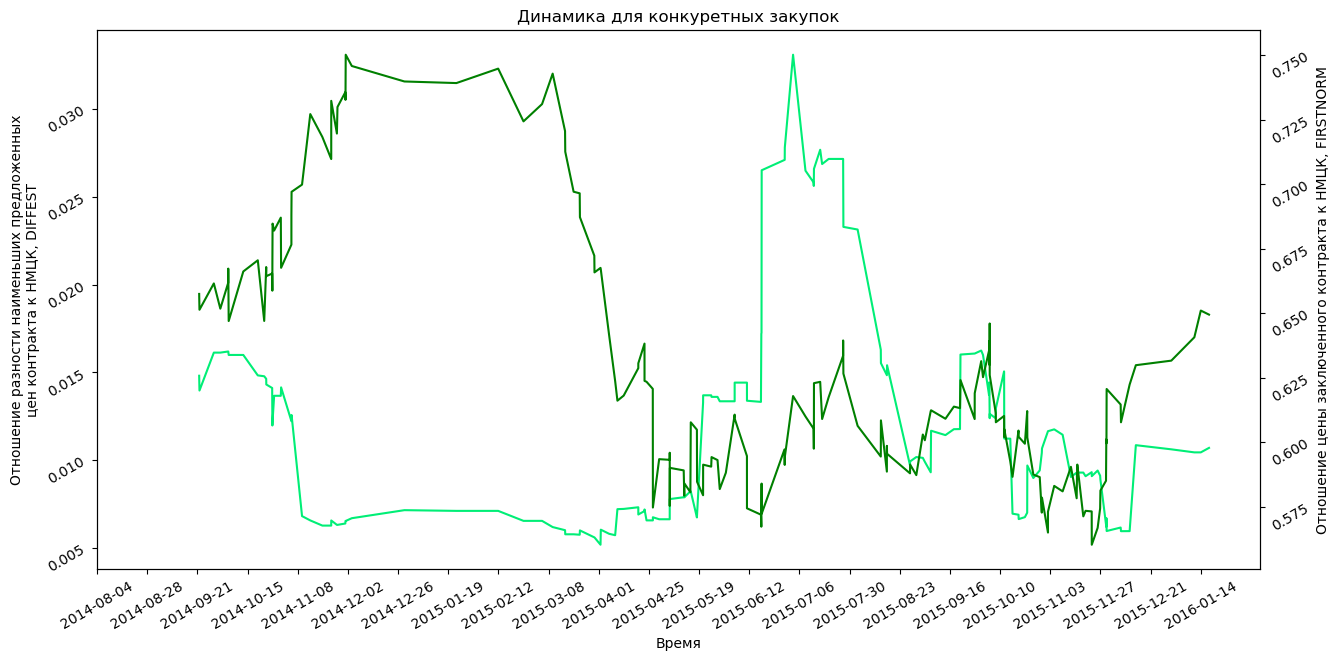

In [575]:
color = "#00F5FF"

fig,ax = plt.subplots(figsize = (15, 7))

n = 20

ax.plot(to_plot_dF["Дата и время начала проведения аукциона"] , interest.rolling(window=n).mean(), color=color)

#add x-axis label
#add y-axis label
ax.set_ylabel("Отношение разности наименьших предложенных\nцен контракта к НМЦК, DIFFEST")
ax.set_title("Динамика для неконкуретных закупок")

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()

n = 20

#add second line to plot
ax2.plot(to_plot_dF["Дата и время начала проведения аукциона"], to_plot_dF["FIRSTNORM"].rolling(window=n).mean(), color="blue")

#add second y-axis label
ax2.set_ylabel("Отношение цены заключенного контракта к НМЦК, FIRSTNORM")
ax.set_xlabel("Время")
ax2.set_xlabel("Время")
ax.set_xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)])
ax.tick_params(rotation = 30)
ax2.set_xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)])
ax2.tick_params(rotation = 30)


plt.show()


color = "#00EE76"

fig,ax = plt.subplots(figsize = (15, 7))

n = 20

ax.plot(to_plot_mas_dF["Дата и время начала проведения аукциона"] , interest_1.rolling(window=n).mean(), color=color)

#add x-axis label
ax.set_xlabel("Время")
ax.set_xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)])
ax.tick_params(rotation = 30)
#add y-axis label
ax.set_ylabel("Отношение разности наименьших предложенных\nцен контракта к НМЦК, DIFFEST")
ax.set_title("Динамика для конкуретных закупок")
#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()

n = 20

#add second line to plot
ax2.plot(to_plot_mas_dF["Дата и время начала проведения аукциона"], to_plot_mas_dF["FIRSTNORM"].rolling(window=n).mean(), color="green")

#add second y-axis label
ax2.set_ylabel("Отношение цены заключенного контракта к НМЦК, FIRSTNORM")
ax.set_xlabel("Время")
ax2.set_xlabel("Время")
ax.set_xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)])
ax.tick_params(rotation = 30)
ax2.set_xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)])
ax2.tick_params(rotation = 30)

plt.show()

(-1.0, 1.0)

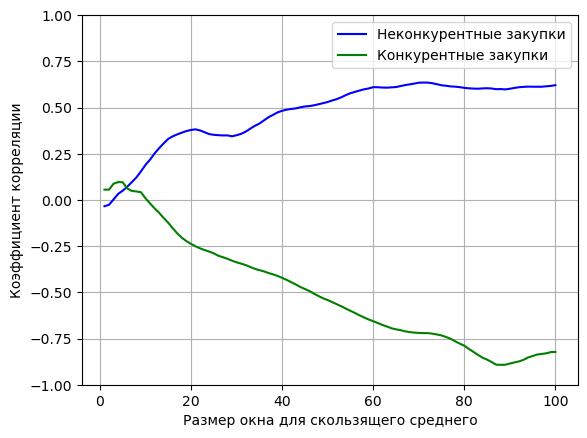

In [580]:
#print(np.corrcoef(interest.rolling(window=n).mean().dropna(), to_plot_dF["NMCK"].rolling(window=n).mean().dropna()))

#print(np.corrcoef(interest, to_plot_dF["NMCK"]))

plt.plot([x for x in range(1, 100 + 1)], [np.corrcoef(interest.rolling(window=x).mean().dropna(), (to_plot_dF["FIRSTNORM"]).rolling(window=x).mean().dropna())[0][1] for x in range(1, 100 + 1)], color = "blue", label = "Неконкурентные закупки")


plt.plot([x for x in range(1, 100 + 1)], [np.corrcoef(interest_1.rolling(window=x).mean().dropna(), (to_plot_mas_dF["FIRSTNORM"]).rolling(window=x).mean().dropna())[0][1] for x in range(1, 100 + 1)], color = "green", label = "Конкурентные закупки")
plt.grid()
plt.xlabel("Размер окна для скользящего среднего")
plt.ylabel("Коэффициент корреляции")
plt.legend()
plt.ylim(-1, 1)

(-1.0, 1.0)

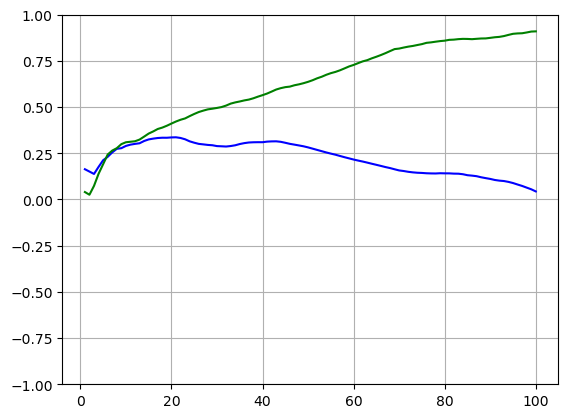

In [201]:
#print(np.corrcoef(interest.rolling(window=n).mean().dropna(), to_plot_dF["NMCK"].rolling(window=n).mean().dropna()))

#print(np.corrcoef(interest, to_plot_dF["NMCK"]))

plt.plot([x for x in range(1, 100 + 1)], [np.corrcoef(to_plot_dF["НМЦК"].rolling(window=x).mean().dropna(),
                                                      to_plot_dF["FIRSTNORM"].rolling(window=x).mean().dropna())[0][1] for x in range(1, 100 + 1)], color = "blue")

#print(np.corrcoef(interest_1.rolling(window=n).mean().dropna(), to_plot_mas_dF["NMCK"].rolling(window=n).mean().dropna()))

#print(np.corrcoef(interest_1, to_plot_mas_dF["NMCK"]))

plt.plot([x for x in range(1, 100 + 1)], [np.corrcoef(to_plot_mas_dF["НМЦК"].rolling(window=x).mean().dropna(),
                                                      to_plot_mas_dF["FIRSTNORM"].rolling(window=x).mean().dropna())[0][1] for x in range(1, 100 + 1)], color = "green")
plt.grid()
plt.ylim(-1, 1)

### Подсчеты интересующих показателей | ВОЗМОЖНА НЕКОРРЕКТНАЯ СПЕЦИФИКАЦИЯ ИЗ-ЗА KURTO

In [202]:
to_rename = {'Предложение о цене контракта': "VALUE"}

ML.rename(columns=to_rename, inplace=True)

In [203]:
list(ML.columns)

['NBIDERS',
 'FIRSTNORM',
 'VALUE',
 'RD',
 'RDNORM',
 'RDALT',
 'SPD',
 'DIFFEST',
 'CV',
 'CVEST',
 'KURTO',
 'SCEW',
 'KS',
 'cartel']

In [204]:
"""
plt.figure(figsize = (15, 7))

plt.scatter(time, ML[ML["cartel"] == 1]["KURTO"], s = 50, color = "blue", marker = "+", label = "Неконкурентные закупки")
plt.scatter(time_mas, ML[ML["cartel"] == 0]["KURTO"], s = 25, color = "green", marker = "*", label = "Конкурентные закупки")
plt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)
plt.title("Диаграмма эксцесса")
plt.xlabel("Время")
plt.ylabel("Выборочный коэффициент эксцесса, KURTO")
plt.legend()
plt.grid(True)
"""

'\nplt.figure(figsize = (15, 7))\n\nplt.scatter(time, ML[ML["cartel"] == 1]["KURTO"], s = 50, color = "blue", marker = "+", label = "Неконкурентные закупки")\nplt.scatter(time_mas, ML[ML["cartel"] == 0]["KURTO"], s = 25, color = "green", marker = "*", label = "Конкурентные закупки")\nplt.xticks([time_frames[i] for i in range(0, len(time_frames), 24*24)], rotation = 30)\nplt.title("Диаграмма эксцесса")\nplt.xlabel("Время")\nplt.ylabel("Выборочный коэффициент эксцесса, KURTO")\nplt.legend()\nplt.grid(True)\n'

In [205]:
col = list(ML.columns)
new = [x for i, x in enumerate(list(ML.columns)) if i!= 1 and i!=7 and i!=9]

X = ML[col[:-1]]
y = ML[col[-1]]

X_orig = ML[new[:-1]]
y_orig = ML[new[-1]]

In [208]:
warnings.simplefilter(action='ignore', category=FutureWarning)

def to_pred(X, y, outline = True):
    X_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3, shuffle = True)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    x_test = sc.transform(x_test)
    kf = KFold(n_splits= 8, shuffle = True)
    models = [
        ('Random Forest', RandomForestClassifier(
            n_estimators=30,
            max_depth=2,
            min_samples_split=3,
            max_leaf_nodes=5,
            class_weight='balanced', 
            random_state=42
        ))
    ]

    param_grids = {
        'Random Forest': {
            'n_estimators': [x for x in range(1, 10)],
            'max_depth': [x for x in range(1, 10)],
            'min_samples_split': [x for x in range(2, 10)],
            'max_leaf_nodes': [x for x in range(2, 10)],
            'class_weight': ['balanced'],
            #'random_state': [42]
        }
    }
    
    for name, model in (models):
    
        #model_search = GridSearchCV(model, param_grids[name],  cv = whole, scoring='precision', verbose=2) # Либо через жадный поиск, либо через случайный
        model_search = RandomizedSearchCV(model, param_grids[name], cv = kf.split(X_train), scoring='precision', n_iter=45, verbose=int(outline))
        model_search.fit(X_train, y_train)

        best_model = model_search.best_estimator_
        best_params = model_search.best_params_
        #print(f"Best Parameters: {best_params}", "\n")

        # Create a new instance of the model with the best hyperparameters
        new_model = type(model)(**best_params)
        if outline:
            print(new_model, "\n")
    
    new_model.fit(X_train, y_train)#WRITE HERE#

    score = new_model.score(x_test, y_test)
    if outline:
        print("Score metrics:", score, "\n")
    
    y_pred = new_model.predict(x_test)
    #y_pred_proba = clf.predict_proba(x_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    #recall = recall_score(y_test, y_pred)
    #f1 = f1_score(y_test, y_pred)
    #rocauc = roc_auc_score(y_test, y_pred_proba)
    conf_mat = confusion_matrix(y_test, y_pred)
    #fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    #print(accuracy, precision, conf_mat, sep ="\n\n")
    if outline:
        print("Accuracy_score metrics:", accuracy, "\n")
        print("Precision metrics:", precision, "\n")
        print("Confusion matrix:", "\n", pd.DataFrame(conf_mat))
    
    if not outline:
        return [new_model, score, accuracy, precision, conf_mat]

In [209]:
prec = []
model = []

for i in tqdm(range(100)):
    res = to_pred(X, y, outline = False)
    prec.append((i, res[-2]))
    model.append(res[0])

prec = sorted(prec, key = lambda x: -x[1])

prec_orig = []
model_orig = []

for i in tqdm(range(100)):
    res = to_pred(X_orig, y_orig, outline = False)
    prec_orig.append((i, res[-2]))
    model_orig.append(res[0])

prec_orig = sorted(prec_orig, key = lambda x: -x[1])

model[prec[0][0]], model_orig[prec_orig[0][0]]

100%|██████████| 100/100 [05:43<00:00,  3.43s/it]


(RandomForestClassifier(class_weight='balanced', max_depth=9, max_leaf_nodes=9,
                        min_samples_split=6, n_estimators=6),
 RandomForestClassifier(class_weight='balanced', max_depth=4, max_leaf_nodes=9,
                        min_samples_split=4, n_estimators=9))

In [255]:
import math as m

def table(dlina, mas, to_write):
    AA = " "*len(to_write)
    a0 = AA + " "*3 + " "*(m.ceil((dlina - 1)/2)) + "0" + " "*(m.floor((dlina - 1)/2)) + " " + " "*(m.ceil((dlina - 1)/2)) + "1" + " "*(m.floor((dlina - 1)/2)) + " "
    a1 = AA + "  +" + "-"*(m.ceil((dlina - 1)/2)) + "-" + "-"*(m.floor((dlina - 1)/2)) + "+" + "-"*(m.ceil((dlina - 1)/2)) + "-" + "-"*(m.floor((dlina - 1)/2)) + "+"
    a2 = AA + "0 |" + mas[0] + "|" + mas[1] + "|"
    a3 = AA + "1 |" + mas[2] + "|" + mas[3] + "|"
    a1_to = to_write + "  +" + "-"*(m.ceil((dlina - 1)/2)) + "-" + "-"*(m.floor((dlina - 1)/2)) + "+" + "-"*(m.ceil((dlina - 1)/2)) + "-" + "-"*(m.floor((dlina - 1)/2)) + "+"
    return ("\n".join([a0, a1, a2, a1_to, a3, a1]))
    

def good_looking(co, in_total):
    mas = []
    for i in co:
        for j in i:
            if in_total:
                mas.append("%.2f" % (round(j/np.sum(co), 3)))
            else:
                mas.append(str(j))
    maxing = max(max([len(j) for j in mas]), 2) + 1
    mas = [" "*(maxing - len(j)) + j for j in mas]
    return table(maxing, mas, "")

In [312]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def decision_plot(m0, m1, flag = False, data = [], in_total = False):
    if data == []:
        X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)
        X_train1, x_test1, y_train1, y_test1 = train_test_split(X_orig, y_orig, test_size = 0.3, shuffle = True)
    else:
        X_train, x_test, y_train, y_test = data[0]
        X_train1, x_test1, y_train1, y_test1 = data[1]
    
    m0.fit(X_train, y_train)

    feature_importances0 = m0.feature_importances_
    if data == []:
        feature_names0 = list(X.columns)
    else:
        feature_names0 = [f"{i + 1}" for i in range(len(X_train[0]))]
    
    co = confusion_matrix(y_test, m0.predict(x_test))
    
    m1.fit(X_train1, y_train1)
    feature_importances1 = m1.feature_importances_
    if data == []:
        feature_names1 = list(X_orig.columns)
    else:
        feature_names1 = [f"{i + 1}" for i in range(len(X_train1[0]))]
    
    co1 = confusion_matrix(y_test1, m1.predict(x_test1))
    
    if data == []:
        feature_importances1 = list(feature_importances1[:1]) + [0] + list(feature_importances1[1:6]) + [0] + list(feature_importances1[6:7]) + [0] + list(feature_importances1[7:])
    else:
        feature_importances1 = list(feature_importances1) + [0]*(len(X_train[0]) - len(X_train1[0]))
        #print(feature_importances0, feature_importances1, len(feature_importances0) == len(feature_importances1))
    

    plt.figure(figsize = (15, 7))
    
    if data == []:
        N = len(list(X.columns))
    else:
        N = len(X_train[0])
    ind = np.arange(N) 
    width = 0.25


    bar2 = plt.bar(ind, feature_importances1, width, color='g') 
    bar1 = plt.bar(ind+width, feature_importances0, width, color = 'b') 

    plt.xlabel("Показатели") 
    plt.ylabel('Значимость') 
    plt.title("Различия в спецификации обученных моделей") 

    plt.xticks(ind+width/2,feature_names0) 
    if flag:
        plt.legend( (bar2, bar1), ('Модель из статьи' + "\n" + good_looking(co1, in_total), 'Модель с факторами\nс НМЦК' + "\n" + good_looking(co, in_total)) )
        plt.tight_layout()
    else:
        plt.legend( (bar2, bar1), ('Модель из статьи', 'Модель с факторами с НМЦК') )
    plt.grid(alpha = 0.25)
    plt.show()
    
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Модель с факторами с НМЦК', 'Модель из статьи'])
    #print(co, co1)
    models = [('Модель с факторами с НМЦК', m0), ('Модель из статьи', m1)]
    #result = {'Модель с факторами с НМЦК' : [co], 'Модель из статьи': [co1]}
    
    for i in range(1):
        if in_total:
            coco, coco1 = (np.array(co)/np.sum(co)), (np.array(co1)/np.sum(co1))
            co = []
            co1 = []
            for k in coco:
                co.append(["%.2f" % round(x, 2) for x in k])
            for k in coco1:
                co1.append(["%.2f" % round(x, 2) for x in k])
            conf_mats = [np.array(co), np.array(co1)]
            #print(conf_mats)
            #print("!")
        else:
            conf_mats = [co, co1]
        for j, conf_mat in enumerate(conf_mats):
            fig.add_trace(go.Heatmap(
                z=conf_mat,
                colorscale='Earth',
                showscale=False,
                hoverinfo='z'
            ), row=i+1, col=j+1)

            fig.update_xaxes(tickvals=[0, 1], ticktext=["0", "1"], row=i+1, col=j+1)
            fig.update_yaxes(tickvals=[0, 1], ticktext=["1", "0"], row=i+1, col=j+1)

            fig.add_annotation(
                text=f"TP: {conf_mat[1,1]}",
                x=0.95,
                y=0.05,
                xref="paper",
                yref="paper",
                showarrow=False,
                font=dict(
                    size=14,
                    color="black",
                    family="Arial"
                ),
                row=i+1,
                col=j+1
            )

            fig.add_annotation(
                text=f"FN: {conf_mat[1,0]}",
                x=0.95,
                y=0.95,
                xref="paper",
                yref="paper",
                showarrow=False,
                font=dict(
                    size=14,
                    color="black",
                    family="Arial"
                ),
                row=i+1,
                col=j+1
            )

            fig.add_annotation(
                text=f"TN: {conf_mat[0,0]}",
                x=0.05,
                y=0.95,
                xref="paper",
                yref="paper",
                showarrow=False,
                font=dict(
                    size=14,
                    color="black",
                    family="Arial"
                ),
                row=i+1,
                col=j+1
            )

            fig.add_annotation(
                text=f"FP: {conf_mat[0,1]}",
                x=0.05,
                y=0.05,
                xref="paper",
                yref="paper",
                showarrow=False,
                font=dict(
                    size=14,
                    color="black",
                    family="Arial"
                ),
                row=i+1,
                col=j+1
            )

    fig.update_layout(title='Матрицы ошибок моделей',
                       width=800,  
                       height=300,
                       autosize=True)

    # Add axis labels
    for i in range(1):
        for j in range(2):
            fig.update_xaxes(title_text="Предсказанный класс", row=i+1, col=j+1)
            fig.update_yaxes(title_text="Истинный класс", row=i+1, col=j+1)

    # Show the figure
    fig.show()

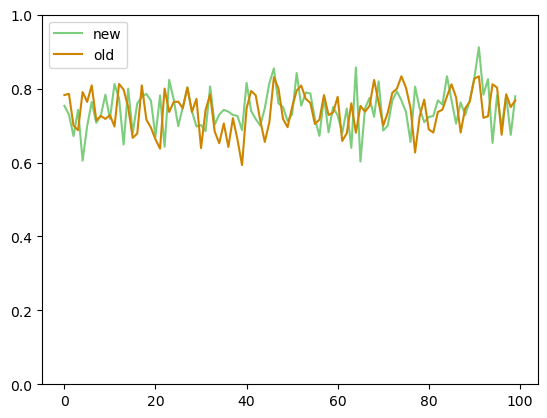

In [313]:
m0 = model[prec[0][0]]
m1 = model_orig[prec_orig[0][0]]

"""
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)
X_train1, x_test1, y_train1, y_test1 = train_test_split(X_orig, y_orig, test_size = 0.3, shuffle = True)

m0.fit(X_train, y_train)
m1.fit(X_train1, y_train1)

Precision = [precision_score(y_test, m0.predict(x_test)) for x in sorted(prec, key = lambda x: x[0])]
Precision_orig = [precision_score(y_test1, m1.predict(x_test1)) for x in sorted(prec, key = lambda x: x[0])]
"""
Precision, Precision_orig = [], []
for i in range(100):
    X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)
    X_train1, x_test1, y_train1, y_test1 = train_test_split(X_orig, y_orig, test_size = 0.3, shuffle = True)

    m0.fit(X_train, y_train)
    
    Precision.append(precision_score(y_test, m0.predict(x_test)) )
    
    m1.fit(X_train1, y_train1)

    Precision_orig.append(precision_score(y_test1, m1.predict(x_test1)) )

t = [x[0] for x in sorted(prec, key = lambda x: x[0])]

plt.plot(t, Precision, color = "#7CCD7C", label = "new")
plt.plot(t, Precision_orig, color = "#CD8500", label = "old")
plt.legend()
plt.ylim(0, 1)
plt.show()

In [314]:
from scipy import stats

In [315]:
stats.ttest_rel(Precision, Precision_orig)

TtestResult(statistic=0.4074896147553139, pvalue=0.6845282242151511, df=99)

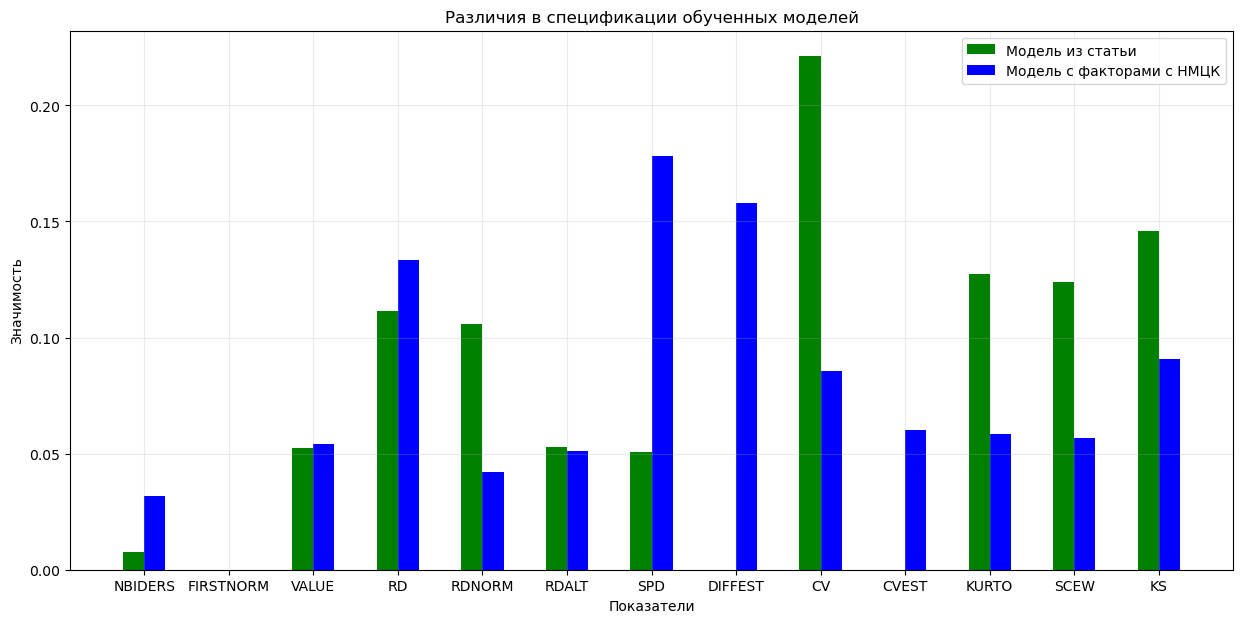

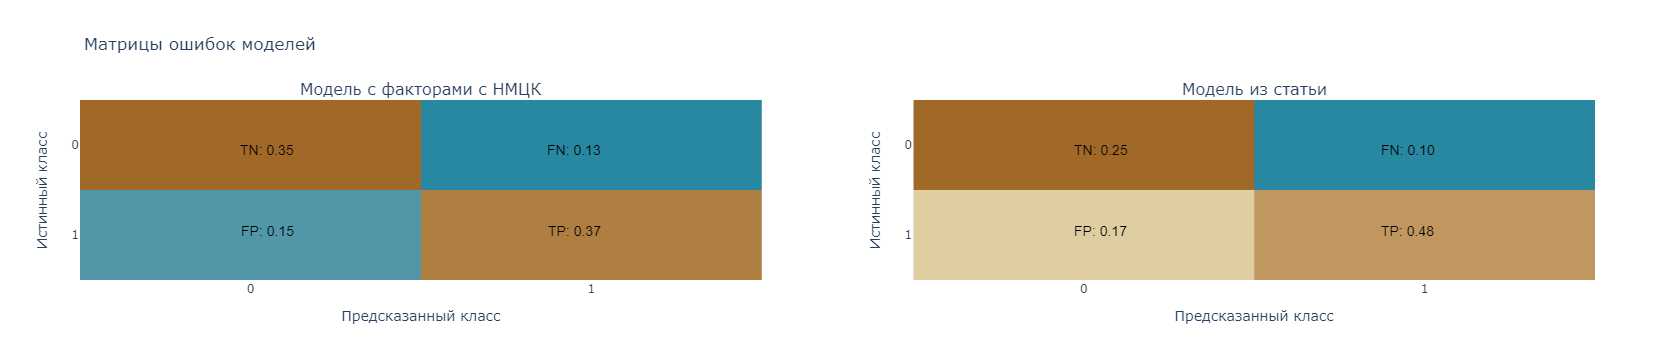

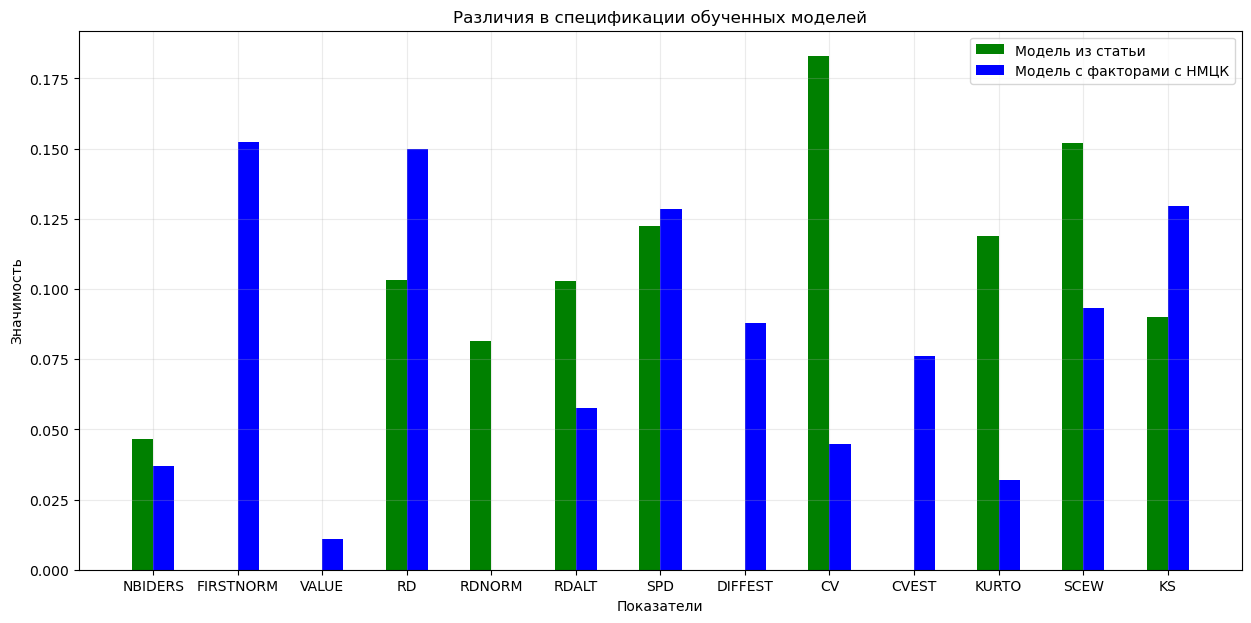

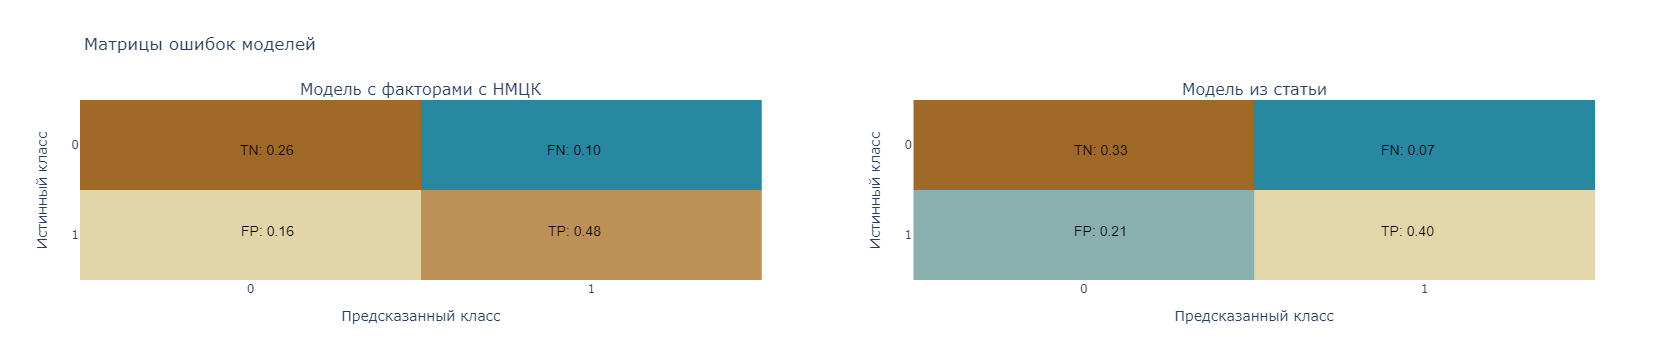

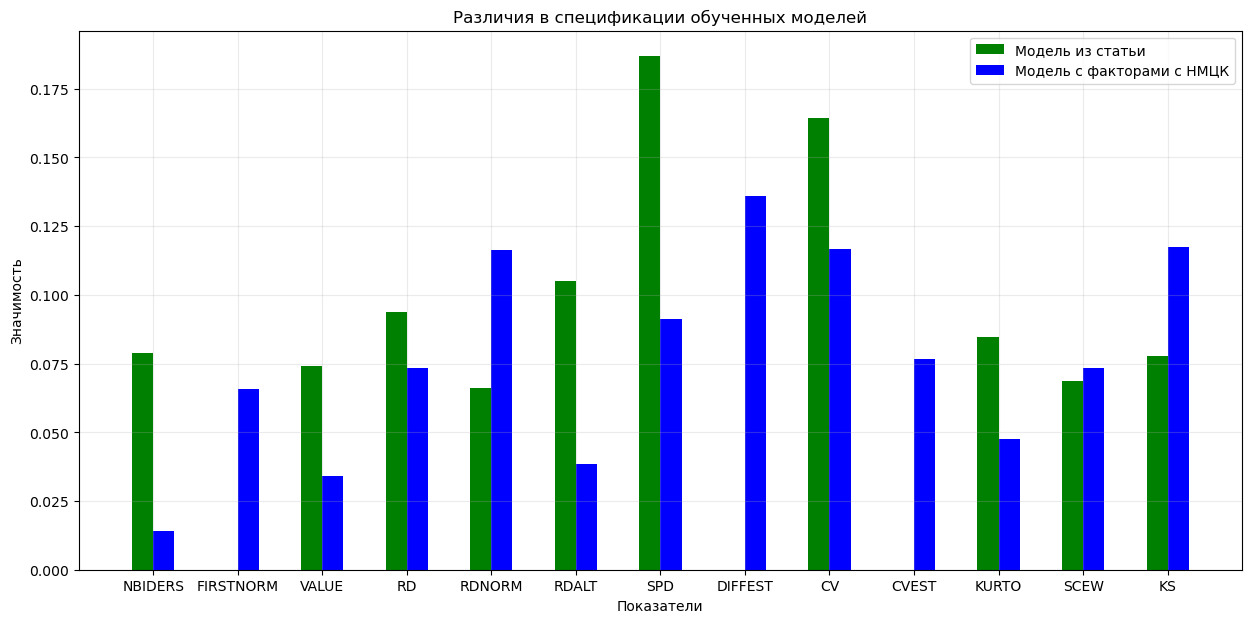

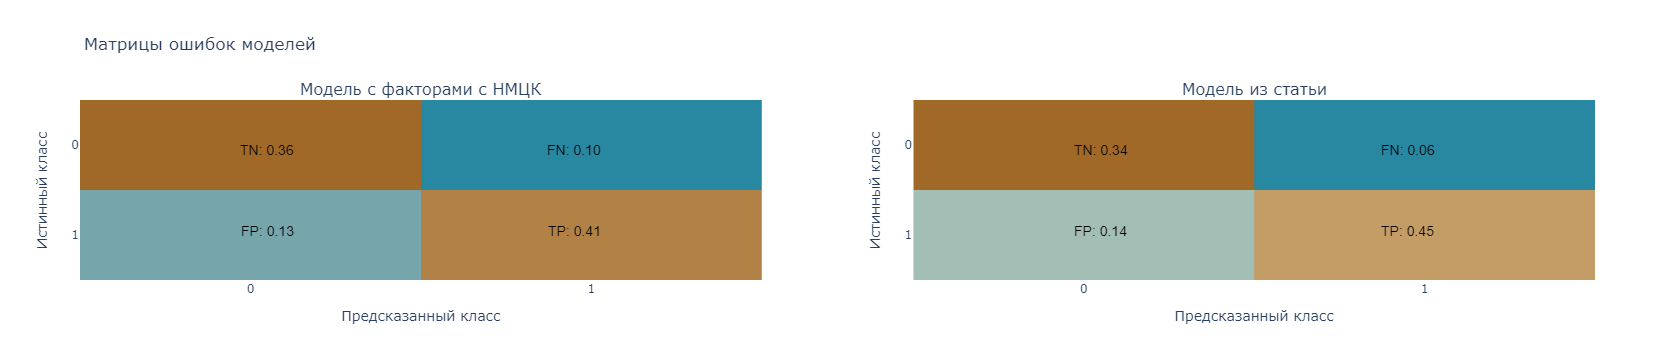

In [319]:
decision_plot(m0, m1, in_total = True)
decision_plot(m0, m0, in_total = True)
decision_plot(m1, m1, in_total = True)

### Подсчеты интересующих показателей | удаляем KURTO

In [320]:
col

['NBIDERS',
 'FIRSTNORM',
 'VALUE',
 'RD',
 'RDNORM',
 'RDALT',
 'SPD',
 'DIFFEST',
 'CV',
 'CVEST',
 'KURTO',
 'SCEW',
 'KS',
 'cartel']

In [565]:
col1 = [x for i, x in enumerate(col) if i!= 10 and i!= 11]
new = [x for i, x in enumerate(col) if i!= 1 and i!=7 and i!=9 and i!= 10 and i!= 11]

X = ML[col1[:-1]]
y = ML[col1[-1]]

X_orig = ML[new[:-1]]
y_orig = ML[new[-1]]

In [324]:
prec = []
model = []

for i in tqdm(range(100)):
    res = to_pred(X, y, outline = False)
    prec.append((i, res[-2]))
    model.append(res[0])

prec = sorted(prec, key = lambda x: -x[1])

prec_orig = []
model_orig = []

for i in tqdm(range(100)):
    res = to_pred(X_orig, y_orig, outline = False)
    prec_orig.append((i, res[-2]))
    model_orig.append(res[0])

prec_orig = sorted(prec_orig, key = lambda x: -x[1])

model[prec[0][0]], model_orig[prec_orig[0][0]]

100%|██████████| 100/100 [05:24<00:00,  3.25s/it]


(RandomForestClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=9,
                        n_estimators=7),
 RandomForestClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=9,
                        min_samples_split=5, n_estimators=6))

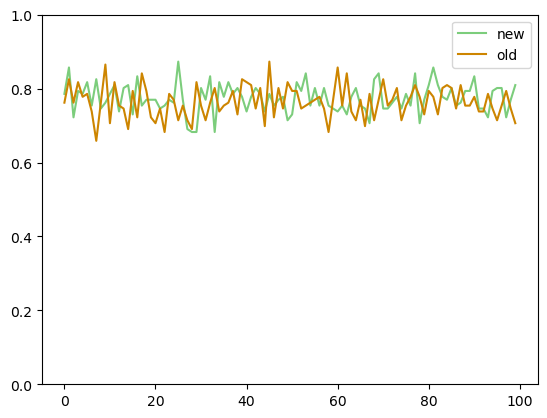

In [325]:
m0 = model[prec[0][0]]
m1 = model_orig[prec_orig[0][0]]

"""
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)
X_train1, x_test1, y_train1, y_test1 = train_test_split(X_orig, y_orig, test_size = 0.3, shuffle = True)

m0.fit(X_train, y_train)
m1.fit(X_train1, y_train1)

Precision = [precision_score(y_test, m0.predict(x_test)) for x in sorted(prec, key = lambda x: x[0])]
Precision_orig = [precision_score(y_test1, m1.predict(x_test1)) for x in sorted(prec, key = lambda x: x[0])]
"""
Precision, Precision_orig = [], []
for i in range(100):
    X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)
    X_train1, x_test1, y_train1, y_test1 = train_test_split(X_orig, y_orig, test_size = 0.3, shuffle = True)

    m0.fit(X_train, y_train)
    
    Precision.append(accuracy_score(y_test, m0.predict(x_test)) )
    
    m1.fit(X_train1, y_train1)

    Precision_orig.append(accuracy_score(y_test1, m1.predict(x_test1)) )

t = [x[0] for x in sorted(prec, key = lambda x: x[0])]

plt.plot(t, Precision, color = "#7CCD7C", label = "new")
plt.plot(t, Precision_orig, color = "#CD8500", label = "old")
plt.legend()
plt.ylim(0, 1)
plt.show()

In [326]:
stats.ttest_rel(Precision, Precision_orig)

TtestResult(statistic=1.653564495908666, pvalue=0.10138368172697206, df=99)

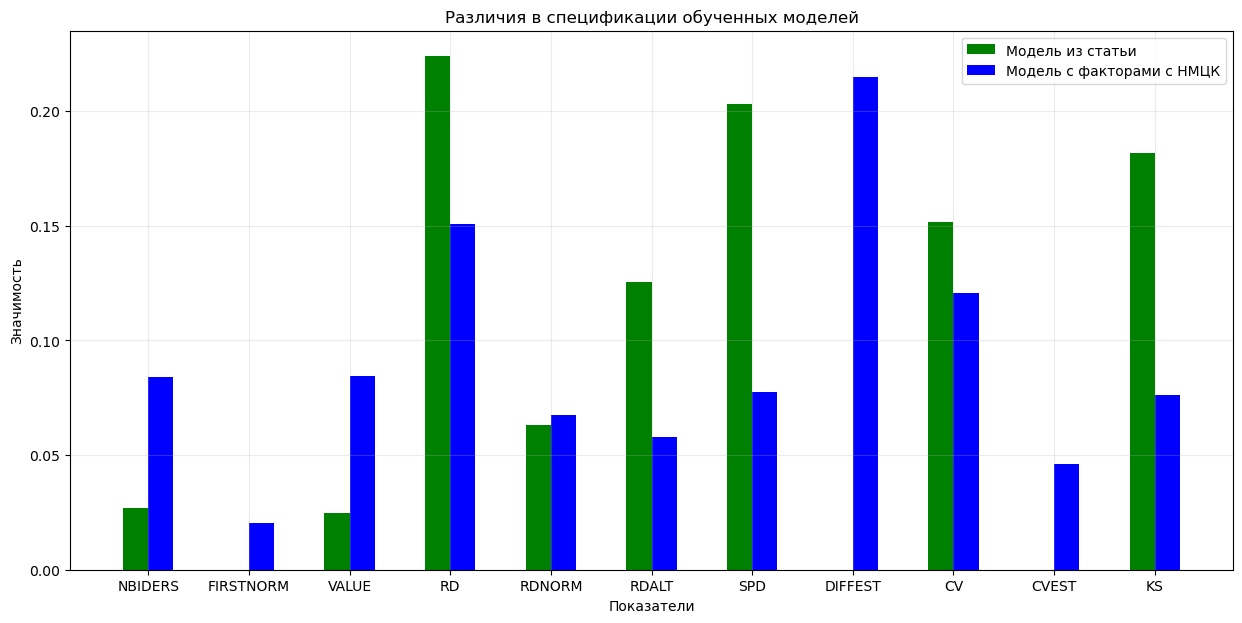

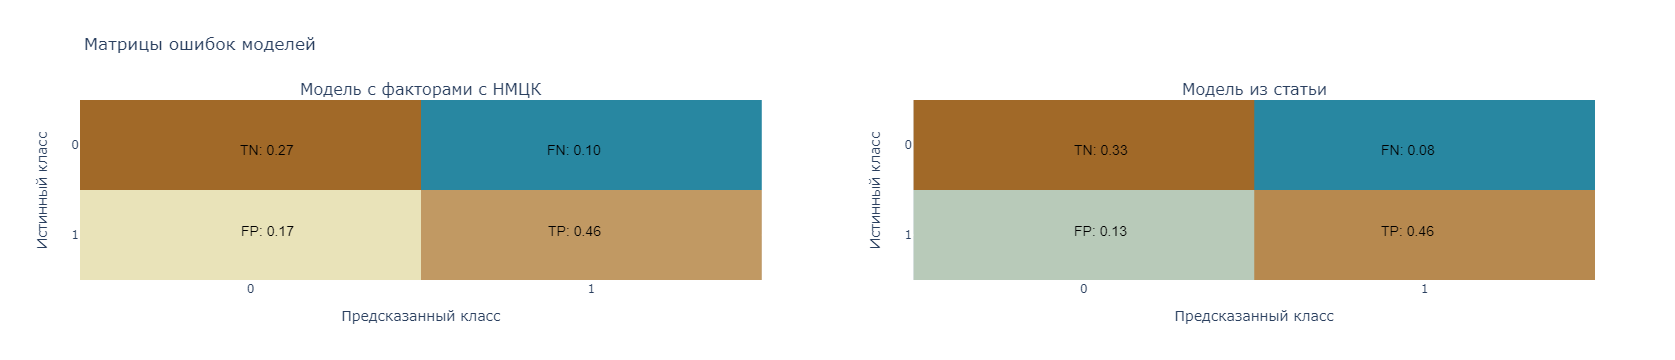

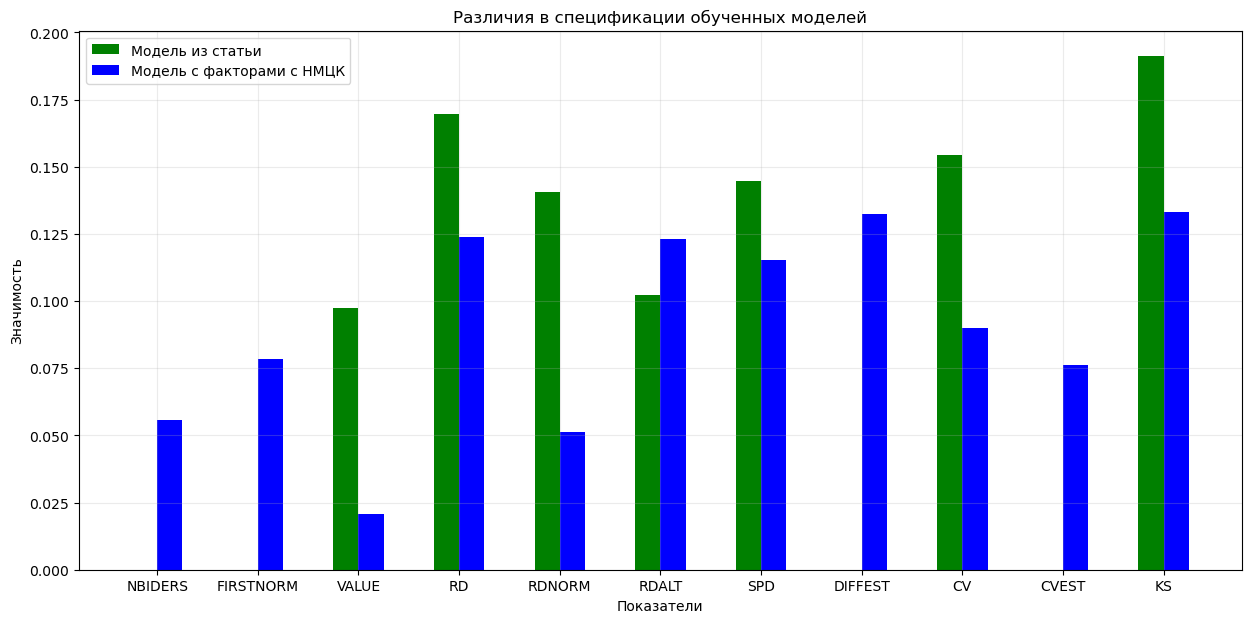

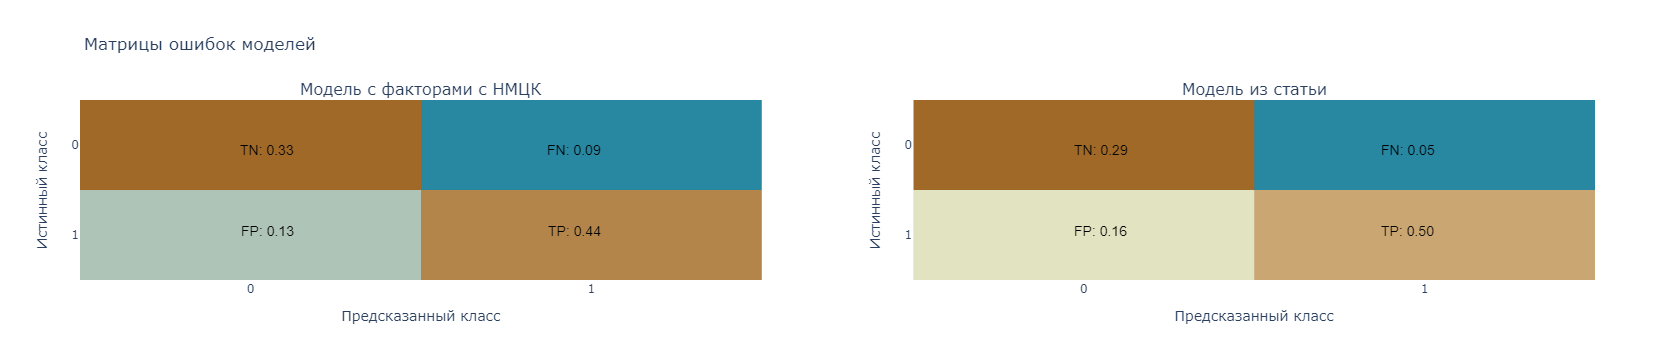

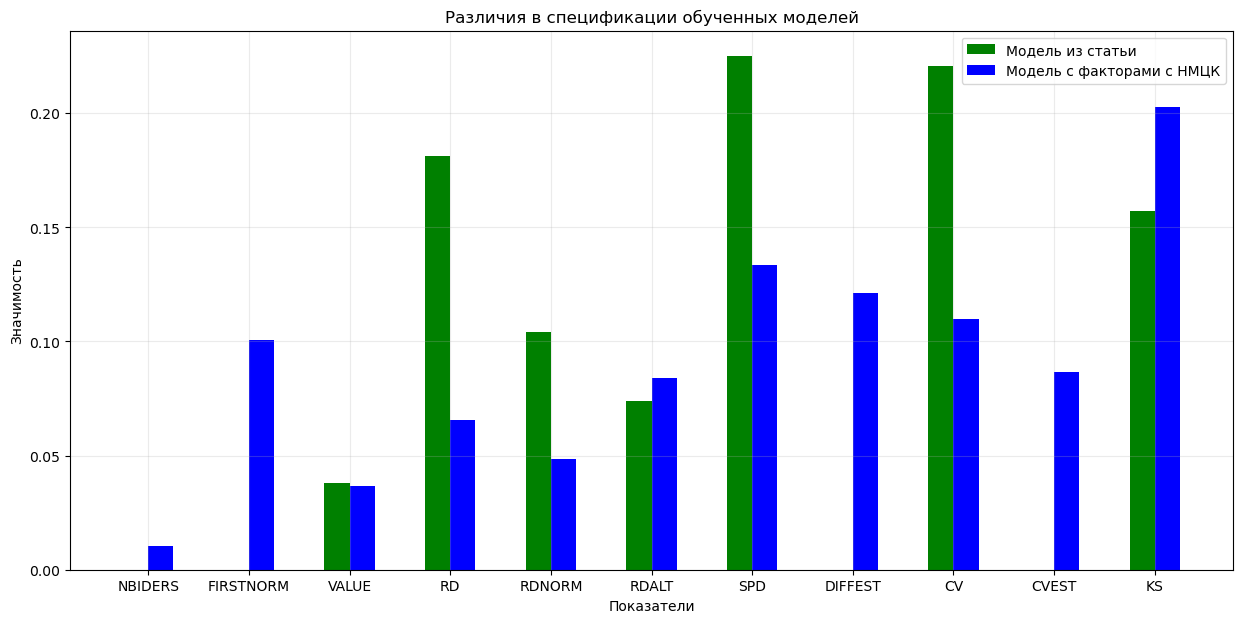

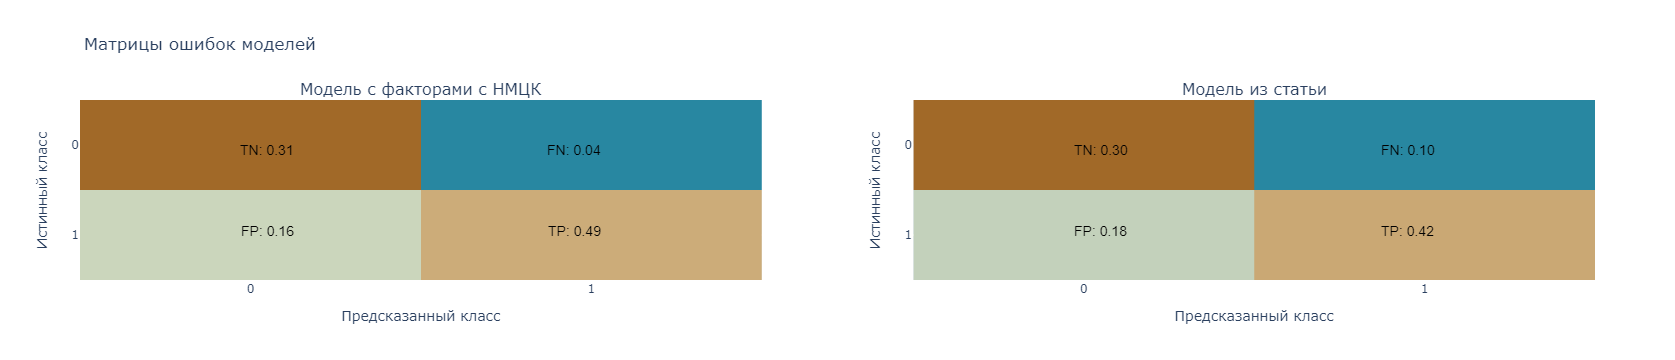

In [327]:
decision_plot(m0, m1, in_total = True)
decision_plot(m0, m0, in_total = True)
decision_plot(m1, m1, in_total = True)

In [567]:
m0, m1 = (RandomForestClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=9,
                        n_estimators=7),
 RandomForestClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=9,
                        min_samples_split=5, n_estimators=6))

print(cross_val_score(m0, X, y, cv =5, scoring = "accuracy"), cross_val_score(m1, X_orig, y_orig, cv =5, scoring = "accuracy"), "\n", sep = "\n")
print(cross_val_score(m0, X, y, cv =5, scoring = "accuracy"), cross_val_score(m0, X_orig, y_orig, cv =5, scoring = "accuracy"), "\n")
print(cross_val_score(m1, X, y, cv =5, scoring = "accuracy"), cross_val_score(m1, X_orig, y_orig, cv =5, scoring = "accuracy"), "\n")

[0.73809524 0.76190476 0.76190476 0.81927711 0.77108434]
[0.72619048 0.71428571 0.75       0.79518072 0.75903614]


[0.76190476 0.66666667 0.82142857 0.85542169 0.78313253] [0.71428571 0.73809524 0.76190476 0.81927711 0.75903614] 

[0.69047619 0.70238095 0.78571429 0.73493976 0.73493976] [0.77380952 0.6547619  0.79761905 0.72289157 0.81927711] 



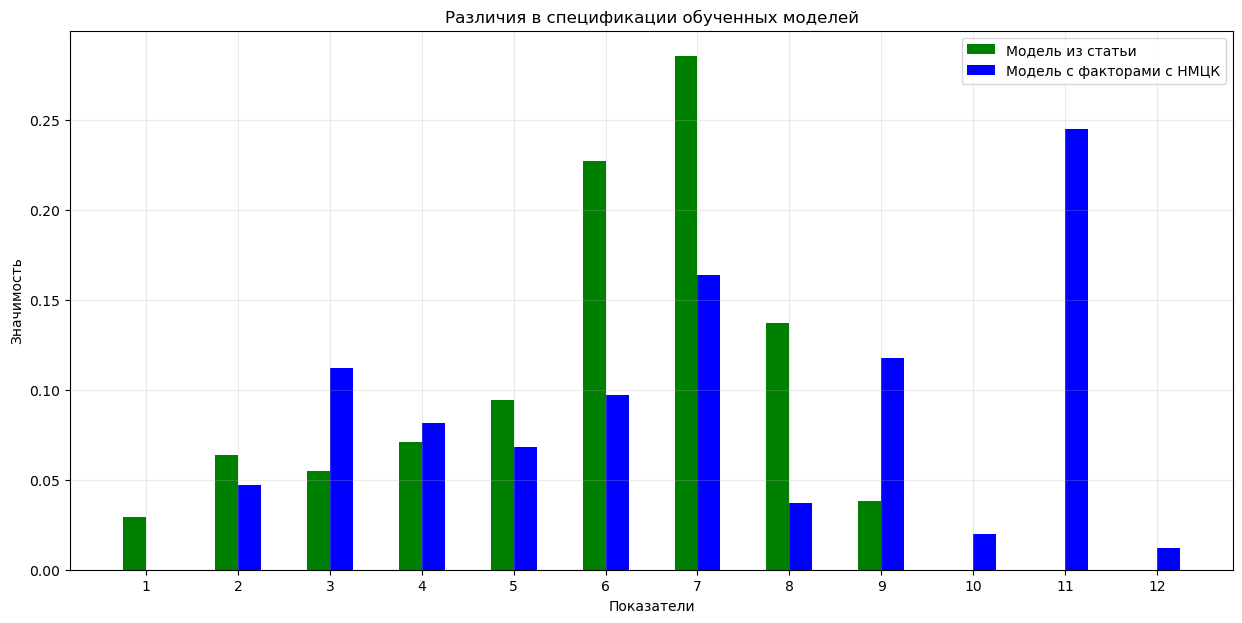

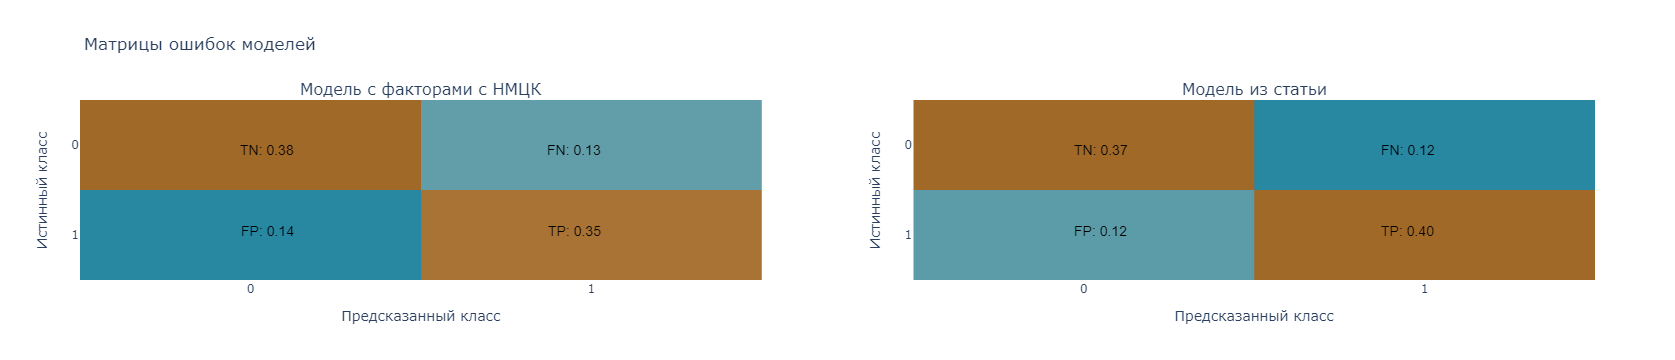

In [380]:
from sklearn.decomposition import PCA

new = [x for i, x in enumerate(col) if i!= 1 and i!=7 and i!=9]

n = len(col) - 2
n1 = len(new) - 2

pca, pca1 = PCA(n_components= n), PCA(n_components= n1)

X = ML[col[:-1]]
y = ML[col[-1]]

X_orig = ML[new[:-1]]
y_orig = ML[new[-1]]

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)
X_train1, x_test1, y_train1, y_test1 = train_test_split(X_orig, y_orig, test_size = 0.3, shuffle = True)

X_train_pca = pca.fit_transform(X_train)
x_test_pca = pca.transform(x_test)

X_train_pca1 = pca1.fit_transform(X_train1)
x_test_pca1 = pca1.transform(x_test1)

clf = RandomForestClassifier(class_weight='balanced', max_depth=7, max_leaf_nodes=9,
                        min_samples_split=6, n_estimators=9)

data = [[X_train_pca, x_test_pca, y_train, y_test],
        [X_train_pca1, x_test_pca1, y_train1, y_test1]]


decision_plot(clf, clf, in_total = True, data = data)

In [382]:
new = [x for i, x in enumerate(col) if i!= 1 and i!=7 and i!=9]

n = len(col) - 2
n1 = len(new) - 1

pca, pca1 = PCA(n_components= n), PCA(n_components= n1)

X = ML[col[:-1]]
y = ML[col[-1]]

X_orig = ML[new[:-1]]
y_orig = ML[new[-1]]

X_pca, X_pca1 = pca.fit_transform(X), pca1.fit_transform(X_orig)

cross_val_score(clf, X_pca, y, cv =5, scoring = "accuracy"), cross_val_score(clf, X_pca1, y_orig, cv =5, scoring = "accuracy")

(array([0.78571429, 0.83333333, 0.89285714, 0.85542169, 0.8313253 ]),
 array([0.69047619, 0.8452381 , 0.79761905, 0.85542169, 0.79518072]))

### Подсчеты интересующих показателей | обрезаем для корректного KURTO

In [329]:
ML_ = ML[ML["NBIDERS"] > 3]
ML_.reset_index(inplace = True, drop = True)
list(ML_.groupby(["cartel"]).count()["NBIDERS"])
ML_.groupby(["cartel"]).mean()

NBIDERS  FIRSTNORM          VALUE        RD    RDNORM     RDALT  \
cartel                                                                     
0.0     4.855670   0.578883  183417.508866  0.362401  0.177639  0.294949   
1.0     4.590476   0.543810  227350.383048  0.055546  0.088249  0.065129   

             SPD   DIFFEST        CV     CVEST     KURTO      SCEW         KS  
cartel                                                                         
0.0     0.634791  0.007453  0.195883  0.105637 -1.177159  1.113293  31.842552  
1.0     0.617797  0.005612  0.219905  0.142298 -1.047442  0.830132   6.717440

In [330]:
col1 = list(ML_.columns)
new = [x for i, x in enumerate(col1) if i!= 1 and i!=7 and i!=9]

X = ML[col1[:-1]]
y = ML[col1[-1]]

X_orig = ML[new[:-1]]
y_orig = ML[new[-1]]

In [331]:
prec = []
model = []

for i in tqdm(range(100)):
    res = to_pred(X, y, outline = False)
    prec.append((i, res[-2]))
    model.append(res[0])

prec = sorted(prec, key = lambda x: -x[1])

prec_orig = []
model_orig = []

for i in tqdm(range(100)):
    res = to_pred(X_orig, y_orig, outline = False)
    prec_orig.append((i, res[-2]))
    model_orig.append(res[0])

prec_orig = sorted(prec_orig, key = lambda x: -x[1])

model[prec[0][0]], model_orig[prec_orig[0][0]]

100%|██████████| 100/100 [05:47<00:00,  3.47s/it]


(RandomForestClassifier(class_weight='balanced', max_depth=9, max_leaf_nodes=9,
                        n_estimators=2),
 RandomForestClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=9,
                        min_samples_split=3, n_estimators=7))

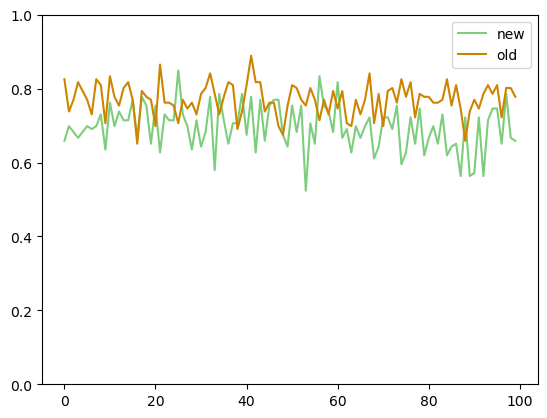

In [335]:
m0 = model[prec[0][0]]
m1 = model_orig[prec_orig[0][0]]

"""
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)
X_train1, x_test1, y_train1, y_test1 = train_test_split(X_orig, y_orig, test_size = 0.3, shuffle = True)

m0.fit(X_train, y_train)
m1.fit(X_train1, y_train1)

Precision = [precision_score(y_test, m0.predict(x_test)) for x in sorted(prec, key = lambda x: x[0])]
Precision_orig = [precision_score(y_test1, m1.predict(x_test1)) for x in sorted(prec, key = lambda x: x[0])]
"""
Precision, Precision_orig = [], []
for i in range(100):
    X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)
    X_train1, x_test1, y_train1, y_test1 = train_test_split(X_orig, y_orig, test_size = 0.3, shuffle = True)

    m0.fit(X_train, y_train)
    
    Precision.append(accuracy_score(y_test, m0.predict(x_test)) )
    
    m1.fit(X_train1, y_train1)

    Precision_orig.append(accuracy_score(y_test1, m1.predict(x_test1)) )

t = [x[0] for x in sorted(prec, key = lambda x: x[0])]

plt.plot(t, Precision, color = "#7CCD7C", label = "new")
plt.plot(t, Precision_orig, color = "#CD8500", label = "old")
plt.legend()
plt.ylim(0, 1)
plt.show()

In [336]:
stats.ttest_rel(Precision, Precision_orig)

TtestResult(statistic=-9.872664318287217, pvalue=2.0739897555997298e-16, df=99)

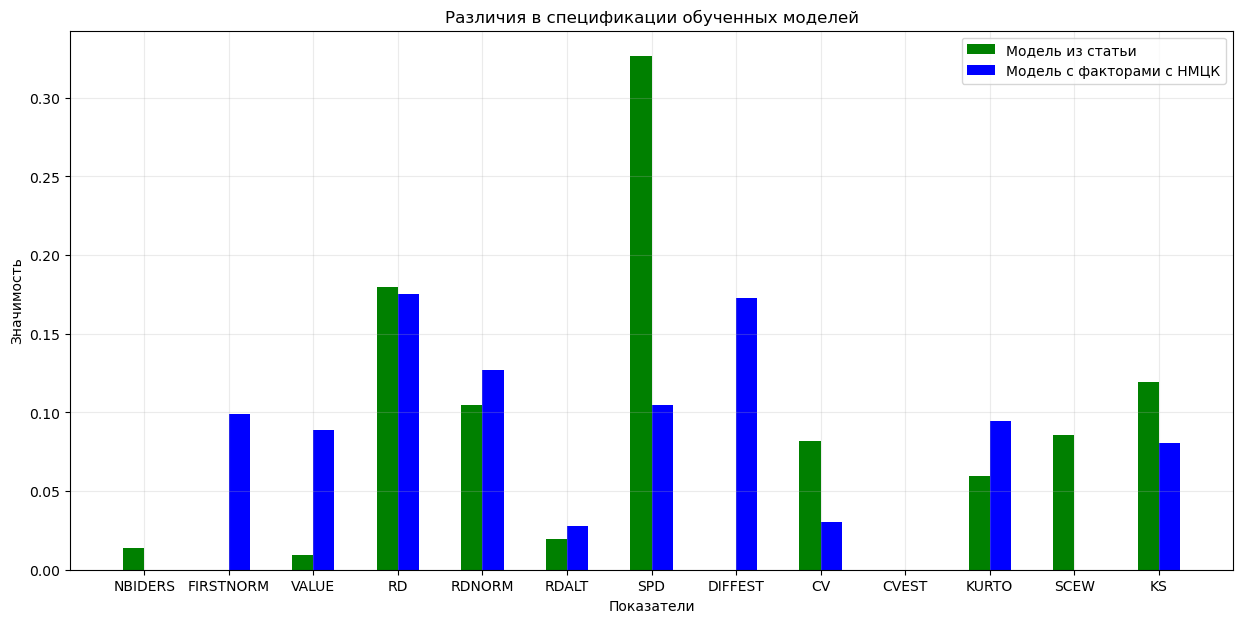

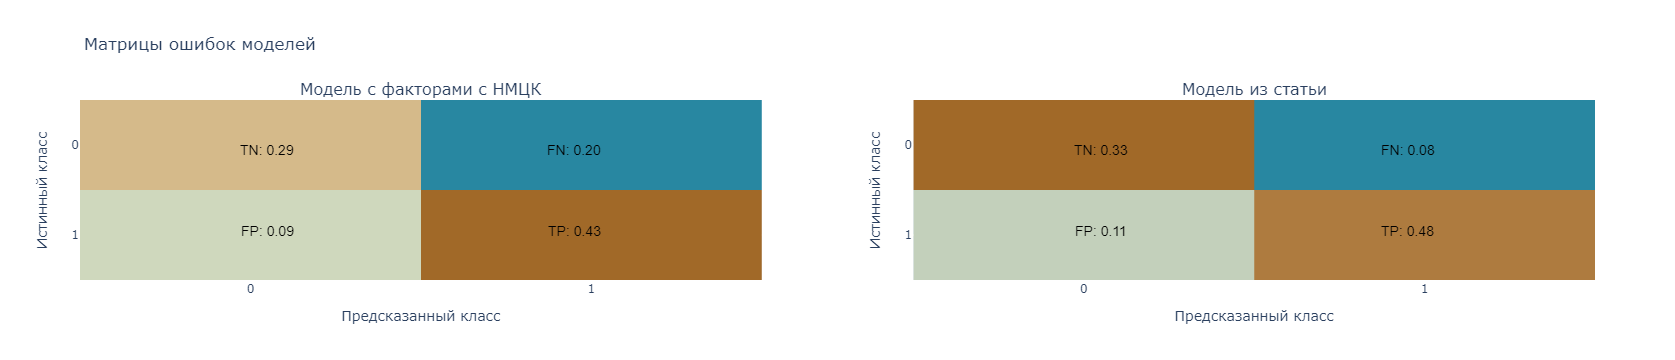

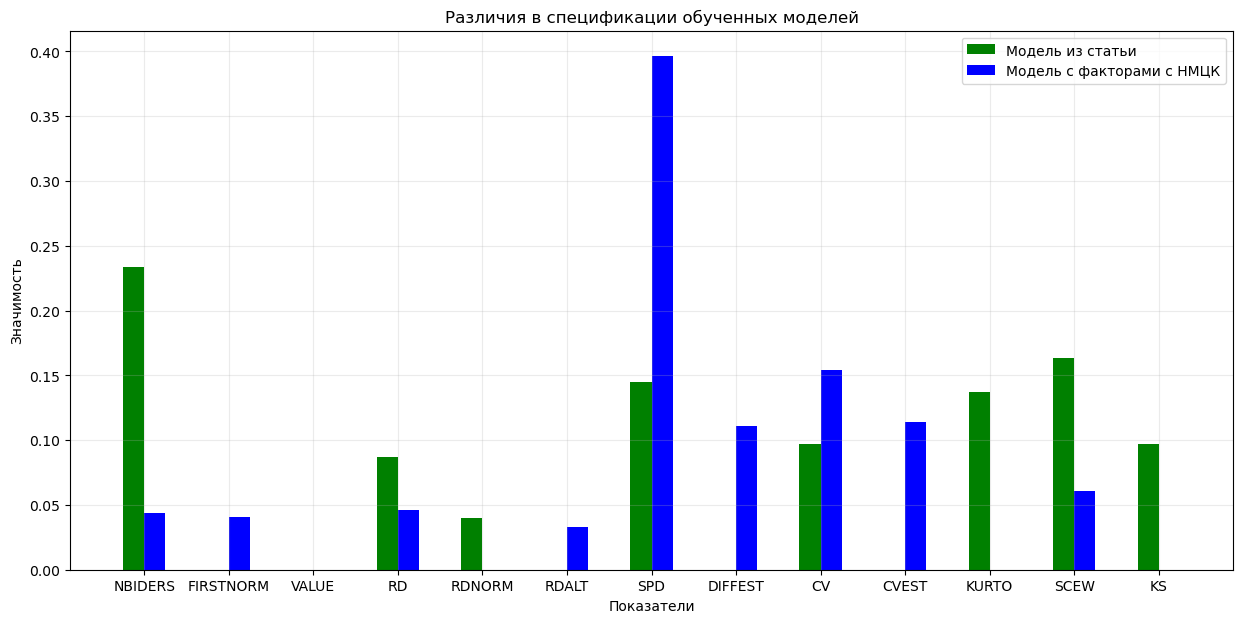

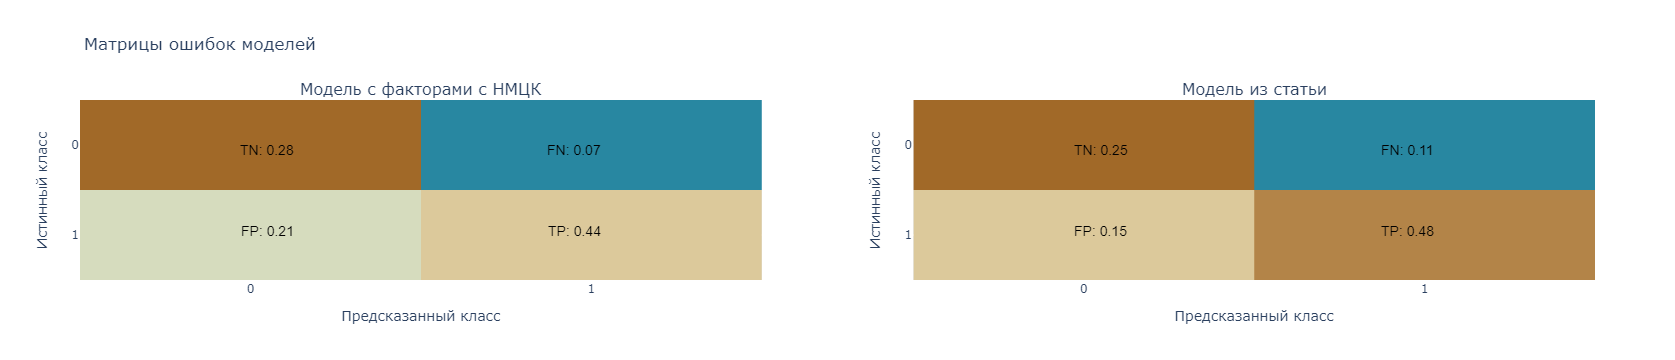

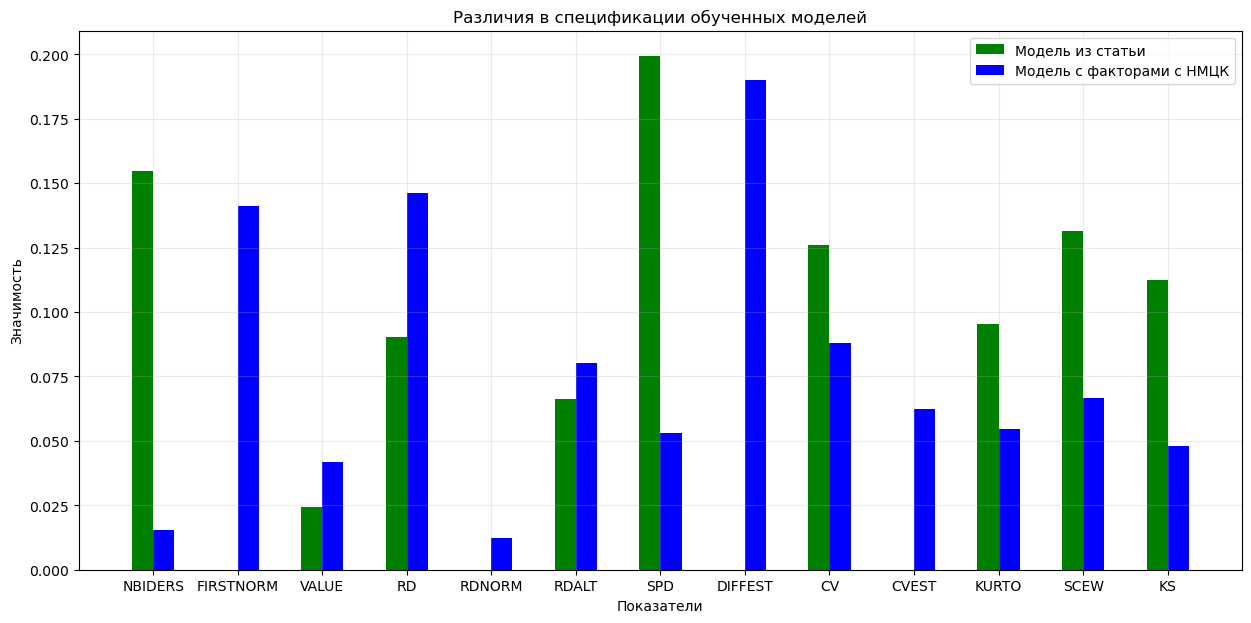

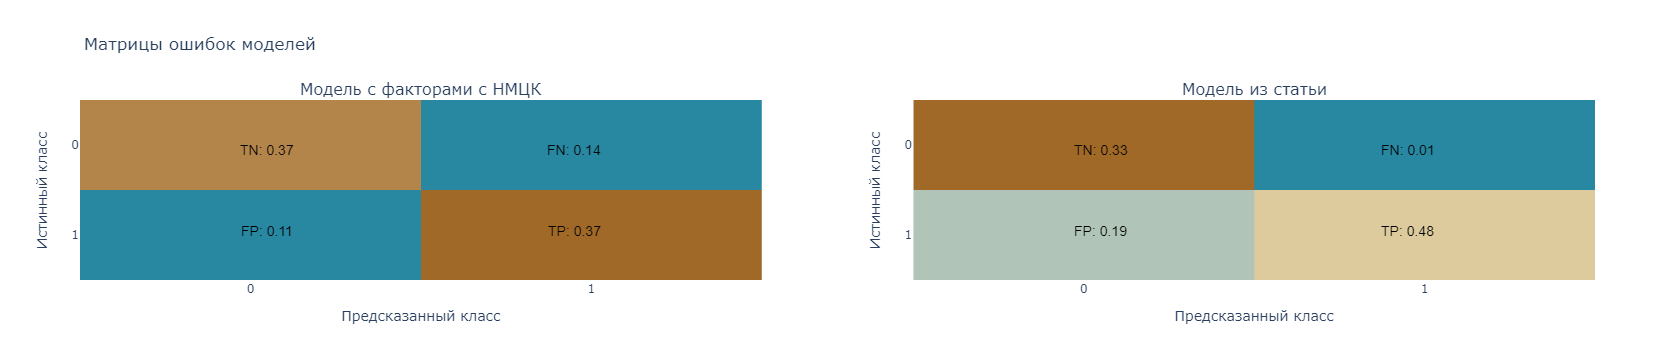

In [342]:
decision_plot(m0, m1, in_total = True)
decision_plot(m0, m0, in_total = True)
decision_plot(m1, m1, in_total = True)


### Подсчеты интересующих показателей | Кросс-валидация

In [559]:
col

['NBIDERS',
 'FIRSTNORM',
 'VALUE',
 'RD',
 'RDNORM',
 'RDALT',
 'SPD',
 'DIFFEST',
 'CV',
 'CVEST',
 'KURTO',
 'SCEW',
 'KS',
 'cartel']

In [560]:
"""
col = list(ML.columns)
new = [x for i, x in enumerate(list(ML.columns)) if i!= 1 and i!=7 and i!=9]

X = ML[col[:-1]]
y = ML[col[-1]]

X_orig = ML[new[:-1]]
y_orig = ML[new[-1]]
"""
col1 = [x for i, x in enumerate(col) if i!= 9 and i!= 10 and i!= 11]
new = [x for i, x in enumerate(col) if i!= 1 and i!=7 and i!=9 and i!= 10 and i!= 11]

X = ML[col1[:-1]]
y = ML[col1[-1]]

X_orig = ML[new[:-1]]
y_orig = ML[new[-1]]

In [561]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(
    min_samples_split = 3,
    min_samples_leaf = 3,
    n_estimators = 10,
)

m0, m1 = (RandomForestClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=9,
                        n_estimators=7),
 RandomForestClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=9,
                        min_samples_split=5, n_estimators=6))

In [563]:
from sklearn.model_selection import cross_val_score

cross_val_score(m1, X, y, cv =5, scoring = "accuracy"), cross_val_score(m1, X_orig, y_orig, cv =5, scoring = "accuracy")

(array([0.67857143, 0.70238095, 0.72619048, 0.8313253 , 0.78313253]),
 array([0.77380952, 0.70238095, 0.73809524, 0.75903614, 0.74698795]))

In [564]:
ML.to_excel("C:/Users/Admin/Desktop/ML.xlsx", index = False)